In [12]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For partial regression plots
from statsmodels.graphics.regressionplots import plot_partregress_grid

# For cross-validation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# Setting a style for plots
sns.set_style("whitegrid")

In [14]:
dataset = pd.read_csv("/content/cleaned_dataset.csv")

In [15]:
# Suppose your original DataFrame is called 'dataset'
excluded_cols = [
    'submitdate. Date submitted',
    'lastpage. Last page',
    'startlanguage. Start language',
    'seed. Seed',
    'refurl. Referrer URL',
    'G33Q250. Please enter your Prolific ID:',
    'G02Q251. By starting the survey, you consent to participate in the research described above and allow the use of the anonymous data for educational and research purposes. Participation in the study is entirely voluntary. If for any reason you no longer wish to participate in the study, you may exit the survey before submitting the responses.',
    'G04Q11. How old are you?     ',
    'G02Q18. Please enter your citizenship:',
    'G04Q12. What is your highest completed level of education?',
    'G04Q13. What is your level of English proficiency?',
    'G04Q14. Do you have any previous experience in the field of machine learning?',
    'G04Q16. Do you have any previous experience with counterfactual explanation frameworks or causality frameworks?',
    'G02Q17. Do you have a medical background?',
    'G02Q08. From 1 (not at all) to 6 (perfectly), how well did you understand the metrics:',
    'G35Q252. To complete the questionnaire, please click the Submit button. You will be redirected to Prolific.',
    'G27Q249. '
]

# 1. Drop unwanted columns
df_values = dataset.drop(columns=excluded_cols, errors="ignore")

In [16]:
# prompt: look for column that has value "here" in dataset and remove that column

import pandas as pd

# ... (Your existing code)

# Find columns with the value "here" and remove them
for col in df_values.columns:
    if df_values[col].isin(["here"]).any():
        df_values = df_values.drop(columns=[col])
        print(f"Removed column: {col}")


In [17]:
df_values.head()

id. Response ID  \
0               64   
1               66   
2               67   
3               68   
4               69   

   r3q0. On a scale from 1 (very unsatisfied) to 6 (very satisfied), how satisfied would you be with such an explanation:   \
0                                                  2                                                                         
1                                                  5                                                                         
2                                                  5                                                                         
3                                                  3                                                                         
4                                                  2                                                                         

   r40q0. On a scale from 1 (very infeasible) to 6 (very easy to do), how feasible is this explanation:   \
0                                                  3                                                       
1                                                  4                                                       
2                                                  5                                                       
3                                                  3                                                       
4                                                  2                                                       

   r320q0. On a scale from 1 (very inconsistent) to 6 (very consistent), how consistent is this explanation:   \
0                                                  4                                                            
1                                                  4                                                            
2                                                  5                                                            
3                                                  4                                                            
4                                                  2                                                            

   r599q2. On a scale from 1 (very incomplete) to 6 (very complete), how complete is this explanation:   \
0                                                  1                                                      
1                                                  4                                                      
2                                                  4                                                      
3                                                  4                                                      
4                                                  2                                                      

   r720q0. On a scale from 1 (not at all) to 6 (very much), how much do you trust this explanation:   \
0                                                  2                                                   
1                                                  5                                                   
2                                                  5                                                   
3                                                  3                                                   
4                                                  1                                                   

   r810q0. On a scale from 1 (incomprehensible) to 6 (very understandable), how understandable is this explanation:   \
0                                                  6                                                                   
1                                                  5                                                                   
2                                                  5                                                                   
3                                    

In [18]:
df_values.shape

(196, 241)

In [19]:
# 1. Identify the first column (Response ID) and isolate the scenario columns
id_col = df_values.columns[0]
scenario_cols = df_values.columns[1:]  # everything except the first column

# 2. Check how many scenario columns remain
n_scenario_cols = len(scenario_cols)
print(f"Scenario columns (excluding ID): {n_scenario_cols}")

# Expecting 240 columns (30 scenarios × 8 metrics)
assert n_scenario_cols == 30 * 8, (
    f"Expected 240 columns for 30 scenarios × 8 metrics, but found {n_scenario_cols}."
    " Please verify or adjust your approach."
)

# 3. Create the new column names for those 240 scenario columns
metrics_list = [
    "Satisfaction",
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",  # or 'Understandability' if that's the intended spelling
    "Fairness",
    "Complexity"
]

new_column_names = []
for scenario_idx in range(1, 31):  # 1 to 30
    for metric in metrics_list:
        new_column_names.append(f"{metric}_{scenario_idx}")

# 4. Build a rename dictionary mapping the old scenario columns to new column names
rename_dict = dict(zip(scenario_cols, new_column_names))

# 5. Rename only the scenario columns in df_values
df_values.rename(columns=rename_dict, inplace=True)

# The first column (ID) is untouched. Let's check:
print("Columns after renaming:")
print(df_values.columns.tolist())

Scenario columns (excluding ID): 240
Columns after renaming:
['id. Response ID', 'Satisfaction_1', 'Feasibility_1', 'Consistency_1', 'Completeness_1', 'Trust_1', 'Understandability_1', 'Fairness_1', 'Complexity_1', 'Satisfaction_2', 'Feasibility_2', 'Consistency_2', 'Completeness_2', 'Trust_2', 'Understandability_2', 'Fairness_2', 'Complexity_2', 'Satisfaction_3', 'Feasibility_3', 'Consistency_3', 'Completeness_3', 'Trust_3', 'Understandability_3', 'Fairness_3', 'Complexity_3', 'Satisfaction_4', 'Feasibility_4', 'Consistency_4', 'Completeness_4', 'Trust_4', 'Understandability_4', 'Fairness_4', 'Complexity_4', 'Satisfaction_5', 'Feasibility_5', 'Consistency_5', 'Completeness_5', 'Trust_5', 'Understandability_5', 'Fairness_5', 'Complexity_5', 'Satisfaction_6', 'Feasibility_6', 'Consistency_6', 'Completeness_6', 'Trust_6', 'Understandability_6', 'Fairness_6', 'Complexity_6', 'Satisfaction_7', 'Feasibility_7', 'Consistency_7', 'Completeness_7', 'Trust_7', 'Understandability_7', 'Fairness_7

In [20]:
df_values.head()

id. Response ID  Satisfaction_1  Feasibility_1  Consistency_1  \
0               64               2              3              4   
1               66               5              4              4   
2               67               5              5              5   
3               68               3              3              4   
4               69               2              2              2   

   Completeness_1  Trust_1  Understandability_1  Fairness_1  Complexity_1  \
0               1        2                    6           6            -2   
1               4        5                    5           5             0   
2               4        5                    5           3            -1   
3               4        3                    2           2             1   
4               2        1                    4           2            -1   

   Satisfaction_2  ...  Fairness_29  Complexity_29  Satisfaction_30  \
0               2  ...            3             -2                2   
1               4  ...            2              0                3   
2               4  ...            4              0                4   
3               4  ...            1              2                3   
4               6  ...            1             -2                1   

   Feasibility_30  Consistency_30  Completeness_30  Trust_30  \
0               1               1                1         1   
1               2               2                3         2   
2               5               5                5         5   
3               1               4                4         3   
4               1               1                5         1   

   Understandability_30  Fairness_30  Complexity_30  
0                     2            3             -1  
1                     4            4              2  
2                     5            5              0  
3                     3            2              2  
4                     5            1             -2  

[5 rows x 241 columns]

In [21]:
df_long_list = []

# The ID column is:
ID_COL = df_values.columns[0]  # or explicitly "ResponseID" if you renamed it

# We'll systematically loop scenario by scenario (1..30)
for scenario_idx in range(1, 31):
    # Build column names for this scenario
    # e.g. Satisfaction_1, Feasibility_1, ...
    suff = f"_{scenario_idx}"
    scenario_cols = {
        "Satisfaction": f"Satisfaction{suff}",
        "Feasibility": f"Feasibility{suff}",
        "Consistency": f"Consistency{suff}",
        "Completeness": f"Completeness{suff}",
        "Trust": f"Trust{suff}",
        "Understandability": f"Understandability{suff}",  # or "Understandability"
        "Fairness": f"Fairness{suff}",
        "Complexity": f"Complexity{suff}"
    }

    # Subset the wide DataFrame
    df_scen = df_values[[ID_COL] + list(scenario_cols.values())].copy()
    # Rename these scenario columns to a consistent set
    rename_dict = {
        scenario_cols["Satisfaction"]: "Satisfaction",
        scenario_cols["Feasibility"]: "Feasibility",
        scenario_cols["Consistency"]: "Consistency",
        scenario_cols["Completeness"]: "Completeness",
        scenario_cols["Trust"]: "Trust",
        scenario_cols["Understandability"]: "Understandability",
        scenario_cols["Fairness"]: "Fairness",
        scenario_cols["Complexity"]: "Complexity"
    }
    df_scen.rename(columns=rename_dict, inplace=True)

    # Add a "ScenarioID" column
    df_scen["ScenarioID"] = scenario_idx

    # Append to list
    df_long_list.append(df_scen)

# Concatenate all scenario subsets
df_long = pd.concat(df_long_list, ignore_index=True)

print(df_long.head(10))
print(df_long.columns)

   id. Response ID  Satisfaction  Feasibility  Consistency  Completeness  \
0               64             2            3            4             1   
1               66             5            4            4             4   
2               67             5            5            5             4   
3               68             3            3            4             4   
4               69             2            2            2             2   
5               70             2            2            3             2   
6               71             4            6            6             4   
7               72             4            5            5             5   
8               73             4            5            5             4   
9               74             3            2            3             1   

   Trust  Understandability  Fairness  Complexity  ScenarioID  
0      2                  6         6          -2           1  
1      5                  5        

In [22]:
df_long.head()

id. Response ID  Satisfaction  Feasibility  Consistency  Completeness  \
0               64             2            3            4             1   
1               66             5            4            4             4   
2               67             5            5            5             4   
3               68             3            3            4             4   
4               69             2            2            2             2   

   Trust  Understandability  Fairness  Complexity  ScenarioID  
0      2                  6         6          -2           1  
1      5                  5         5           0           1  
2      5                  5         3          -1           1  
3      3                  2         2           1           1  
4      1                  4         2          -1           1

In [23]:
df_long.ScenarioID.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

       id. Response ID  Satisfaction  Feasibility  Consistency  Completeness  \
count      5880.000000   5880.000000  5880.000000  5880.000000   5880.000000   
mean        229.857143      3.022619     3.269898     3.691327      3.378571   
std         107.758874      1.736709     1.768960     1.842809      1.735695   
min          64.000000      1.000000     1.000000     1.000000      1.000000   
25%         124.750000      1.000000     2.000000     2.000000      2.000000   
50%         272.500000      3.000000     3.000000     4.000000      3.000000   
75%         328.500000      4.000000     5.000000     5.000000      5.000000   
max         390.000000      6.000000     6.000000     6.000000      6.000000   

             Trust  Understandability     Fairness   Complexity   ScenarioID  
count  5880.000000        5880.000000  5880.000000  5880.000000  5880.000000  
mean      3.156803           4.819898     3.894898    -0.263095    15.500000  
std       1.813063           1.493780     

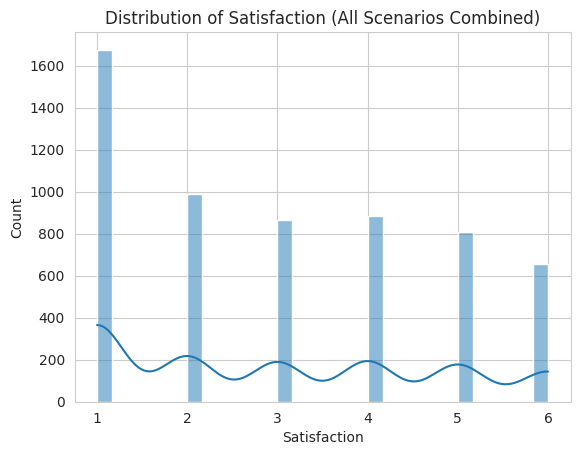

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2.1 Basic summary of all numeric columns
print(df_long.describe())

# 2.2 Distribution of Overall Satisfaction (all scenarios combined)
sns.histplot(df_long["Satisfaction"], bins=30, kde=True)
plt.title("Distribution of Satisfaction (All Scenarios Combined)")
plt.show()

       id. Response ID  Satisfaction  Feasibility  Consistency  Completeness  \
count      5880.000000   5880.000000  5880.000000  5880.000000   5880.000000   
mean        229.857143      3.022619     3.269898     3.691327      3.378571   
std         107.758874      1.736709     1.768960     1.842809      1.735695   
min          64.000000      1.000000     1.000000     1.000000      1.000000   
25%         124.750000      1.000000     2.000000     2.000000      2.000000   
50%         272.500000      3.000000     3.000000     4.000000      3.000000   
75%         328.500000      4.000000     5.000000     5.000000      5.000000   
max         390.000000      6.000000     6.000000     6.000000      6.000000   

             Trust  Understandability     Fairness   Complexity   ScenarioID  
count  5880.000000        5880.000000  5880.000000  5880.000000  5880.000000  
mean      3.156803           4.819898     3.894898    -0.263095    15.500000  
std       1.813063           1.493780     

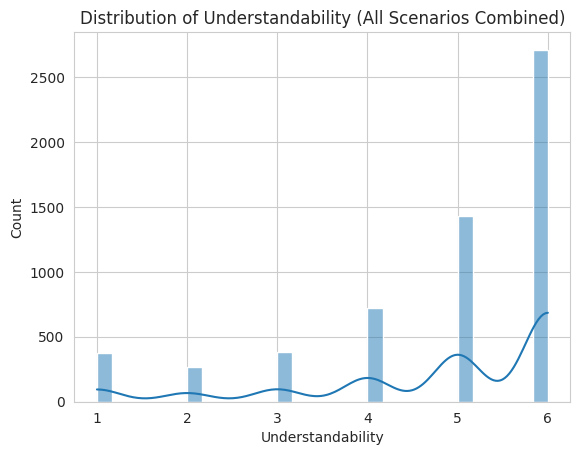

<Figure size 640x480 with 0 Axes>

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2.1 Basic summary of all numeric columns
print(df_long.describe())

# 2.2 Distribution of Overall Satisfaction (all scenarios combined)
sns.histplot(df_long["Understandability"], bins=30, kde=True)
plt.title("Distribution of Understandability (All Scenarios Combined)")
plt.show()
plt.savefig("distribution_understandability.png")

       id. Response ID  Satisfaction  Feasibility  Consistency  Completeness  \
count      5880.000000   5880.000000  5880.000000  5880.000000   5880.000000   
mean        229.857143      3.022619     3.269898     3.691327      3.378571   
std         107.758874      1.736709     1.768960     1.842809      1.735695   
min          64.000000      1.000000     1.000000     1.000000      1.000000   
25%         124.750000      1.000000     2.000000     2.000000      2.000000   
50%         272.500000      3.000000     3.000000     4.000000      3.000000   
75%         328.500000      4.000000     5.000000     5.000000      5.000000   
max         390.000000      6.000000     6.000000     6.000000      6.000000   

             Trust  Understandability     Fairness   Complexity   ScenarioID  
count  5880.000000        5880.000000  5880.000000  5880.000000  5880.000000  
mean      3.156803           4.819898     3.894898    -0.263095    15.500000  
std       1.813063           1.493780     

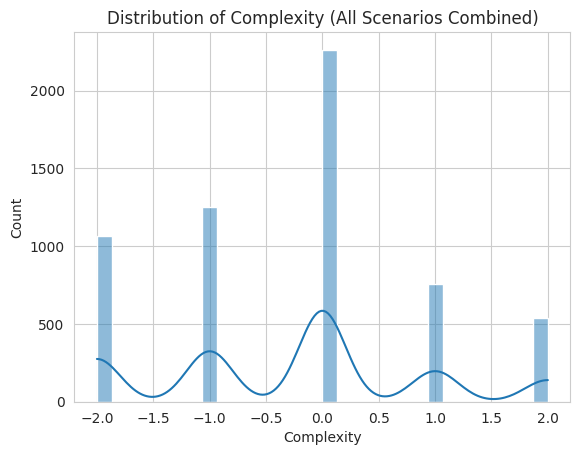

<Figure size 640x480 with 0 Axes>

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2.1 Basic summary of all numeric columns
print(df_long.describe())

# 2.2 Distribution of Overall Satisfaction (all scenarios combined)
sns.histplot(df_long["Complexity"], bins=30, kde=True)
plt.title("Distribution of Complexity (All Scenarios Combined)")
plt.show()
plt.savefig("distribution_complexity.png")

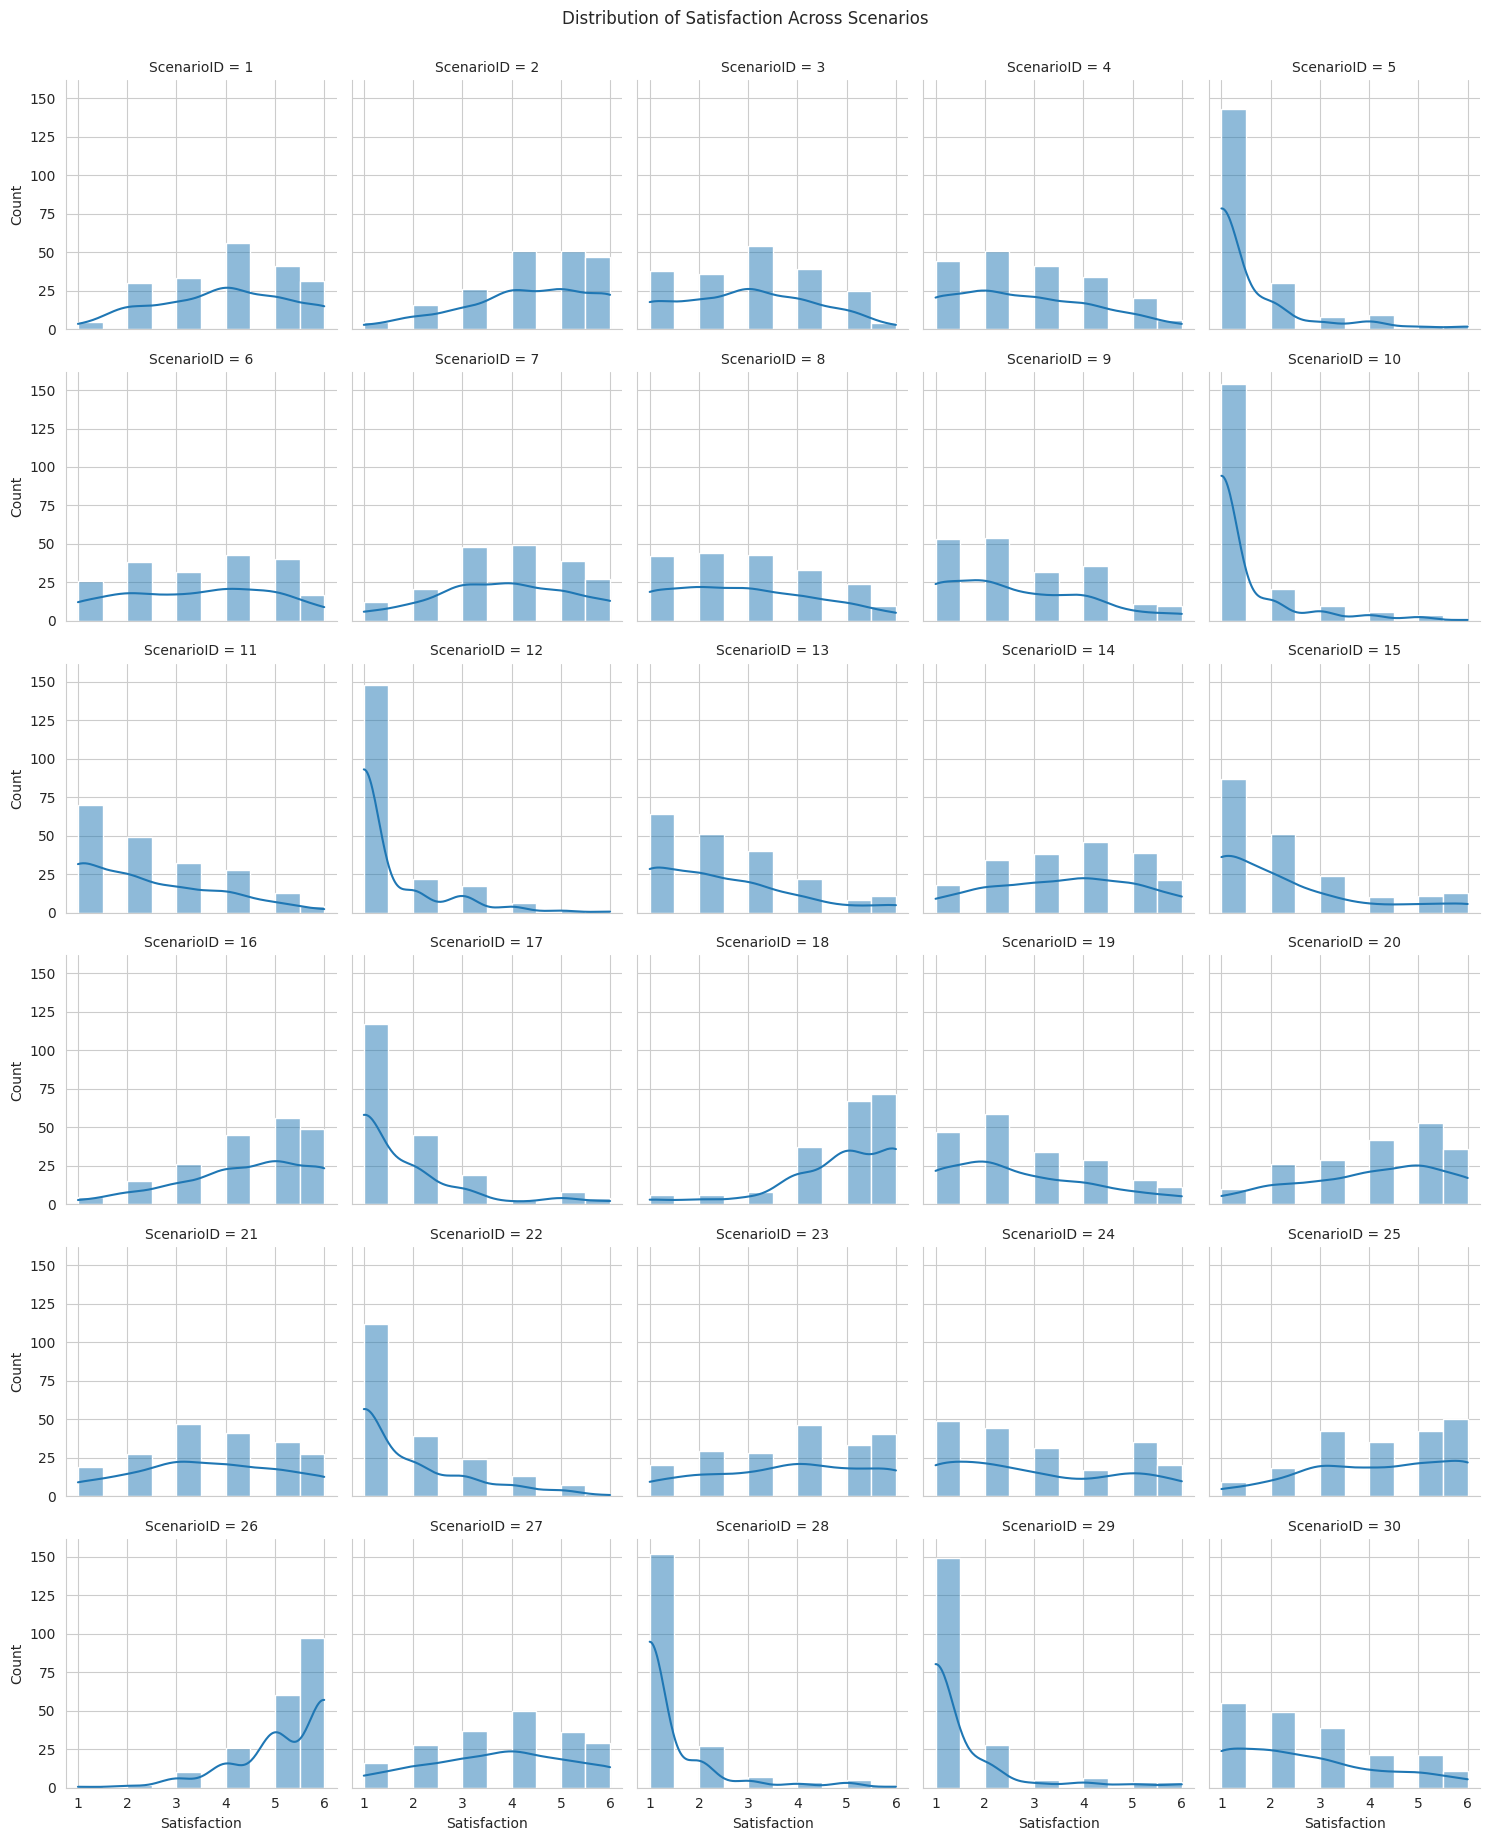

In [27]:
g = sns.FacetGrid(df_long, col="ScenarioID", col_wrap=5, height=3)
g.map(sns.histplot, "Satisfaction", bins=10, kde=True)
plt.suptitle("Distribution of Satisfaction Across Scenarios", y=1.02)
plt.show()

In [28]:
df_melt = df_long.melt(
    id_vars=["id. Response ID", "ScenarioID"],
    value_vars=["Satisfaction",
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Fairness"],
    var_name="Metric",       # new column to indicate which metric
    value_name="Rating"      # new column with the numeric value
)

print(df_melt.head())

   id. Response ID  ScenarioID        Metric  Rating
0               64           1  Satisfaction       2
1               66           1  Satisfaction       5
2               67           1  Satisfaction       5
3               68           1  Satisfaction       3
4               69           1  Satisfaction       2


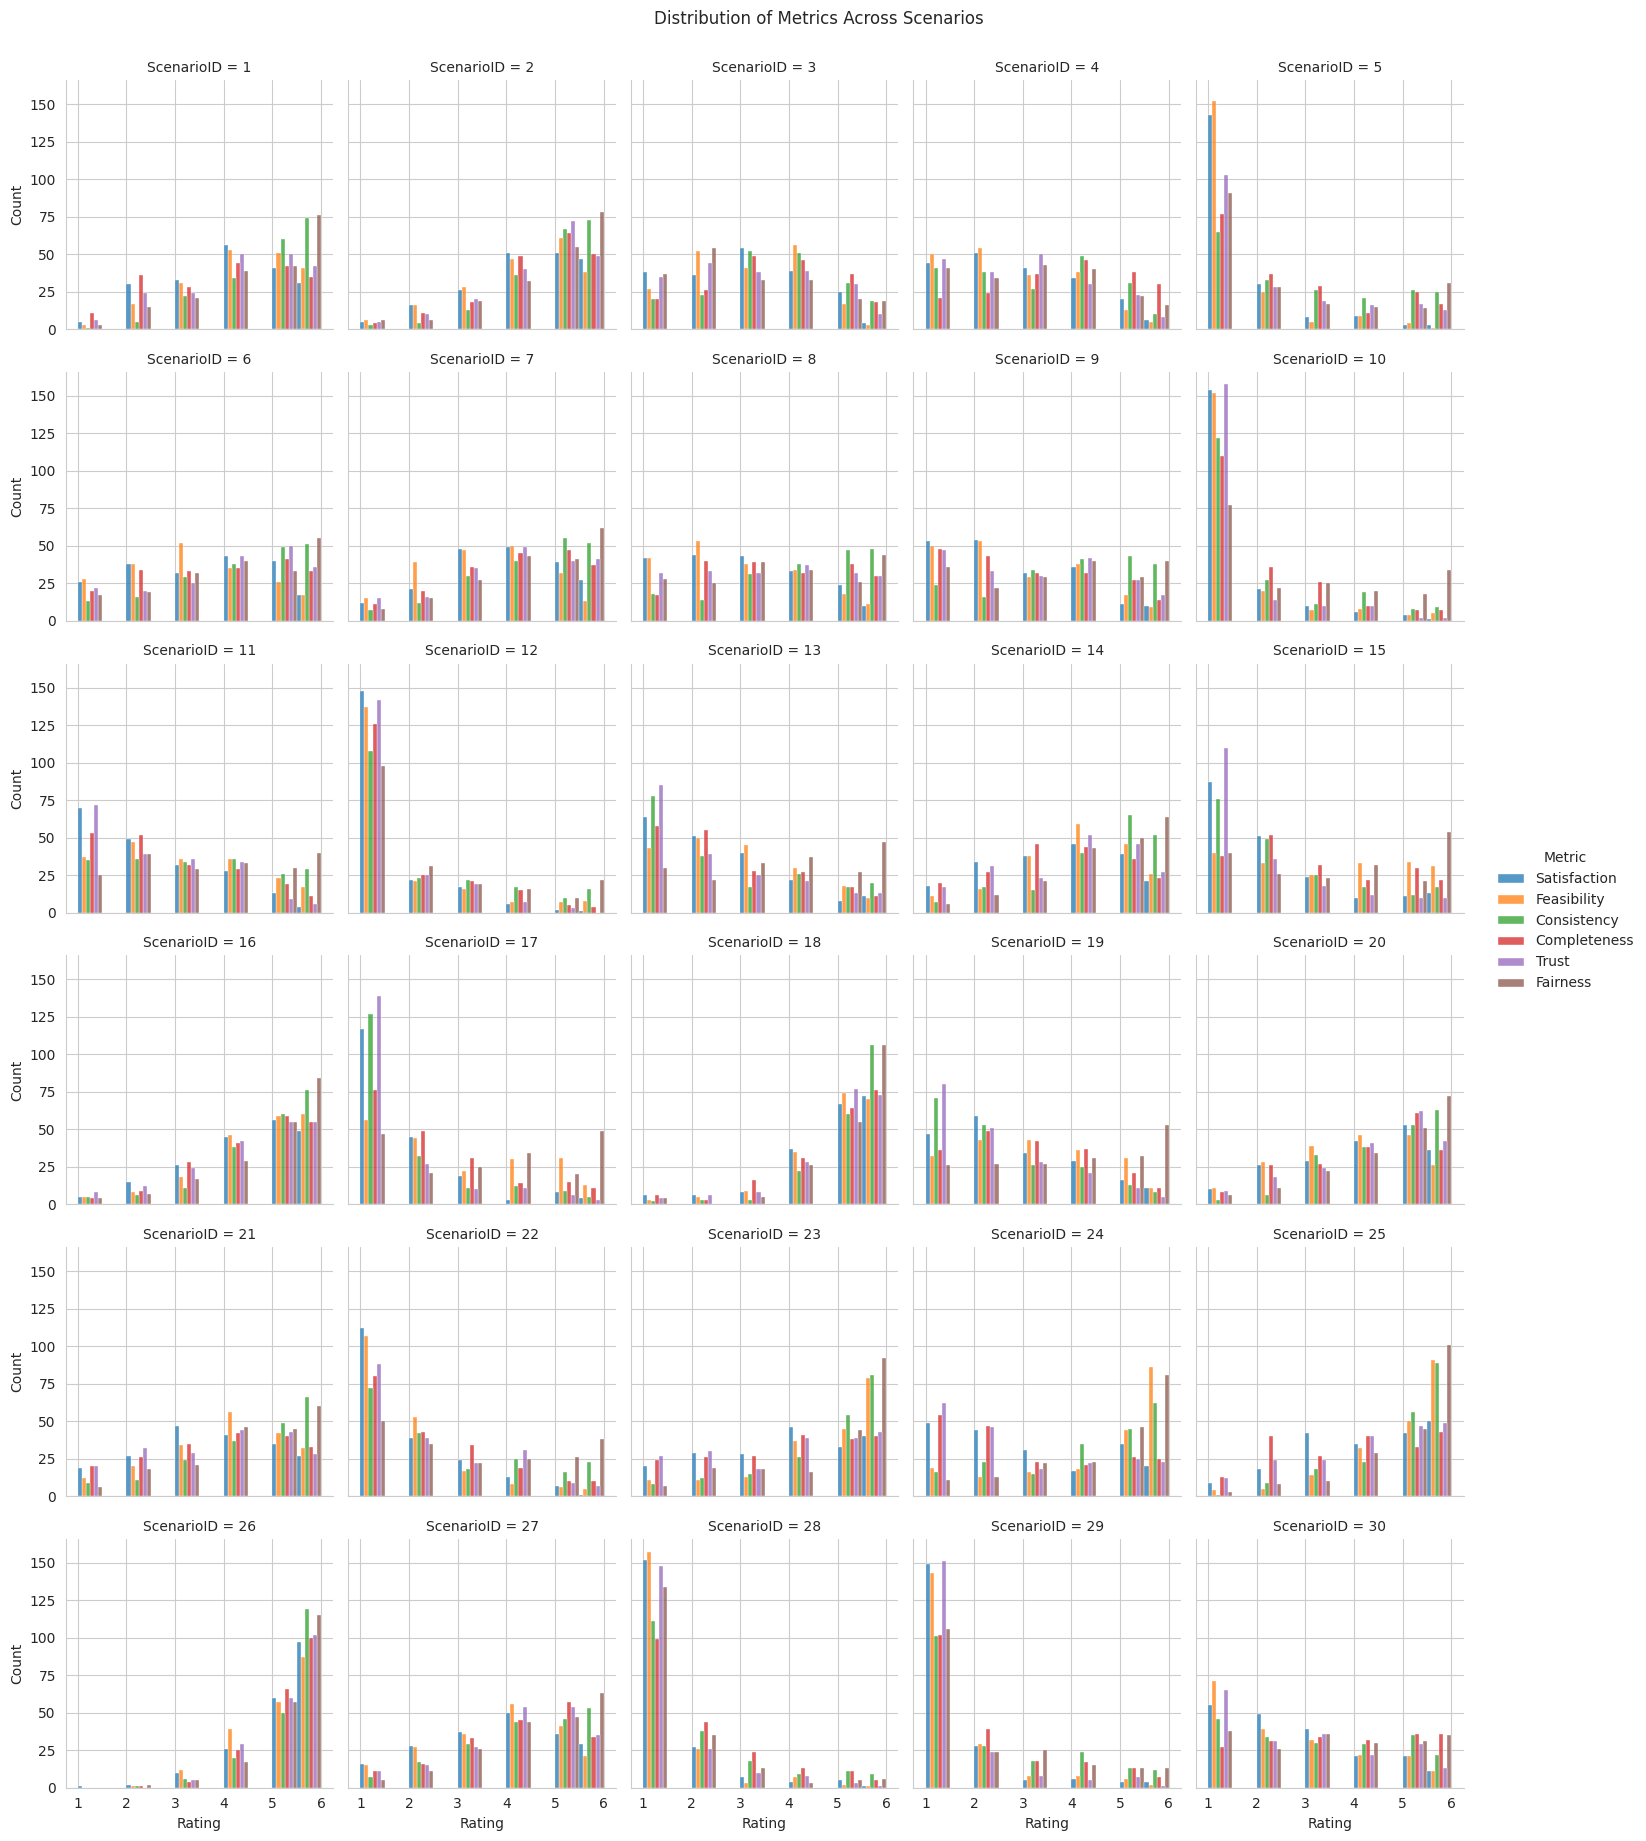

In [29]:
# prompt: make FacetGrid with all columns side by side

g = sns.displot(
    data=df_melt,
    x="Rating",
    hue="Metric",
    col="ScenarioID",
    col_wrap=5,    # 5 subplots per row
    kind="hist",   # histogram
    bins=10,
    kde=False,
    multiple="dodge",  # side-by-side bars
    height=3
)

g.fig.suptitle("Distribution of Metrics Across Scenarios", y=1.02)
plt.show()
g.fig.savefig("distribution_satisfaction_complexity.png", dpi=300, bbox_inches="tight")


In [30]:
# prompt: save the figure above to file

plt.savefig('satisfaction_distribution.png')


<Figure size 640x480 with 0 Axes>

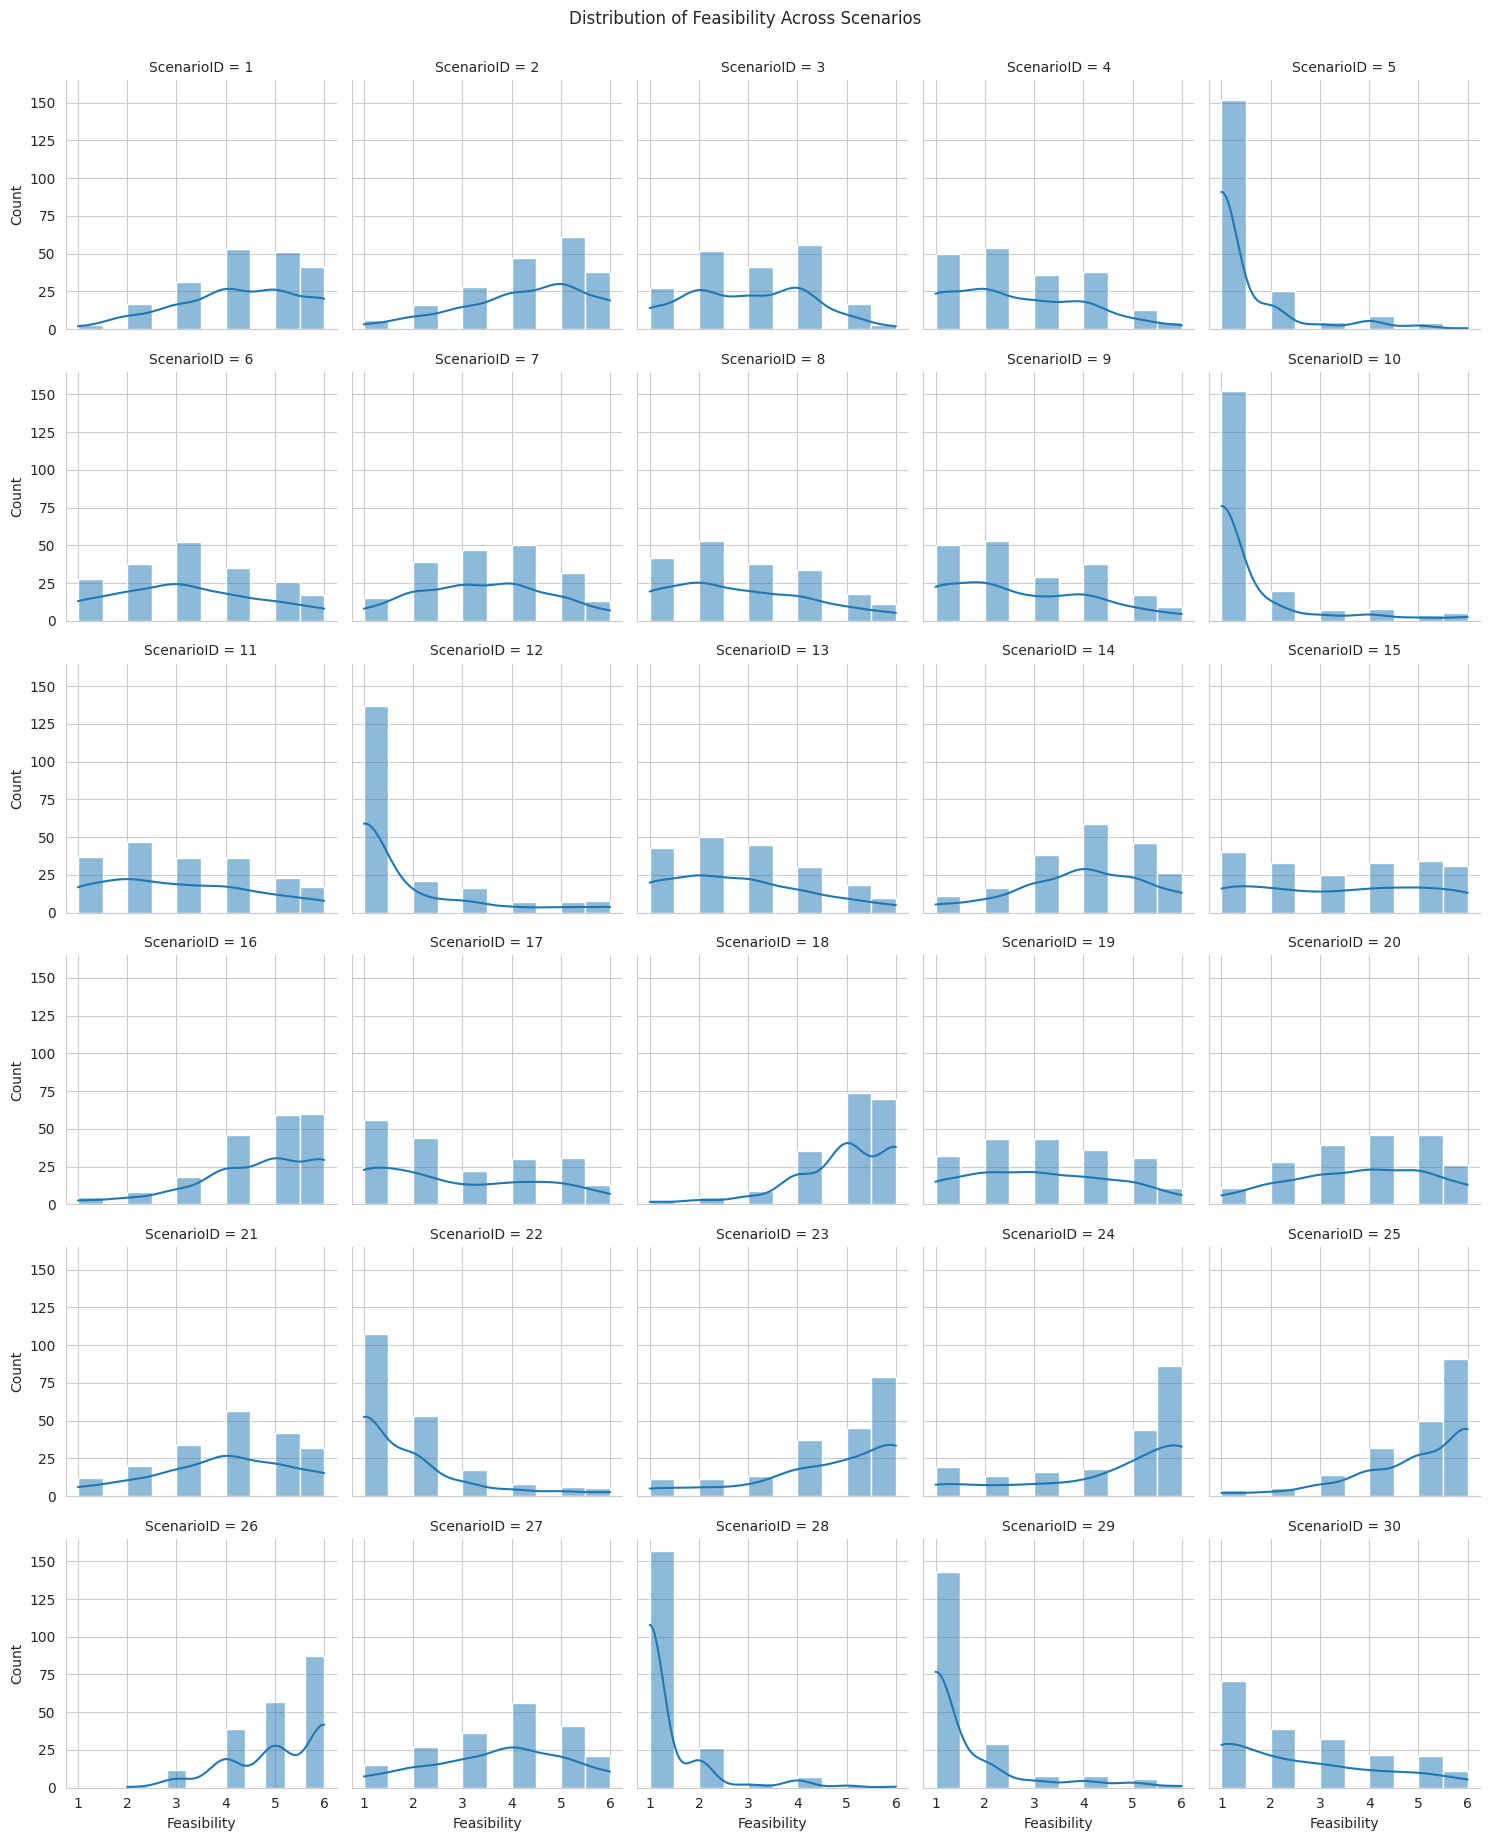

In [31]:
g = sns.FacetGrid(df_long, col="ScenarioID", col_wrap=5, height=3)
g.map(sns.histplot, "Feasibility", bins=10, kde=True)
plt.suptitle("Distribution of Feasibility Across Scenarios", y=1.02)
plt.show()

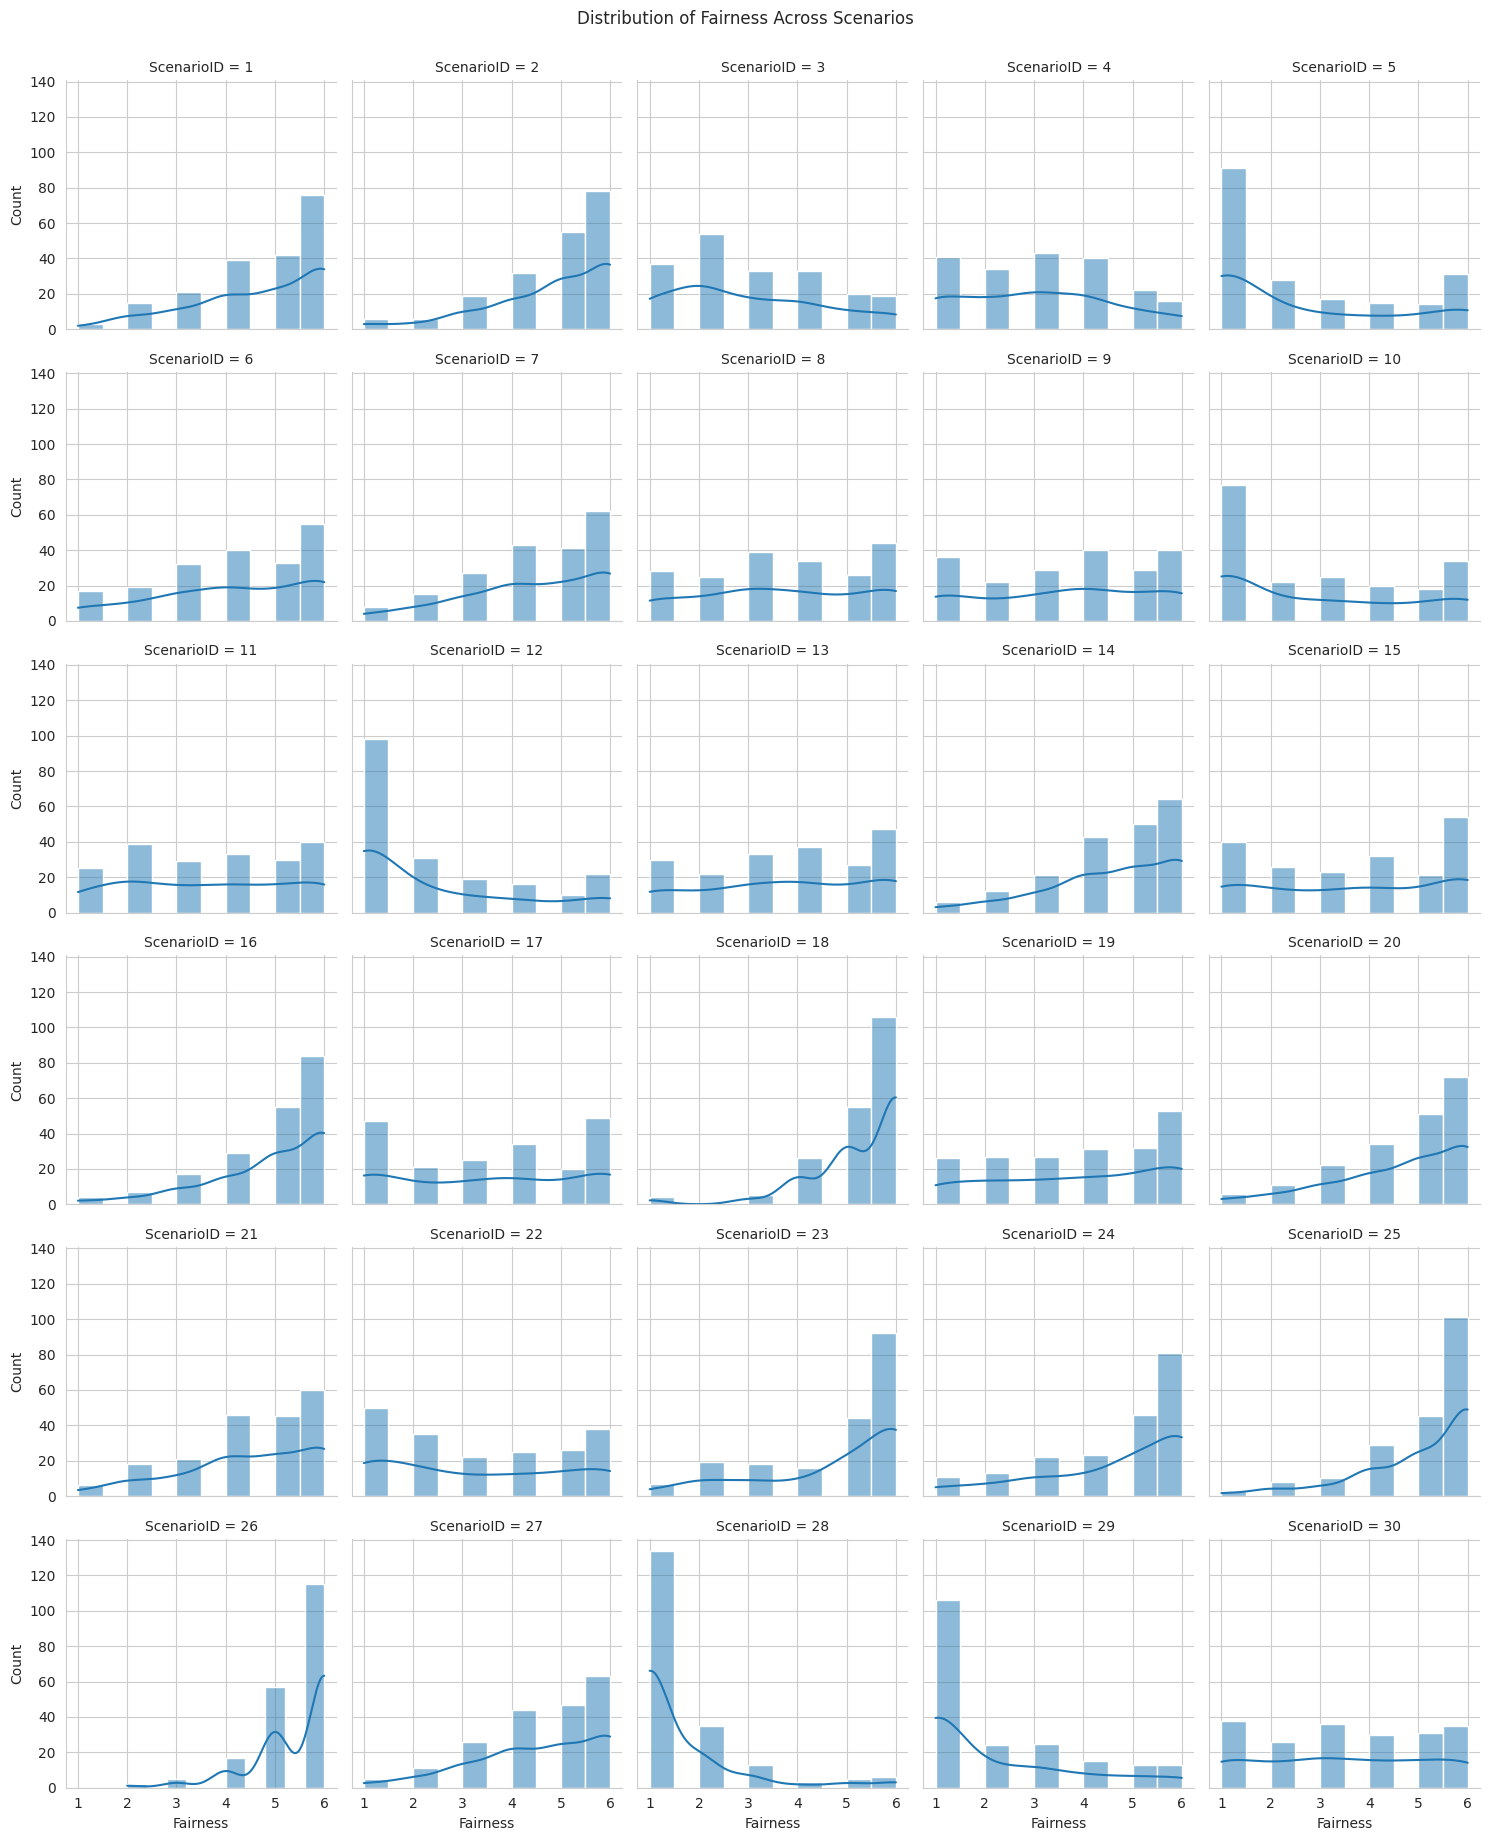

In [32]:
g = sns.FacetGrid(df_long, col="ScenarioID", col_wrap=5, height=3)
g.map(sns.histplot, "Fairness", bins=10, kde=True)
plt.suptitle("Distribution of Fairness Across Scenarios", y=1.02)
plt.show()

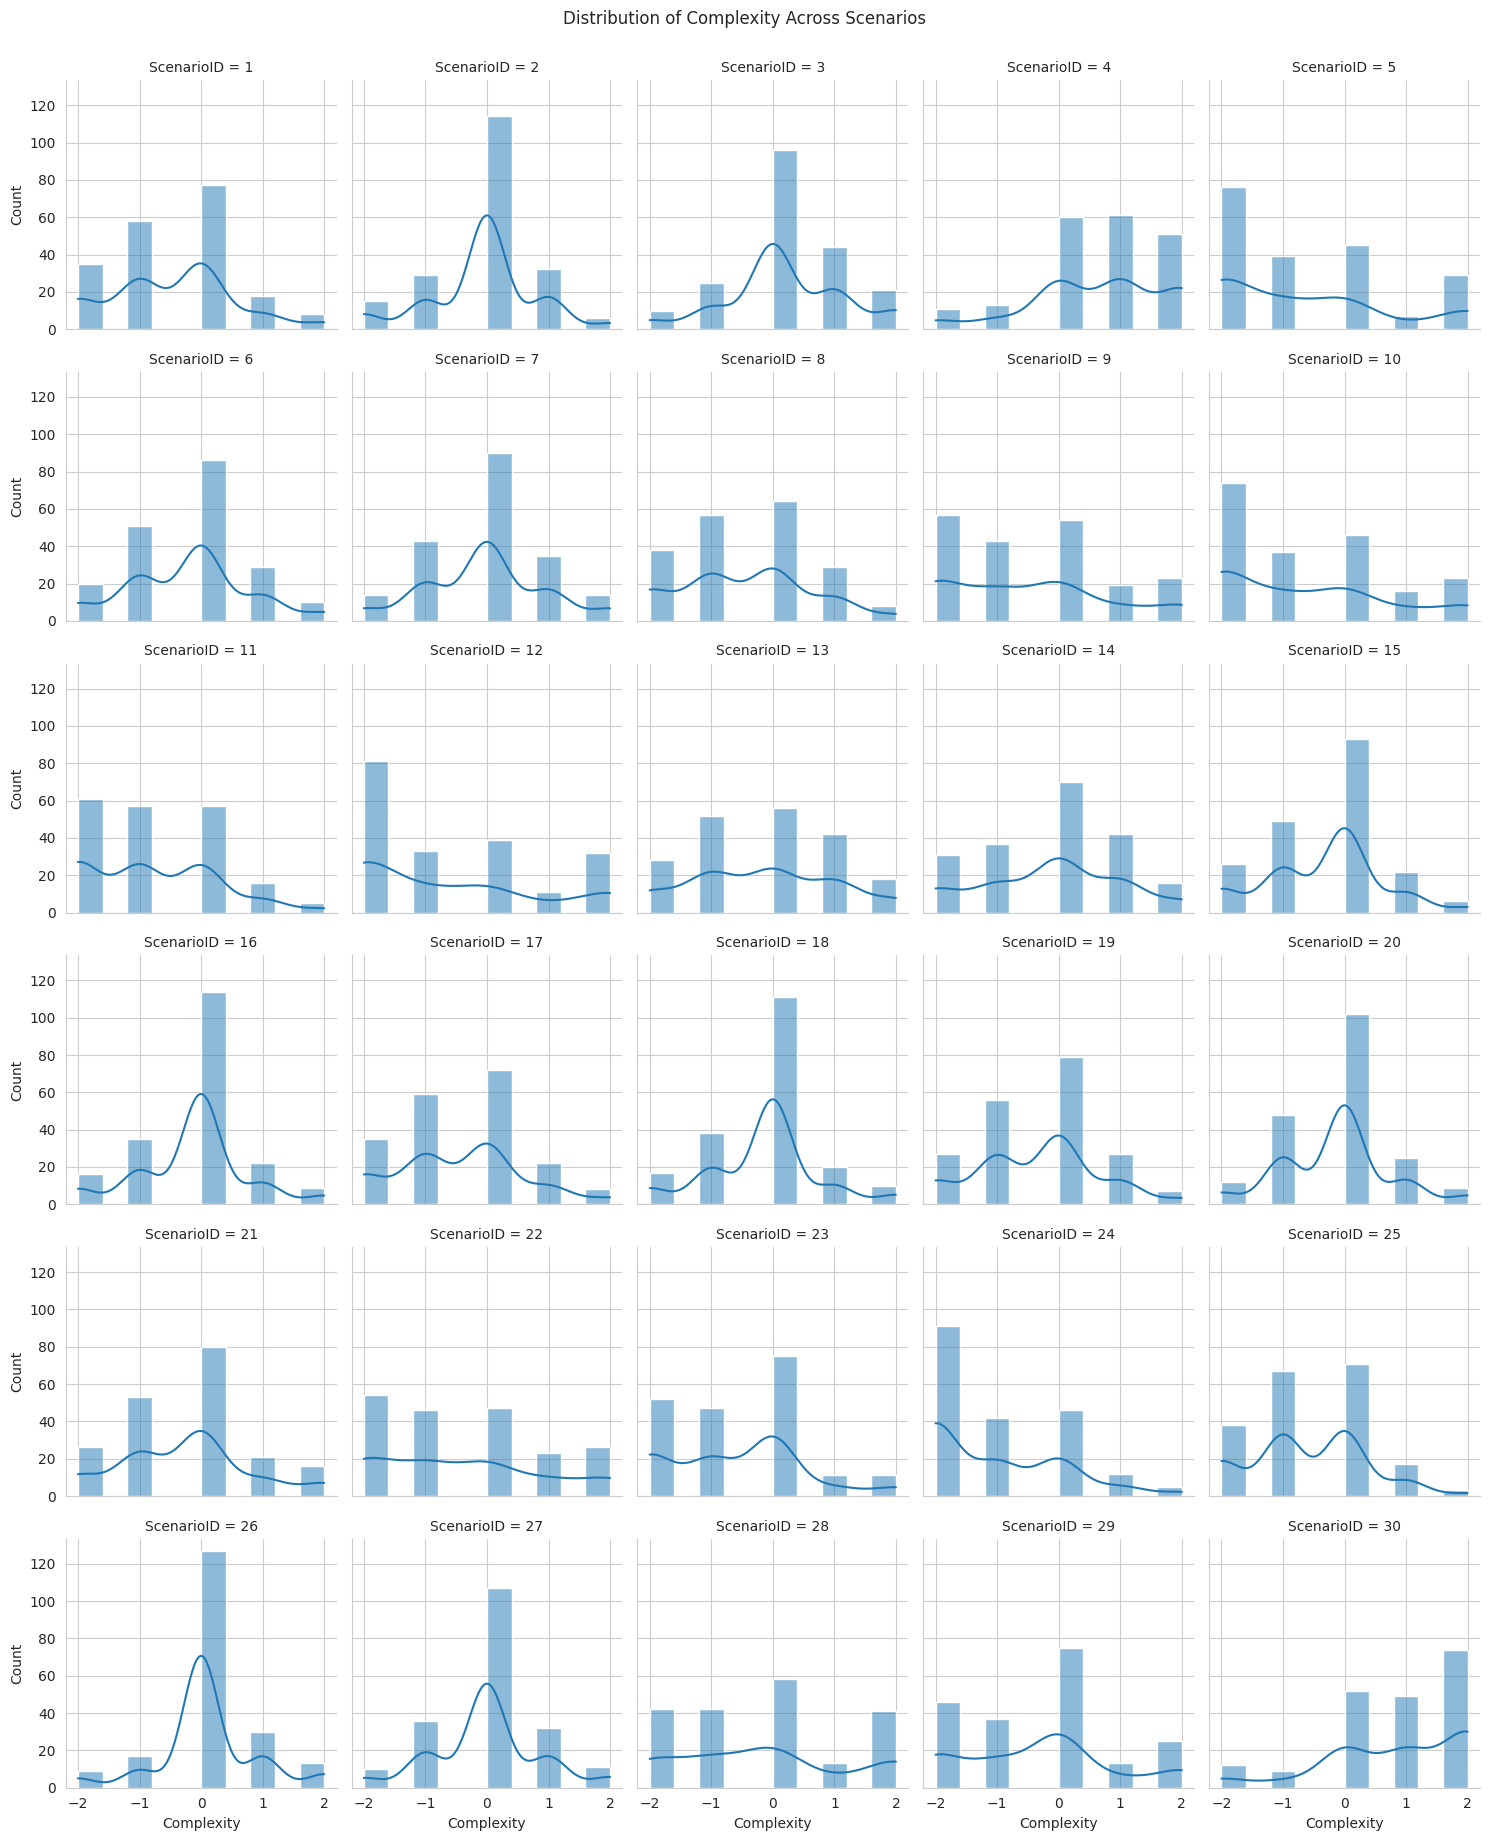

In [33]:
g = sns.FacetGrid(df_long, col="ScenarioID", col_wrap=5, height=3)
g.map(sns.histplot, "Complexity", bins=10, kde=True)
plt.suptitle("Distribution of Complexity Across Scenarios", y=1.02)
plt.show()

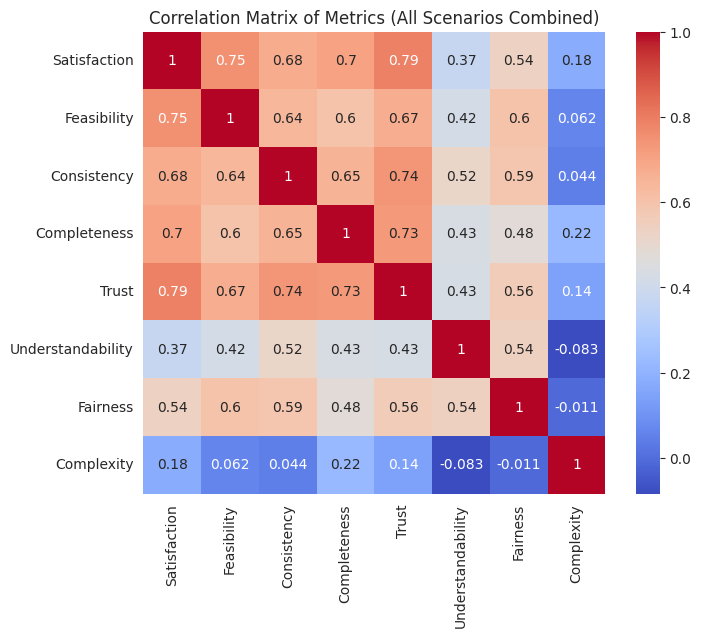

In [34]:
metrics_cols = [
    "Satisfaction", "Feasibility", "Consistency", "Completeness",
    "Trust", "Understandability", "Fairness", "Complexity"
]

corr_matrix = df_long[metrics_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Metrics (All Scenarios Combined)")
plt.show()

In [35]:
import statsmodels.api as sm

X = df_long[[
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity"
]]
y = df_long["Satisfaction"]

# Add intercept
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Satisfaction   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     2369.
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:29:18   Log-Likelihood:                -7645.5
No. Observations:                5880   AIC:                         1.531e+04
Df Residuals:                    5872   BIC:                         1.536e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1766      0.04

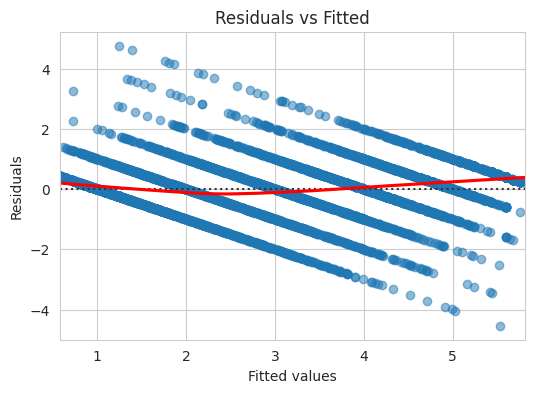

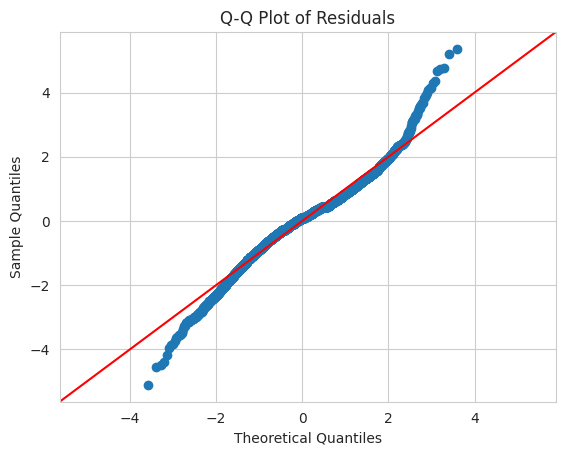

In [36]:
# Residuals vs Fitted
import numpy as np

plt.figure(figsize=(6,4))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True,
              scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Q-Q plot
fig = sm.qqplot(model.resid, line="45", fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

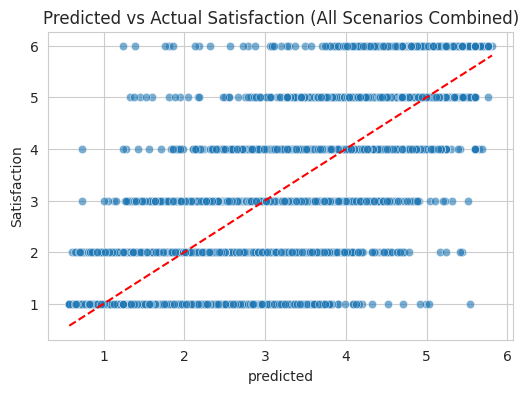

In [37]:
df_long["predicted"] = model.predict(X)
plt.figure(figsize=(6,4))
sns.scatterplot(x="predicted", y="Satisfaction", data=df_long, alpha=0.6)
plt.plot(
    [df_long["predicted"].min(), df_long["predicted"].max()],
    [df_long["predicted"].min(), df_long["predicted"].max()],
    color="red", linestyle="--"
)
plt.title("Predicted vs Actual Satisfaction (All Scenarios Combined)")
plt.show()

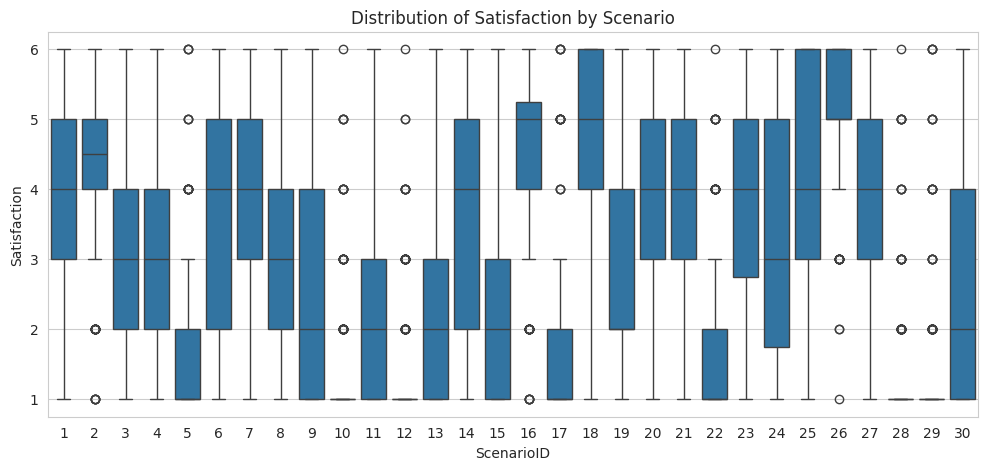

In [38]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="ScenarioID", y="Satisfaction", data=df_long)
plt.title("Distribution of Satisfaction by Scenario")
plt.show()

In [39]:
scenario_stats = df_long.groupby("ScenarioID")[metrics_cols].agg(["mean","std"])
print(scenario_stats)

           Satisfaction           Feasibility           Consistency            \
                   mean       std        mean       std        mean       std   
ScenarioID                                                                      
1              3.974490  1.364142    4.301020  1.287494    4.882653  1.141975   
2              4.367347  1.335033    4.301020  1.322856    4.933673  1.118923   
3              2.943878  1.363221    2.964286  1.262375    3.545918  1.415277   
4              2.760204  1.402799    2.617347  1.359300    3.107143  1.540479   
5              1.510204  1.049981    1.423469  0.960374    2.923469  1.814263   
6              3.428571  1.539231    3.224490  1.488628    4.260204  1.518653   
7              3.831633  1.398614    3.428571  1.354953    4.428571  1.373747   
8              2.913265  1.484148    2.826531  1.467777    4.153061  1.574489   
9              2.632653  1.449228    2.724490  1.476521    3.903061  1.612703   
10             1.408163  0.9

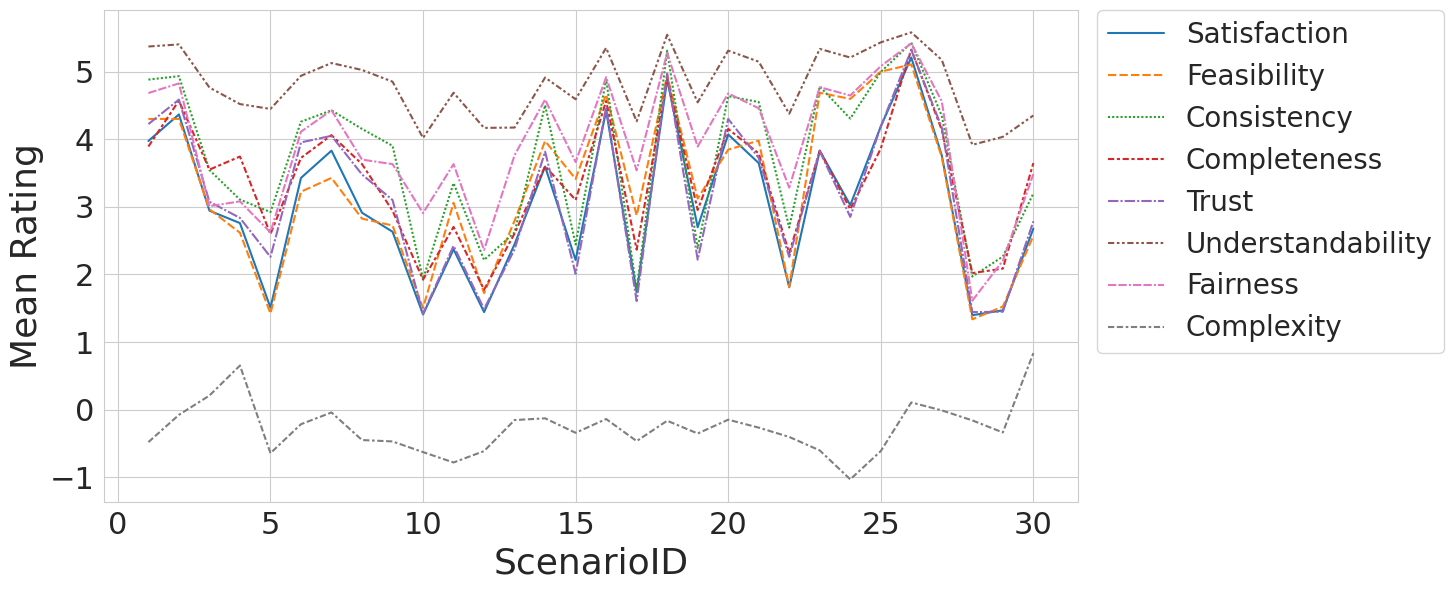

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

scenario_means = scenario_stats.xs("mean", level=1, axis=1)
plt.figure(figsize=(16,6))

ax = sns.lineplot(data=scenario_means)

ax.set_xlabel("ScenarioID", fontsize=26)
ax.set_ylabel("Mean Rating", fontsize=26)
ax.tick_params(axis='both', labelsize=22)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=20)

# Try enabling constrained_layout or adjusting margins:
plt.tight_layout()
plt.subplots_adjust(left=0.15)  # ensures y-label and ticks are not cut off

plt.savefig("mean_metrics_by_scenario.png", dpi=300)
plt.show()

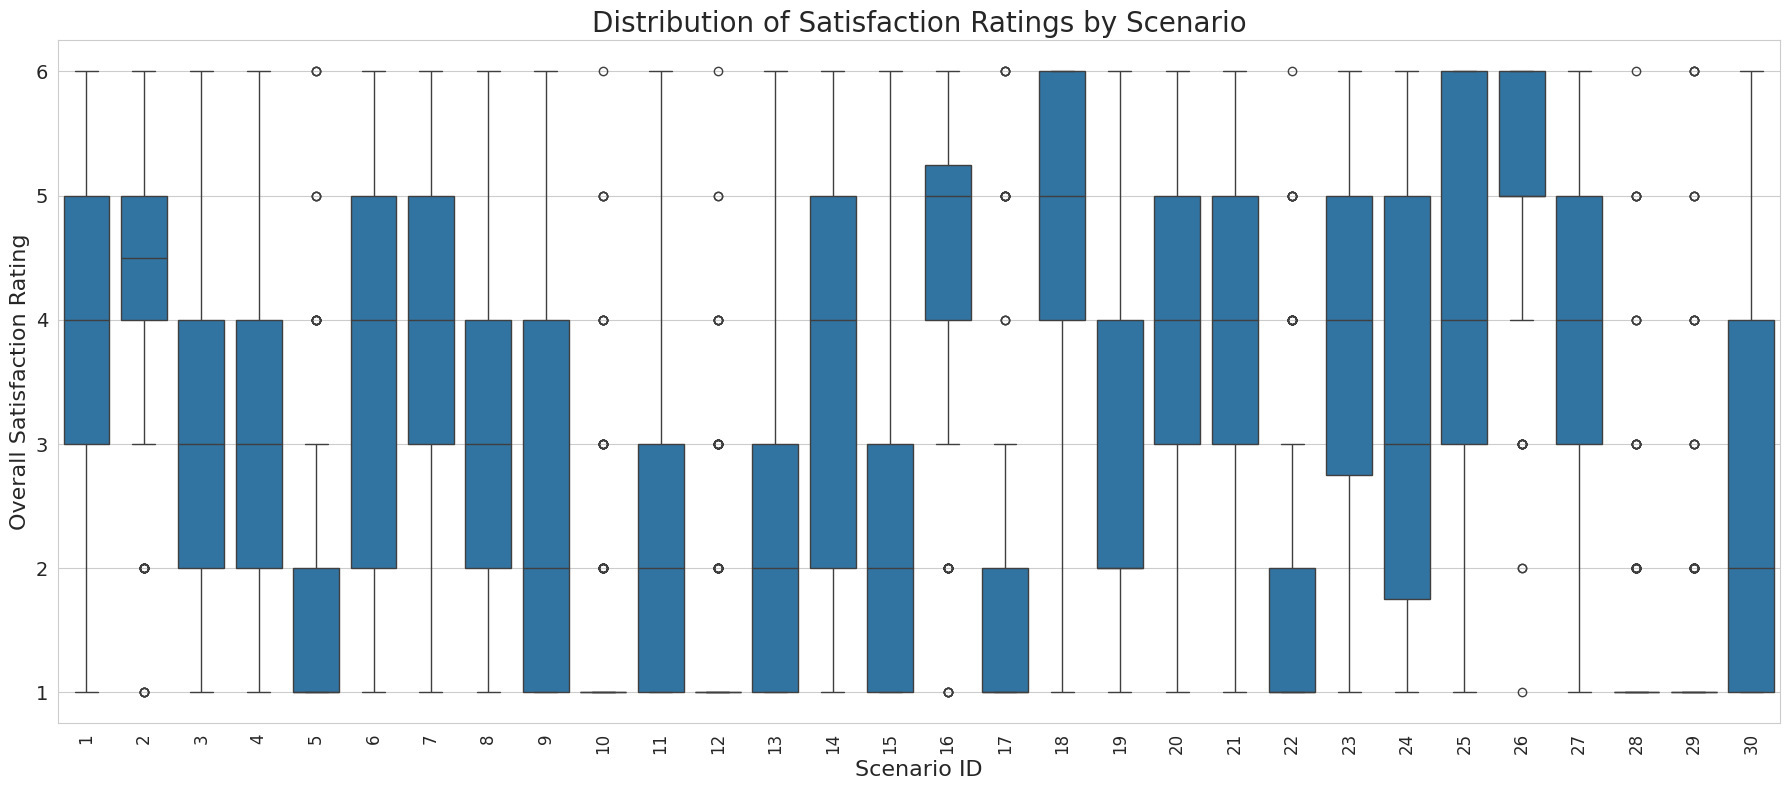

In [41]:
plt.figure(figsize=(18, 8))
sns.boxplot(data=df_long, x='ScenarioID', y='Satisfaction')

plt.xlabel("Scenario ID", fontsize=16)
plt.ylabel("Overall Satisfaction Rating", fontsize=16)
plt.title("Distribution of Satisfaction Ratings by Scenario", fontsize=20)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

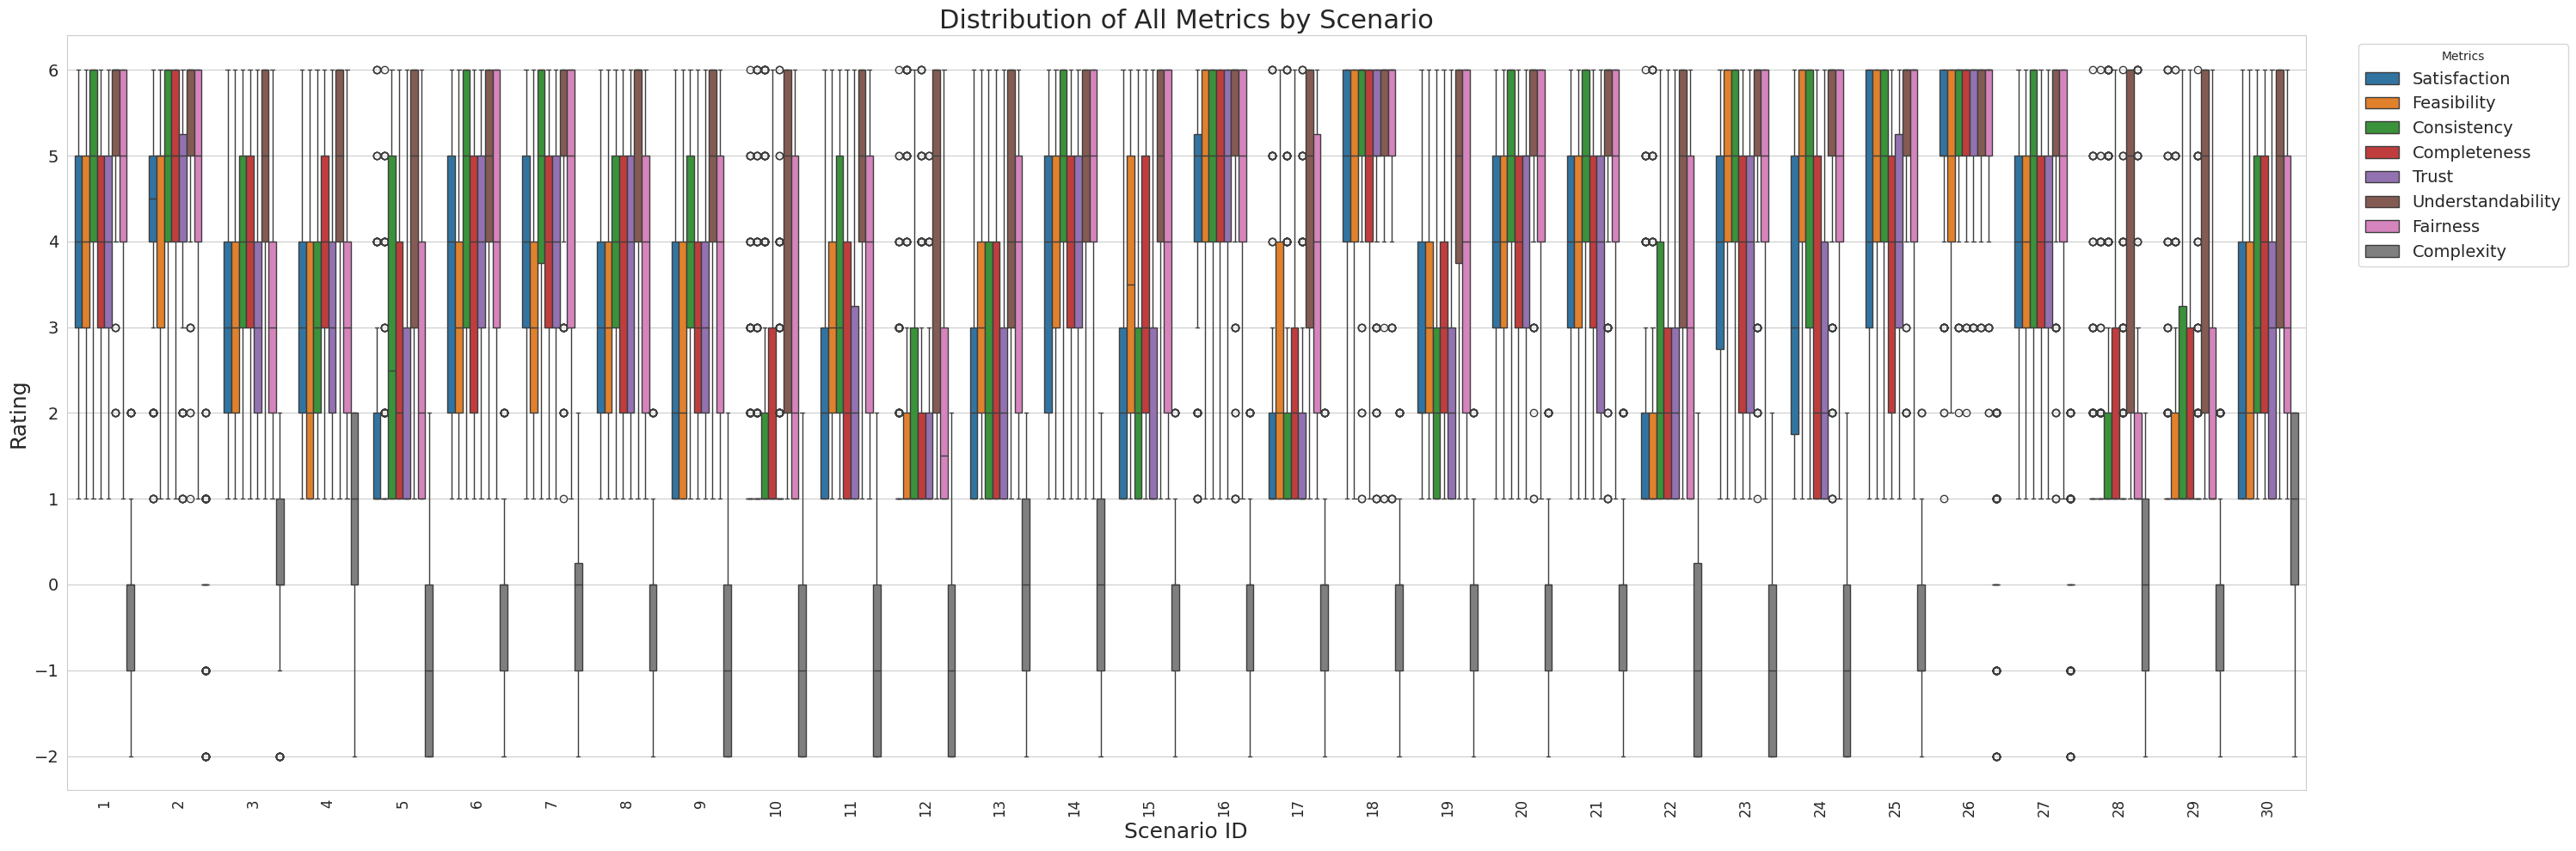

In [42]:
# Visualizing all metrics per scenario with fixed colors for clarity
plt.figure(figsize=(30, 10))

# Define fixed colors for each metric clearly
metric_colors = {
    "Satisfaction": "#1f77b4",
    "Feasibility": "#ff7f0e",
    "Consistency": "#2ca02c",
    "Completeness": "#d62728",
    "Trust": "#9467bd",
    "Understandability": "#8c564b",
    "Fairness": "#e377c2",
    "Complexity": "#7f7f7f"
}

# Melt DataFrame to long format suitable for Seaborn plotting
df_melted = df_long.melt(id_vars=['ScenarioID'], value_vars=metrics_list,
                         var_name='Metric', value_name='Rating')

# Boxplot for all metrics
sns.boxplot(data=df_melted, x='ScenarioID', y='Rating', hue='Metric', palette=metric_colors)

plt.xlabel("Scenario ID", fontsize=18)
plt.ylabel("Rating", fontsize=18)
plt.title("Distribution of All Metrics by Scenario", fontsize=22)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)

plt.legend(title='Metrics', fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

plt.show()

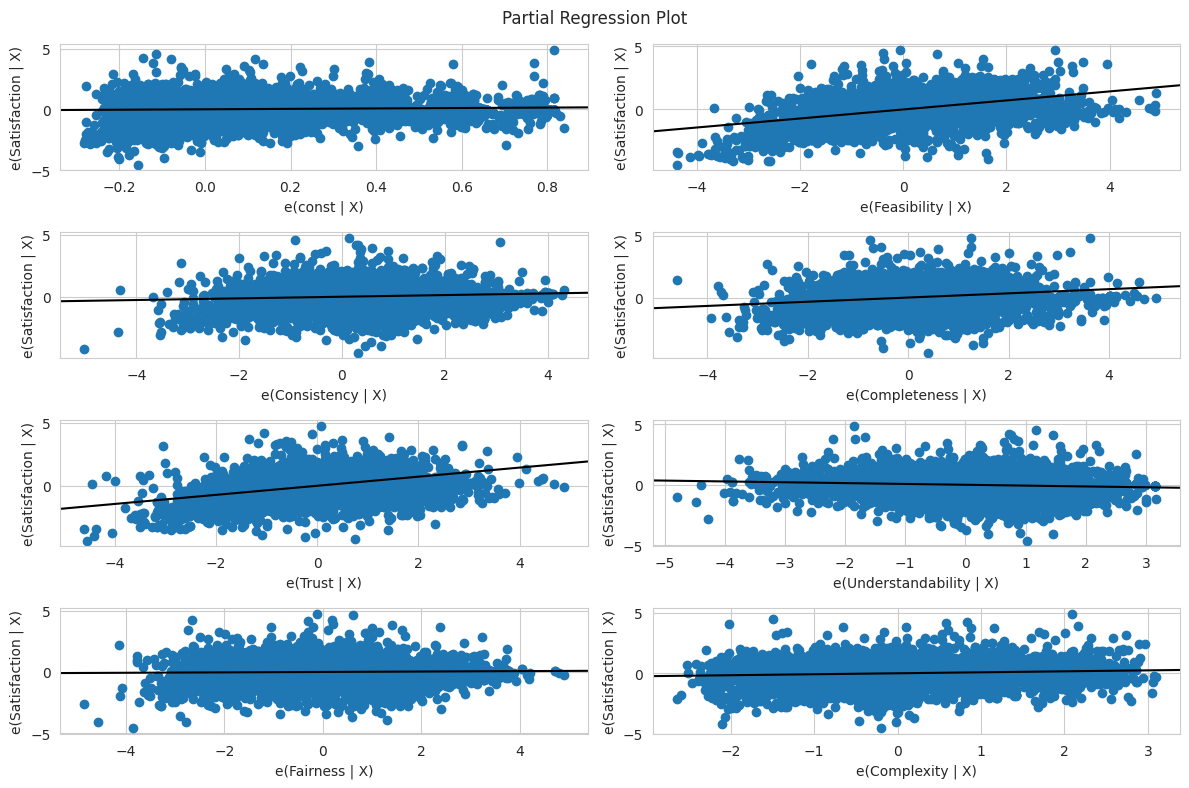

In [43]:
from statsmodels.graphics.regressionplots import plot_partregress_grid

fig = plt.figure(figsize=(12, 8))
plot_partregress_grid(model, fig=fig)  # model from above
plt.tight_layout()
plt.show()

In [44]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

X_sklearn = df_long[[
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity"
]]
y_sklearn = df_long["Satisfaction"]

linreg = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = cross_val_score(linreg, X_sklearn, y_sklearn,
                             scoring="neg_mean_squared_error", cv=kf)
r2_scores = cross_val_score(linreg, X_sklearn, y_sklearn,
                            scoring="r2", cv=kf)

rmse_scores = np.sqrt(-mse_scores)
print("Cross-validated RMSE:", rmse_scores)
print("Mean ± Std RMSE:", f"{rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
print("Cross-validated R²:", r2_scores)
print("Mean ± Std R²:", f"{r2_scores.mean():.3f} ± {r2_scores.std():.3f}")

Cross-validated RMSE: [0.90177662 0.8635175  0.89170226 0.91337298 0.87837499]
Mean ± Std RMSE: 0.890 ± 0.017
Cross-validated R²: [0.72550634 0.74654894 0.75020223 0.71725827 0.74604071]
Mean ± Std R²: 0.737 ± 0.013


Linear Regression

In [45]:
# Example: Ensure these columns are numeric
import pandas as pd
df_long["Satisfaction"] = pd.to_numeric(df_long["Satisfaction"], errors="coerce")
df_long["Feasibility"]  = pd.to_numeric(df_long["Feasibility"], errors="coerce")
# etc. for the remaining columns

# Drop any rows with NaNs in these columns
df_long.dropna(subset=[
    "Satisfaction", "Feasibility", "Consistency",
    "Completeness", "Trust", "Understandability",
    "Fairness", "Complexity"
], inplace=True)

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df_long[[
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity"
]]
y = df_long["Satisfaction"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_pred_lr = linreg.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr  = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression Results:")
print(f"  RMSE: {rmse_lr:.3f}")
print(f"  R²:   {r2_lr:.3f}")
print("Coefficients:")
for name, coef in zip(X.columns, linreg.coef_):
    print(f"   {name}: {coef:.3f}")

Linear Regression Results:
  RMSE: 0.902
  R²:   0.726
Coefficients:
   Feasibility: 0.368
   Consistency: 0.062
   Completeness: 0.174
   Trust: 0.359
   Understandability: -0.073
   Fairness: 0.012
   Complexity: 0.078


In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_reg.fit(X_train, y_train)

y_pred_tree = tree_reg.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree  = r2_score(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)

print("\nDecision Tree Results:")
print(f"  RMSE: {rmse_tree:.3f}")
print(f"  R²:   {r2_tree:.3f}")


Decision Tree Results:
  RMSE: 0.875
  R²:   0.741


In [49]:
importances = tree_reg.feature_importances_
for name, imp in sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.3f}")

Trust: 0.753
Feasibility: 0.206
Completeness: 0.031
Complexity: 0.004
Fairness: 0.003
Understandability: 0.002
Consistency: 0.002


In [50]:
importances = tree_reg.feature_importances_
for name, imp in sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.3f}")

Trust: 0.753
Feasibility: 0.206
Completeness: 0.031
Complexity: 0.004
Fairness: 0.003
Understandability: 0.002
Consistency: 0.002


In [51]:
print("==== Model Comparison ====")
print(f"Linear Regression -> RMSE: {rmse_lr:.3f}, R²: {r2_lr:.3f}")
print(f"Decision Tree     -> RMSE: {rmse_tree:.3f}, R²: {r2_tree:.3f}")

==== Model Comparison ====
Linear Regression -> RMSE: 0.902, R²: 0.726
Decision Tree     -> RMSE: 0.875, R²: 0.741


In [52]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression CV
linreg_cv = LinearRegression()
mse_scores_lr = cross_val_score(linreg_cv, X, y,
                                scoring="neg_mean_squared_error", cv=kf)
r2_scores_lr  = cross_val_score(linreg_cv, X, y,
                                scoring="r2", cv=kf)

rmse_scores_lr = np.sqrt(-mse_scores_lr)
print("Linear Regression (5-fold CV):")
print(f"  RMSE: {rmse_scores_lr.mean():.3f} ± {rmse_scores_lr.std():.3f}")
print(f"  R²:   {r2_scores_lr.mean():.3f} ± {r2_scores_lr.std():.3f}")

# Decision Tree CV
tree_reg_cv = DecisionTreeRegressor(max_depth=5, random_state=42)
mse_scores_tree = cross_val_score(tree_reg_cv, X, y,
                                  scoring="neg_mean_squared_error", cv=kf)
r2_scores_tree  = cross_val_score(tree_reg_cv, X, y,
                                  scoring="r2", cv=kf)

rmse_scores_tree = np.sqrt(-mse_scores_tree)
print("\nDecision Tree (5-fold CV):")
print(f"  RMSE: {rmse_scores_tree.mean():.3f} ± {rmse_scores_tree.std():.3f}")
print(f"  R²:   {r2_scores_tree.mean():.3f} ± {r2_scores_tree.std():.3f}")

Linear Regression (5-fold CV):
  RMSE: 0.890 ± 0.017
  R²:   0.737 ± 0.013

Decision Tree (5-fold CV):
  RMSE: 0.859 ± 0.030
  R²:   0.755 ± 0.016


In [53]:
# prompt: print coefficients of rmse_scores_lr

print("Coefficients of rmse_scores_lr:")
rmse_scores_lr


Coefficients of rmse_scores_lr:


array([0.90177662, 0.8635175 , 0.89170226, 0.91337298, 0.87837499])

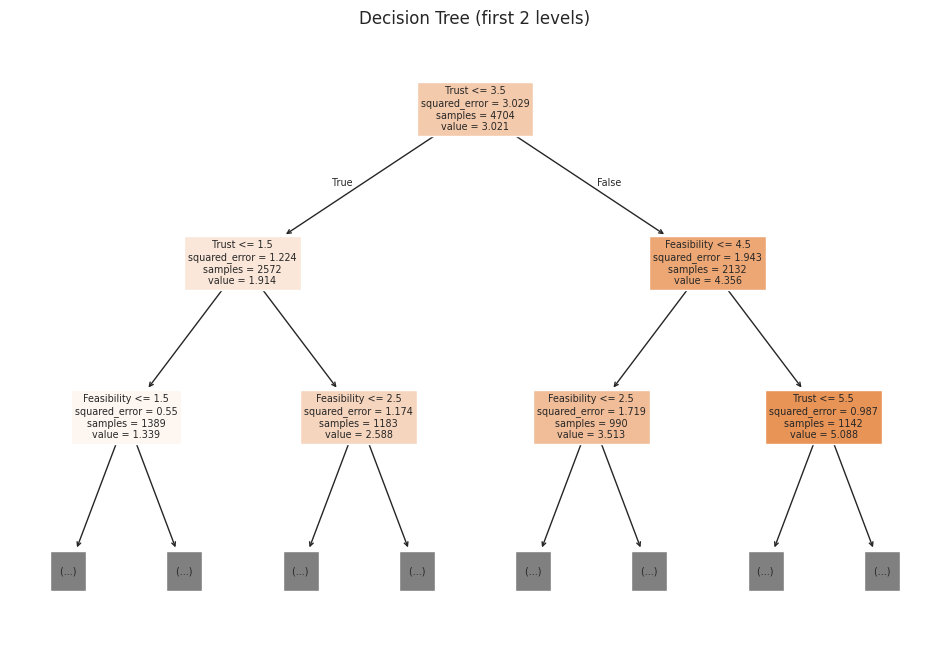

In [54]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plot_tree(tree_reg, feature_names=X.columns, filled=True, max_depth=2)
plt.title("Decision Tree (first 2 levels)")
plt.show()

In [55]:
# prompt: train randomforestregressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Regressor CV
rf_reg_cv = RandomForestRegressor(n_estimators=100, random_state=42)
mse_scores_rf = cross_val_score(rf_reg_cv, X, y,
                                scoring="neg_mean_squared_error", cv=kf)
r2_scores_rf  = cross_val_score(rf_reg_cv, X, y,
                                scoring="r2", cv=kf)

rmse_scores_rf = np.sqrt(-mse_scores_rf)
print("Random Forest (5-fold CV):")
print(f"  RMSE: {rmse_scores_rf.mean():.3f} ± {rmse_scores_rf.std():.3f}")
print(f"  R²:   {r2_scores_rf.mean():.3f} ± {r2_scores_rf.std():.3f}")


Random Forest (5-fold CV):
  RMSE: 0.888 ± 0.020
  R²:   0.738 ± 0.015


In [56]:
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Fit RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# SHAP Explainer
explainer_rf = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer_rf(X_test)



 99%|===================| 1164/1176 [01:03<00:00]       

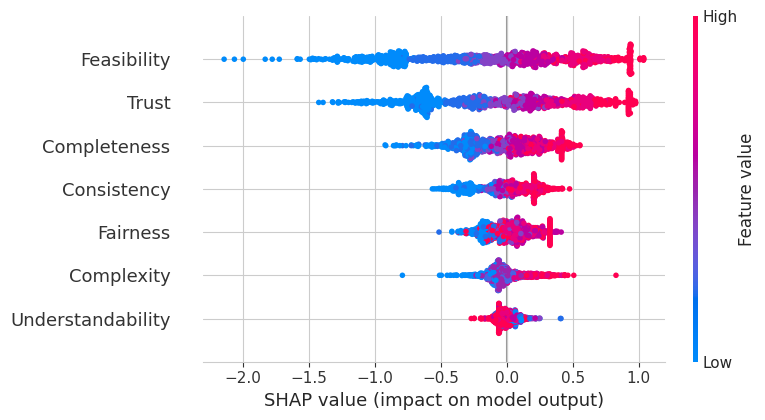

In [61]:
# SHAP summary plot (Global feature importance)
shap.summary_plot(shap_values_rf, X_test, show=False)
#save plot to file
plt.savefig("shap_summary_plot.png", bbox_inches='tight')
plt.show()

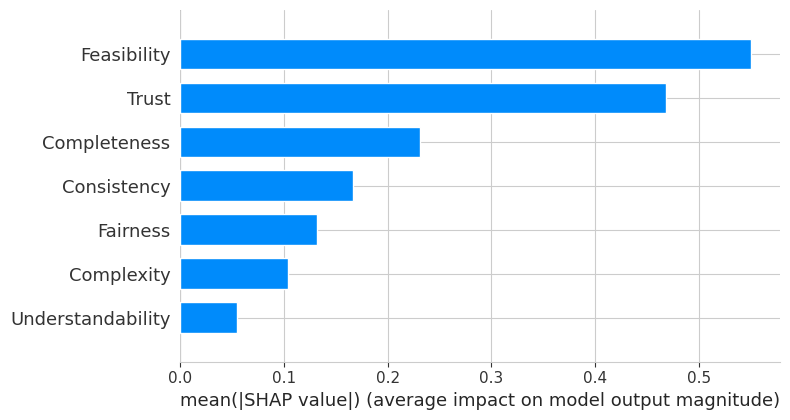

In [62]:
# SHAP bar plot (Average global feature impact)
shap.summary_plot(shap_values_rf, X_test, plot_type='bar', show=False)
plt.savefig("shap_bar_plot.png", bbox_inches='tight')
plt.show()

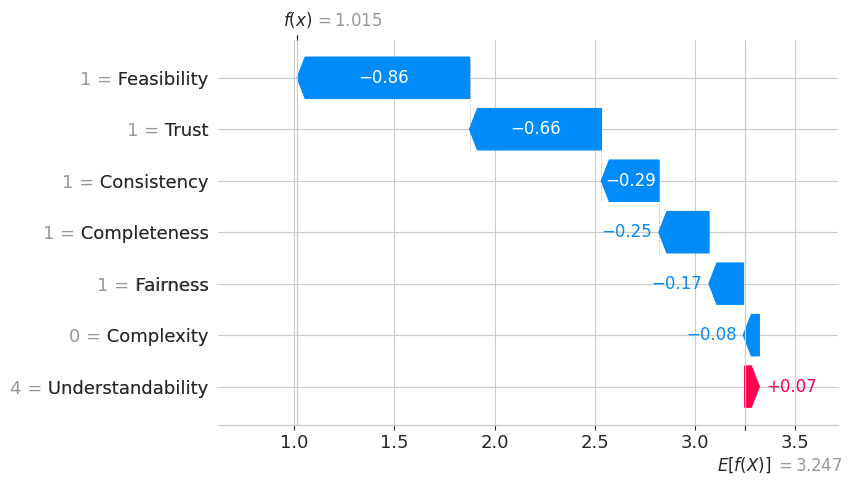

In [63]:
# Individual-level SHAP explanations (example)
shap.plots.waterfall(shap_values_rf[0], show=False)
plt.savefig("shap_waterfall_plot.png", bbox_inches='tight')
plt.show()

Let's do classification

In [64]:
def satisfaction_to_label(x):
    if x in [1, 2]:
        return "low"
    elif x in [3, 4]:
        return "medium"
    elif x in [5, 6]:
        return "high"
    else:
        return None  # or np.nan, for safety

df_long["Satisfaction_cat"] = df_long["Satisfaction"].apply(satisfaction_to_label)

In [65]:
counts = df_long["Satisfaction_cat"].value_counts(dropna=False)
print("Class distribution:\n", counts)
print("\nProportions:\n", (counts / counts.sum()).round(3))

Class distribution:
 Satisfaction_cat
low       2666
medium    1747
high      1467
Name: count, dtype: int64

Proportions:
 Satisfaction_cat
low       0.453
medium    0.297
high      0.249
Name: count, dtype: float64


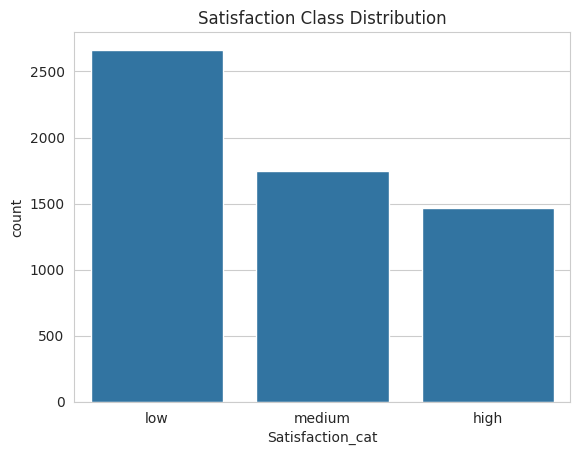

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_long, x="Satisfaction_cat", order=["low","medium","high"])
plt.title("Satisfaction Class Distribution")
plt.show()

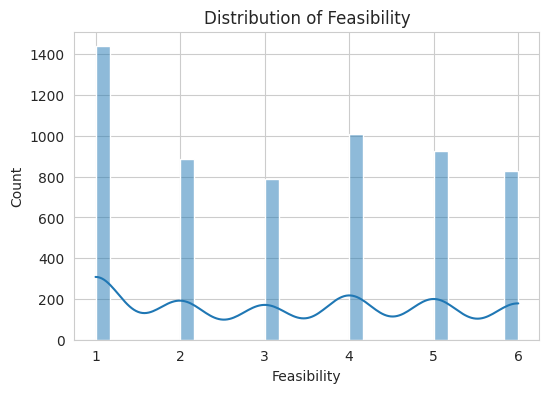

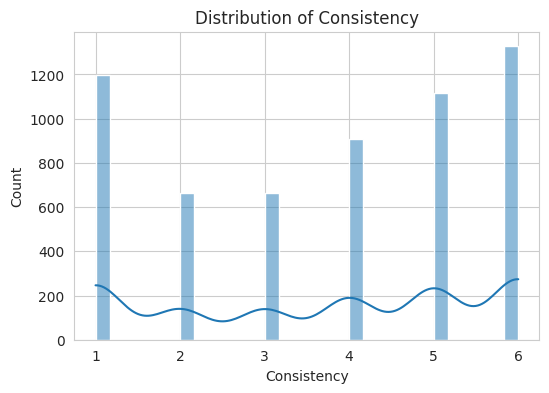

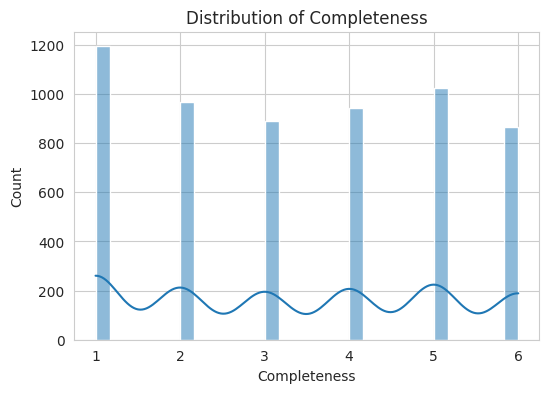

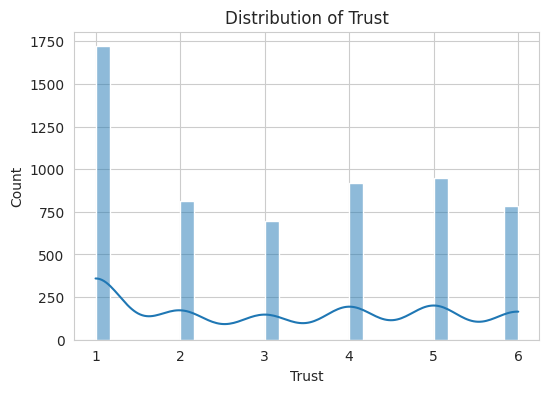

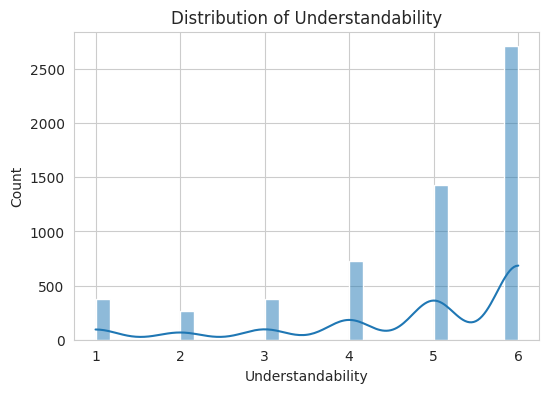

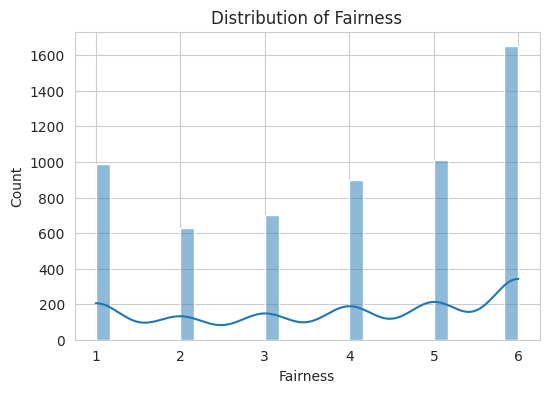

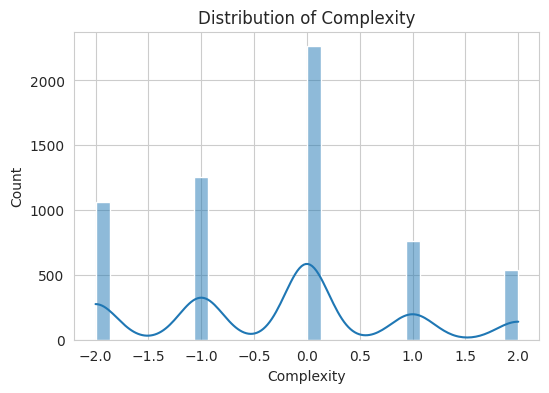

In [67]:
metrics = [
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity"
]

for m in metrics:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df_long, x=m, bins=30, kde=True)
    plt.title(f"Distribution of {m}")
    plt.show()

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define font sizes
label_fontsize = 40
title_fontsize = 26
legend_fontsize = 28
tick_fontsize = 28

metrics = ["Feasibility","Consistency","Completeness","Trust","Understandability","Fairness","Complexity", "Satisfaction"]

for m in metrics:
    plt.figure(figsize=(9, 6))
    ax = plt.gca()

    sns.histplot(
        data=df_long,
        x=m,
        hue="Satisfaction_cat",
        hue_order=["low", "medium", "high"],
        bins=30,
        kde=True,
        ax=ax
    )

    ax.set_xlabel(m, fontsize=label_fontsize)
    ax.set_ylabel("Density", fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)

    # Adjust legend title and label font sizes
    legend = ax.get_legend()
    if legend is not None:
        legend.set_title("Satisfaction")  # customize title
        plt.setp(legend.get_title(), fontsize=legend_fontsize)  # legend title size
        for text in legend.get_texts():
            text.set_fontsize(legend_fontsize)  # legend label size

    plt.tight_layout()
    plt.savefig(f"distribution_satisfaction_class_{m}.png")
    plt.close()

plt.show()

In [69]:
from sklearn.model_selection import train_test_split

X = df_long[[
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity"
]]
y = df_long["Satisfaction_cat"]

# Drop any rows where y might be NaN
df_long.dropna(subset=["Satisfaction_cat"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify helps keep class proportions
)

In [70]:
import pandas as pd
import numpy as np

# Scikit-learn classification models and evaluation tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression (Single Split) ===
Accuracy: 0.749
Classification Report:
              precision    recall  f1-score   support

        high      0.756     0.779     0.767       294
         low      0.820     0.856     0.837       533
      medium      0.618     0.562     0.589       349

    accuracy                          0.749      1176
   macro avg      0.731     0.732     0.731      1176
weighted avg      0.744     0.749     0.746      1176



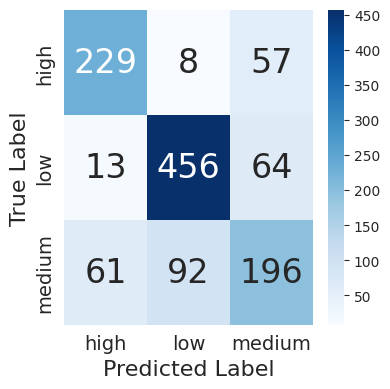


=== Decision Tree (Single Split) ===
Accuracy: 0.784
Classification Report:
              precision    recall  f1-score   support

        high      0.785     0.759     0.772       294
         low      0.885     0.852     0.868       533
      medium      0.646     0.702     0.673       349

    accuracy                          0.784      1176
   macro avg      0.772     0.771     0.771      1176
weighted avg      0.789     0.784     0.786      1176



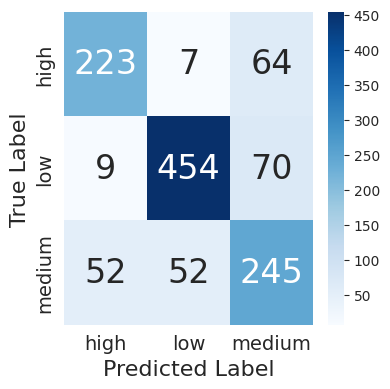


=== Random Forest (Single Split) ===
Accuracy: 0.761
Classification Report:
              precision    recall  f1-score   support

        high      0.751     0.738     0.744       294
         low      0.865     0.841     0.853       533
      medium      0.623     0.659     0.641       349

    accuracy                          0.761      1176
   macro avg      0.746     0.746     0.746      1176
weighted avg      0.765     0.761     0.763      1176



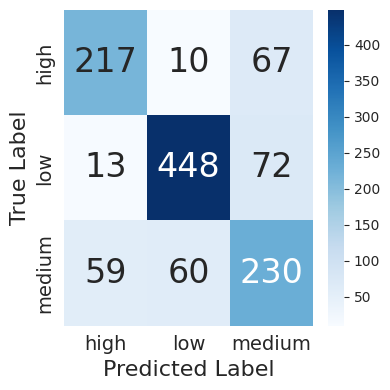

In [71]:
models = {
    "Logistic Regression": LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

results_single = []

for model_name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results_single.append((model_name, acc))

    print(f"\n=== {model_name} (Single Split) ===")
    print(f"Accuracy: {acc:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 24},
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.xlabel("Predicted Label", fontsize=16)
    plt.ylabel("True Label", fontsize=16)
    # Set te font size for the tick labels
    plt.tick_params(axis='x', labelsize=14)  # Adjust fontsize for x-axis tick labels
    plt.tick_params(axis='y', labelsize=14)  # Adjust fontsize for y-axis tick labelsh
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png", dpi=300)
    plt.show()

In [72]:
explainer_rf_cl = shap.Explainer(models["Random Forest"], X_train)
shap_values_rf_cl = explainer_rf_cl(X_test)

100%|===================| 3521/3528 [03:25<00:00]       

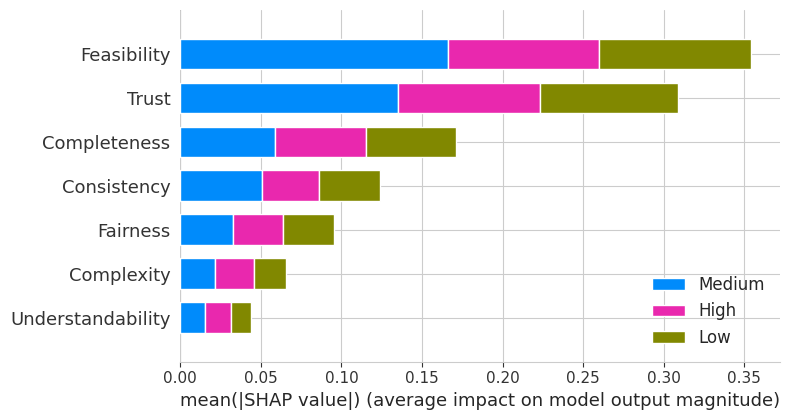

In [74]:
# SHAP summary plot (Global feature importance)
shap.summary_plot(shap_values_rf_cl, X_test, class_names=["Low", "Medium", "High"], show=False)
plt.savefig("shap_summary_plot_cl.png", bbox_inches='tight')
plt.show()

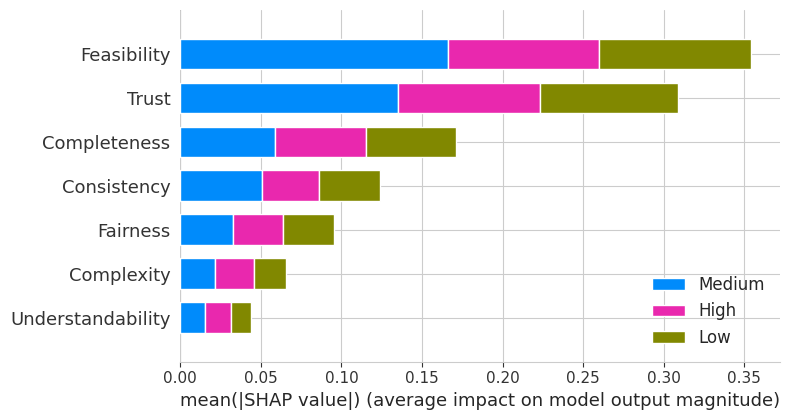

In [75]:
# SHAP bar plot (Average global feature impact)
shap.summary_plot(shap_values_rf_cl, X_test, class_names=["Low", "Medium", "High"], plot_type='bar', show=False)
plt.savefig("shap_bar_plot_cl.png", bbox_inches='tight')
plt.show()

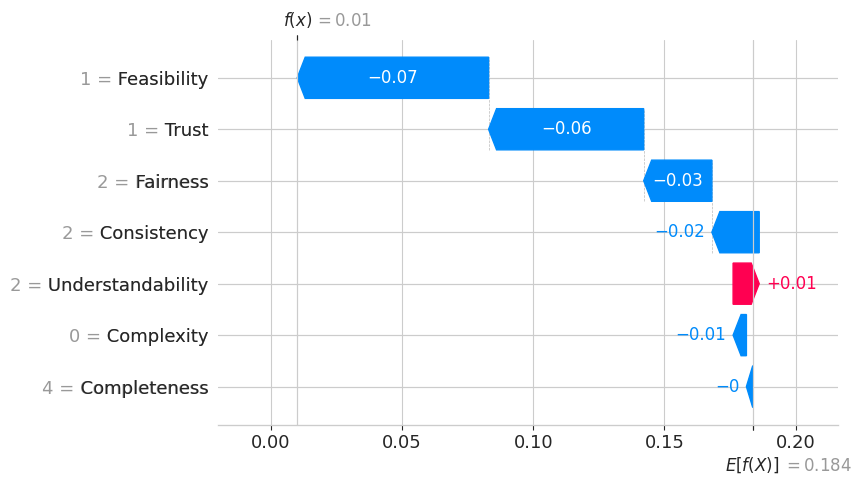

In [76]:
# Select the instance index (first instance as an example)
instance_idx = 0

# Select the class index (0: first class, 1: second class, 2: third class, etc.)
class_idx = 0  # Replace with the class you are interested in

# Create waterfall plot specifically for the selected instance and class
shap.plots.waterfall(shap_values_rf_cl[instance_idx][:, class_idx], show=False)

# Optionally save the plot
plt.savefig("shap_waterfall_plot_class_specific_low.png", bbox_inches='tight')
plt.show()

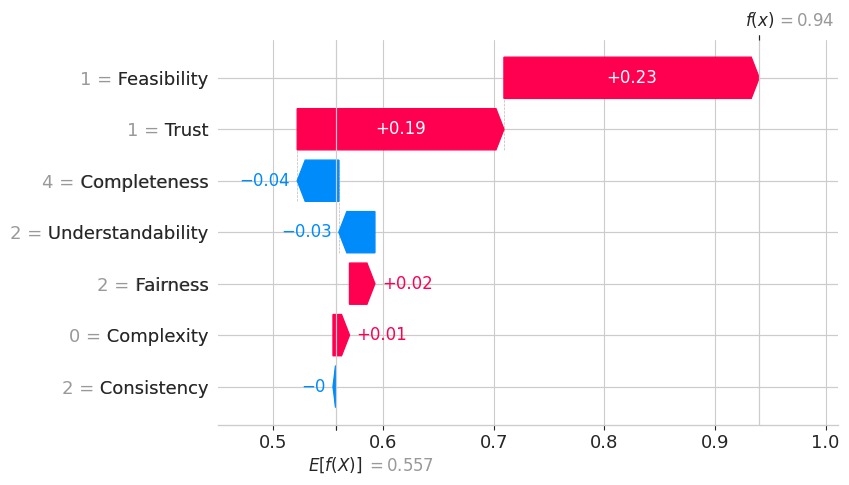

In [77]:
# Select the instance index (first instance as an example)
instance_idx = 0

# Select the class index (0: first class, 1: second class, 2: third class, etc.)
class_idx = 1  # Replace with the class you are interested in

# Create waterfall plot specifically for the selected instance and class
shap.plots.waterfall(shap_values_rf_cl[instance_idx][:, class_idx], show=False)

# Optionally save the plot
plt.savefig("shap_waterfall_plot_class_specific_medium.png", bbox_inches='tight')
plt.show()

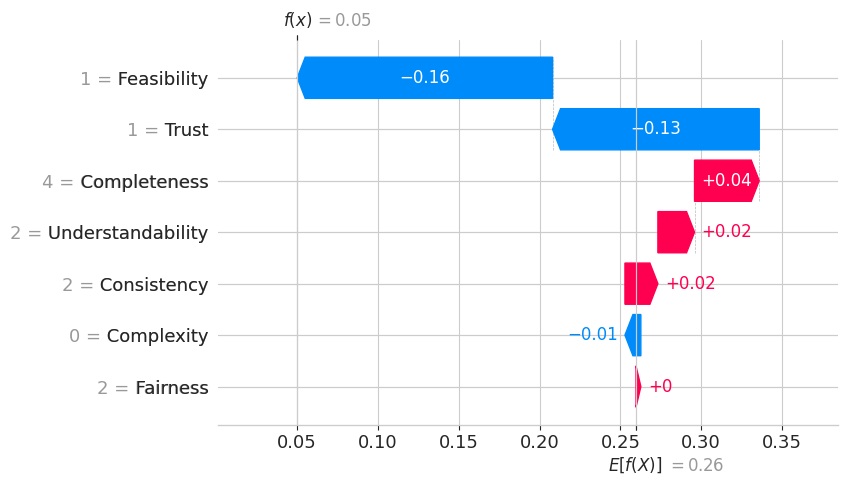

In [78]:
# Select the instance index (first instance as an example)
instance_idx = 0

# Select the class index (0: first class, 1: second class, 2: third class, etc.)
class_idx = 2  # Replace with the class you are interested in

# Create waterfall plot specifically for the selected instance and class
shap.plots.waterfall(shap_values_rf_cl[instance_idx][:, class_idx], show=False)

# Optionally save the plot
plt.savefig("shap_waterfall_plot_class_specific_high.png", bbox_inches='tight')
plt.show()

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_cv = []

for model_name, clf in models.items():
    # We do cross_val_score on accuracy
    acc_scores = cross_val_score(clf, X, y,
                                 scoring="accuracy",
                                 cv=kf)
    acc_mean = np.mean(acc_scores)
    acc_std = np.std(acc_scores)
    f1_scores = cross_val_score(clf, X, y,
                                scoring="f1_macro",
                                cv=kf)
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)

    results_cv.append((model_name, acc_mean, acc_std))

    print(f"\n=== {model_name} (5-fold CV) ===")
    print(f"Accuracy: {acc_mean:.3f} ± {acc_std:.3f}")
    print(f"F1-score (macro):, {f1_mean:.3f} ± {f1_std:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


=== Logistic Regression (5-fold CV) ===
Accuracy: 0.757 ± 0.008
F1-score (macro):, 0.742 ± 0.006

=== Decision Tree (5-fold CV) ===
Accuracy: 0.781 ± 0.009
F1-score (macro):, 0.769 ± 0.009

=== Random Forest (5-fold CV) ===
Accuracy: 0.756 ± 0.006
F1-score (macro):, 0.739 ± 0.004


In [57]:
from sklearn.linear_model import LogisticRegression

# For multinomial classification
logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [58]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("=== Logistic Regression ===")
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {acc_lr:.3f}")

print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, digits=3))

print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_lr, labels=["low","medium","high"]))

=== Logistic Regression ===
Accuracy: 0.749
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

        high      0.756     0.779     0.767       294
         low      0.820     0.856     0.837       533
      medium      0.618     0.562     0.589       349

    accuracy                          0.749      1176
   macro avg      0.731     0.732     0.731      1176
weighted avg      0.744     0.749     0.746      1176

Confusion Matrix (Logistic Regression):
[[456  64  13]
 [ 92 196  61]
 [  8  57 229]]


In [60]:
print("\n=== Random Forest ===")
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {acc_rf:.3f}")

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, digits=3))

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf, labels=["low","medium","high"]))


=== Random Forest ===
Accuracy: 0.761
Classification Report (Random Forest):
              precision    recall  f1-score   support

        high      0.751     0.738     0.744       294
         low      0.865     0.841     0.853       533
      medium      0.623     0.659     0.641       349

    accuracy                          0.761      1176
   macro avg      0.746     0.746     0.746      1176
weighted avg      0.765     0.761     0.763      1176

Confusion Matrix (Random Forest):
[[448  72  13]
 [ 60 230  59]
 [ 10  67 217]]


Le'ts do factor analysis and bi-clusters

In [61]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=f676f21d550cee07e0586d6bb5a96d22c47ac21da50e7c9a579b71b0e5c568b0
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


In [62]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer

In [63]:
metrics = [
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity",
    "Satisfaction"  # or you can exclude Satisfaction if it's the target
]

# Suppose df_long has these columns
X = df_long[metrics].dropna()

In [64]:
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Bartlett’s test of sphericity (checks if correlations are not identity matrix)
chi_square_value, p_value = calculate_bartlett_sphericity(X)
print(f"Bartlett’s test: Chi-square={chi_square_value}, p-value={p_value}")

# Kaiser-Meyer-Olkin (KMO) measure of sampling adequacy
kmo_all, kmo_model = calculate_kmo(X)
print(f"KMO Model: {kmo_model}")

Bartlett’s test: Chi-square=28150.27636602828, p-value=0.0
KMO Model: 0.8927520828149783


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


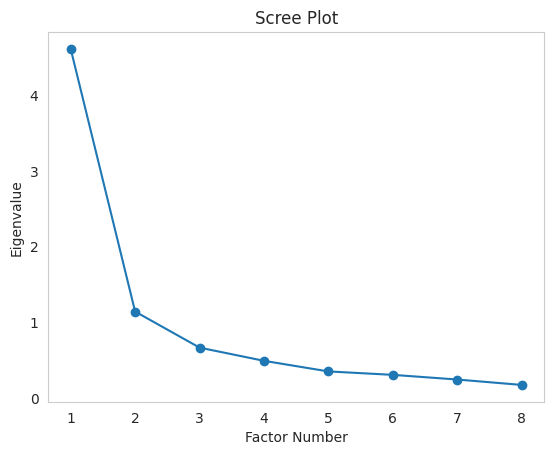

In [65]:
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

# 1) Fit a FactorAnalyzer without specifying n_factors
#    so we can get all possible eigenvalues
fa_all = FactorAnalyzer(rotation=None)
fa_all.fit(X)

# 2) Extract eigenvalues
ev, v = fa_all.get_eigenvalues()
# ev is array of eigenvalues for each factor
# v is the explained variance

# 3) Plot the scree plot
plt.scatter(range(1, X.shape[1]+1), ev)
plt.plot(range(1, X.shape[1]+1), ev)
plt.title("Scree Plot")
plt.xlabel("Factor Number")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

In [66]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X)

# Factor loadings
loadings = fa.loadings_
print("Factor Loadings:\n", loadings)

# Get variance explained
variance_explained = fa.get_factor_variance()
print("\nVariance explained by each factor:\n", variance_explained)

Factor Loadings:
 [[ 0.76598894  0.21636538]
 [ 0.81843178  0.14218361]
 [ 0.70875536  0.39826968]
 [ 0.79928581  0.38095773]
 [ 0.66268248 -0.23488601]
 [ 0.76017849 -0.09966998]
 [ 0.00917758  0.39163738]
 [ 0.76674994  0.47137592]]

Variance explained by each factor:
 (array([4.00277072, 0.81145833]), array([0.50034634, 0.10143229]), array([0.50034634, 0.60177863]))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [67]:
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(X)

# Factor loadings
loadings = fa.loadings_
print("Factor Loadings:\n", loadings)

# Get variance explained
variance_explained = fa.get_factor_variance()
print("\nVariance explained by each factor:\n", variance_explained)

Factor Loadings:
 [[ 0.77713765  0.30775903  0.10428794]
 [ 0.60593217  0.53076818  0.18028408]
 [ 0.4707097   0.51046494  0.56530106]
 [ 0.68035686  0.41713023  0.36144348]
 [ 0.28285146  0.7078316  -0.12054447]
 [ 0.55379676  0.51413709 -0.07377756]
 [ 0.05741709 -0.06998028  0.39120024]
 [ 0.8155038   0.24201682  0.3576791 ]]

Variance explained by each factor:
 (array([2.71058877, 1.63983447, 0.79453106]), array([0.3388236 , 0.20497931, 0.09931638]), array([0.3388236 , 0.5438029 , 0.64311929]))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)  # let's do 2 principal components
pca.fit(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Singular values:", pca.singular_values_)

Explained variance ratio: [0.62896261 0.10402854]
Singular values: [290.23762667 118.03683583]


In [69]:
X

Feasibility  Consistency  Completeness  Trust  Understandability  \
0               3            4             1      2                  6   
1               4            4             4      5                  5   
2               5            5             4      5                  5   
3               3            4             4      3                  2   
4               2            2             2      1                  4   
...           ...          ...           ...    ...                ...   
5875            5            5             5      5                  5   
5876            5            6             5      6                  6   
5877            5            5             6      5                  4   
5878            2            5             5      6                  4   
5879            1            5             1      1                  6   

      Fairness  Complexity  Satisfaction  
0            6          -2             2  
1            5           0             5  
2            3          -1             5  
3            2           1             3  
4            2          -1             2  
...        ...         ...           ...  
5875         5           0             5  
5876         6           0             6  
5877         6           2             5  
5878         3           2             5  
5879         1          -1             2  

[5880 rows x 8 columns]

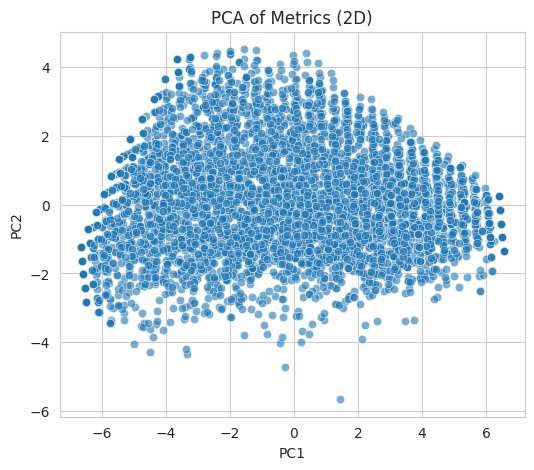

In [70]:
X_pca = pca.transform(X)  # shape: (n_samples, 2)

df_pca = pd.DataFrame(X_pca, columns=["PC1","PC2"])
df_pca["id. Response ID"] = df_long["id. Response ID"].values  # if you have the same ordering
df_pca["ScenarioID"] = df_long["ScenarioID"].values

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", alpha=0.6)
plt.title("PCA of Metrics (2D)")
plt.show()

In [71]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=["PC1","PC2"],
                        index=metrics)
print(loadings)

                        PC1       PC2
Feasibility        0.391090 -0.020151
Consistency        0.418935  0.055538
Completeness       0.375789 -0.308301
Trust              0.425421 -0.231560
Understandability  0.236617  0.512216
Fairness           0.362444  0.582763
Complexity         0.037731 -0.398162
Satisfaction       0.400706 -0.295514


In [72]:
from sklearn.cluster import SpectralCoclustering, SpectralBiclustering

# Suppose we try SpectralCoclustering
n_clusters = 2
model_bi = SpectralCoclustering(n_clusters=n_clusters, random_state=42)
model_bi.fit(X)  # X: shape (n_samples, n_features)

# The row and column labels
row_labels = model_bi.row_labels_    # array of length n_samples
col_labels = model_bi.column_labels_ # array of length n_features

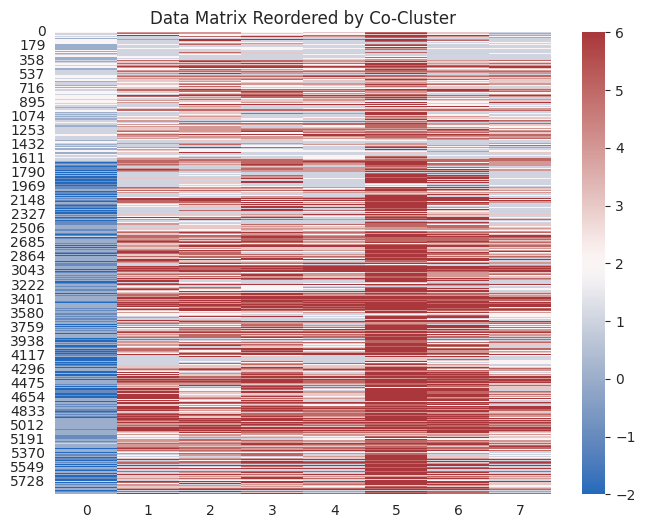

In [73]:
import numpy as np

fit_data = X.to_numpy()
rows = np.argsort(row_labels)
cols = np.argsort(col_labels)

fit_data_reordered = fit_data[rows][:, cols]

plt.figure(figsize=(8,6))
sns.heatmap(fit_data_reordered, cmap="vlag")
plt.title("Data Matrix Reordered by Co-Cluster")
plt.show()

In [74]:
df_long.head()

id. Response ID  Satisfaction  Feasibility  Consistency  Completeness  \
0               64             2            3            4             1   
1               66             5            4            4             4   
2               67             5            5            5             4   
3               68             3            3            4             4   
4               69             2            2            2             2   

   Trust  Understandability  Fairness  Complexity  ScenarioID  predicted  \
0      2                  6         6          -2           1   1.938178   
1      5                  5         5           0           1   4.104704   
2      5                  5         3          -1           1   4.415176   
3      3                  2         2           1           1   3.259214   
4      1                  4         2          -1           1   1.405721   

  Satisfaction_cat  
0              low  
1             high  
2             high  
3           medium  
4              low

In [75]:
print(df_long.columns.tolist())

['id. Response ID', 'Satisfaction', 'Feasibility', 'Consistency', 'Completeness', 'Trust', 'Understandability', 'Fairness', 'Complexity', 'ScenarioID', 'predicted', 'Satisfaction_cat']


In [76]:
import pandas as pd

metric = "Feasibility"
df_wide = df_long.pivot_table(
    index="id. Response ID",
    columns="ScenarioID",
    values=metric
)

# df_wide is a DataFrame of shape [n_participants x 30 scenarios],
# with each cell the Feasibility rating.
print(df_wide.shape)
print(df_wide.head())

(196, 30)
ScenarioID        1    2    3    4    5    6    7    8    9    10  ...   21  \
id. Response ID                                                    ...        
64               3.0  2.0  1.0  1.0  1.0  2.0  1.0  2.0  2.0  1.0  ...  1.0   
66               4.0  4.0  2.0  2.0  1.0  2.0  4.0  2.0  2.0  2.0  ...  3.0   
67               5.0  3.0  4.0  5.0  4.0  5.0  4.0  5.0  3.0  1.0  ...  4.0   
68               3.0  4.0  4.0  1.0  1.0  4.0  4.0  3.0  2.0  3.0  ...  4.0   
69               2.0  6.0  2.0  1.0  2.0  3.0  3.0  4.0  1.0  1.0  ...  3.0   

ScenarioID        22   23   24   25   26   27   28   29   30  
id. Response ID                                               
64               1.0  6.0  6.0  5.0  4.0  3.0  1.0  1.0  1.0  
66               2.0  6.0  6.0  5.0  6.0  2.0  4.0  1.0  2.0  
67               3.0  4.0  5.0  4.0  5.0  5.0  5.0  3.0  5.0  
68               2.0  4.0  5.0  5.0  5.0  5.0  1.0  1.0  1.0  
69               1.0  2.0  3.0  4.0  5.0  2.0  1.0  1.0  1

In [77]:
import numpy as np
from sklearn.cluster import SpectralCoclustering
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy array
mat = df_wide.to_numpy()

# Let's pick 2 co-clusters as an example (tune as you see fit)
n_clusters = 2
model = SpectralCoclustering(n_clusters=n_clusters, random_state=42)
model.fit(mat)

row_labels = model.row_labels_    # cluster assignment for each participant
col_labels = model.column_labels_ # cluster assignment for each scenario

print("Row cluster labels (participants):", row_labels)
print("Column cluster labels (scenarios):", col_labels)

Row cluster labels (participants): [1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0
 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1
 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0
 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1
 0 1 0 0 0 1 0 0 0 0 0]
Column cluster labels (scenarios): [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0]


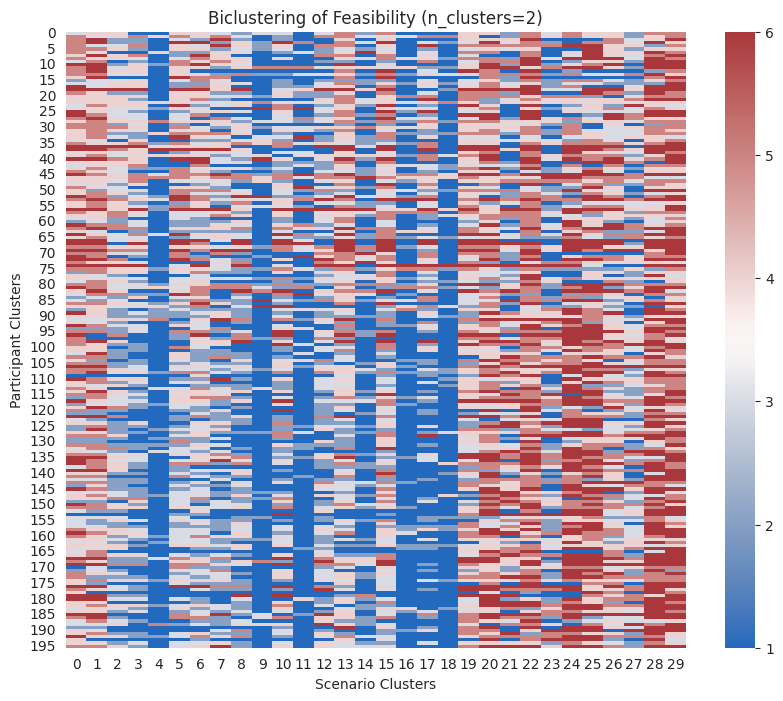

In [78]:
# Reorder rows/columns by cluster labels
row_order = np.argsort(row_labels)
col_order = np.argsort(col_labels)

mat_reordered = mat[row_order][:, col_order]

plt.figure(figsize=(10,8))
sns.heatmap(mat_reordered, cmap="vlag", robust=True)
plt.title(f"Biclustering of {metric} (n_clusters={n_clusters})")
plt.xlabel("Scenario Clusters")
plt.ylabel("Participant Clusters")
plt.show()

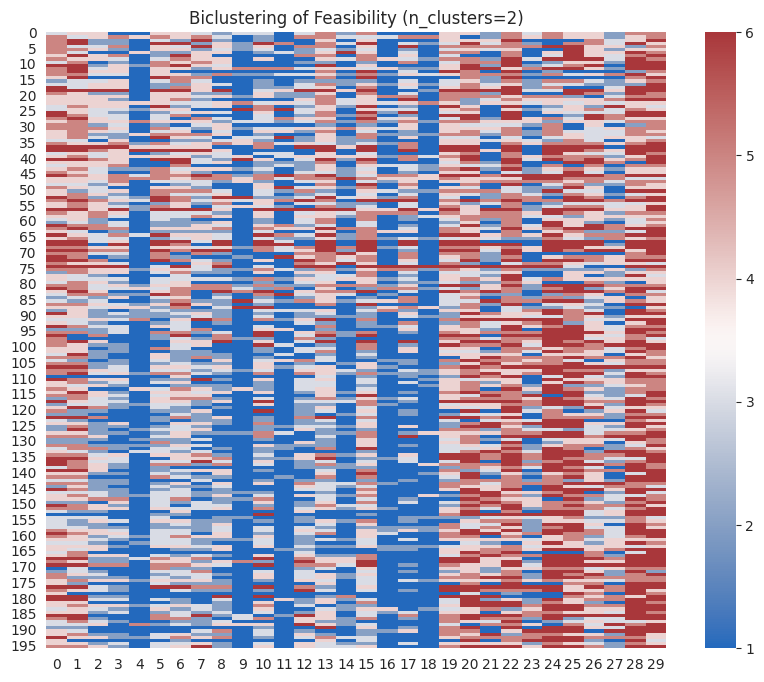

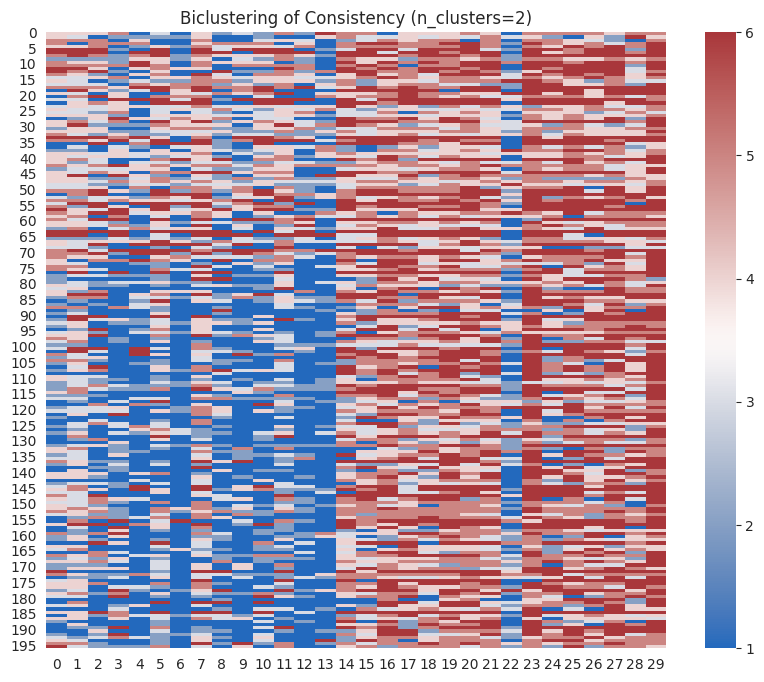

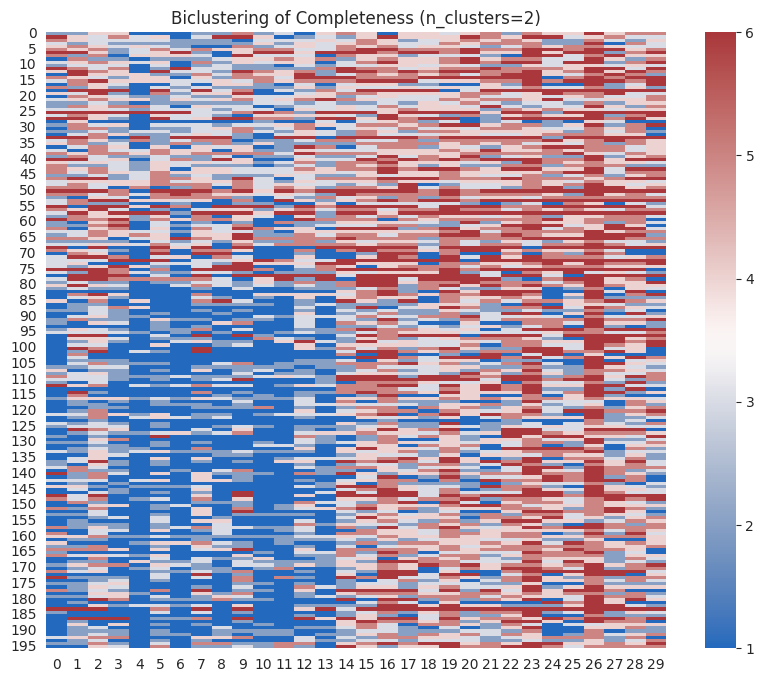

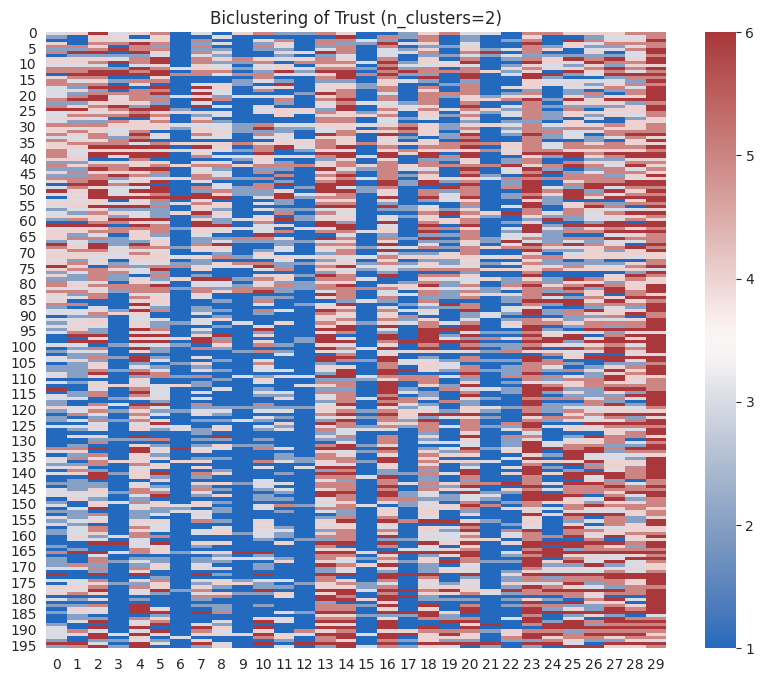

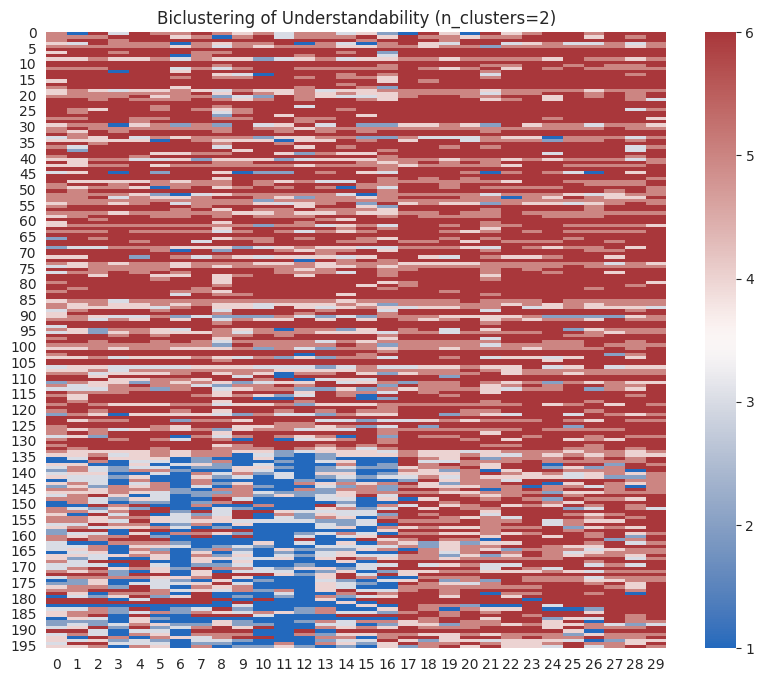

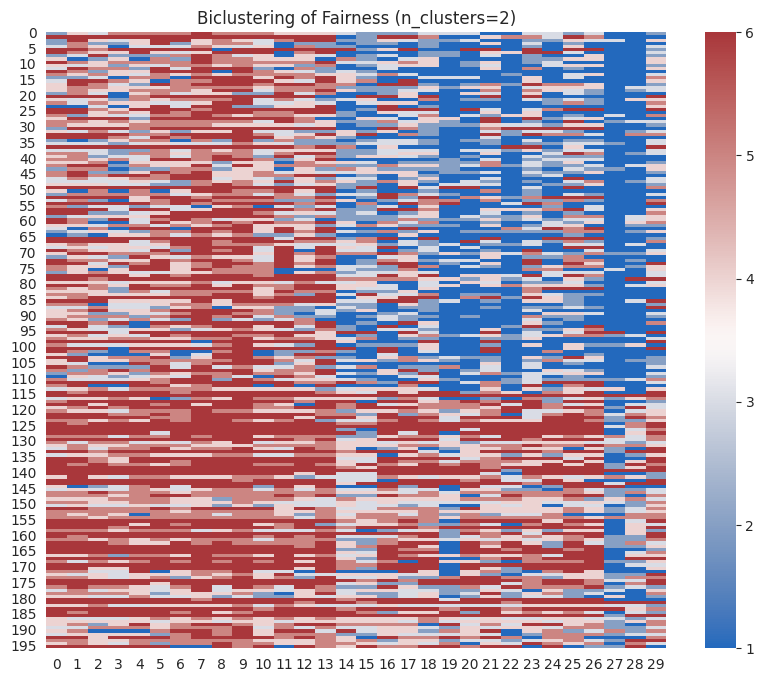

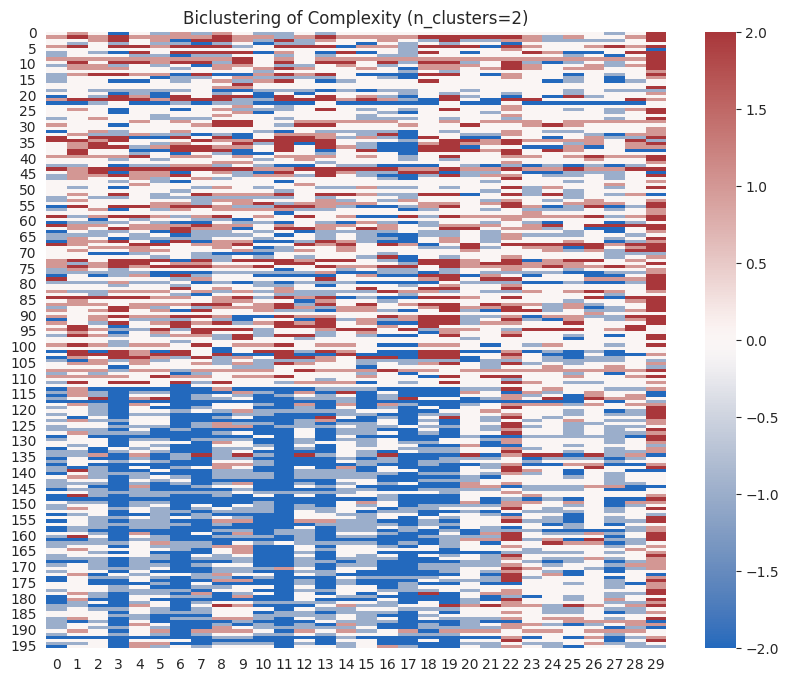

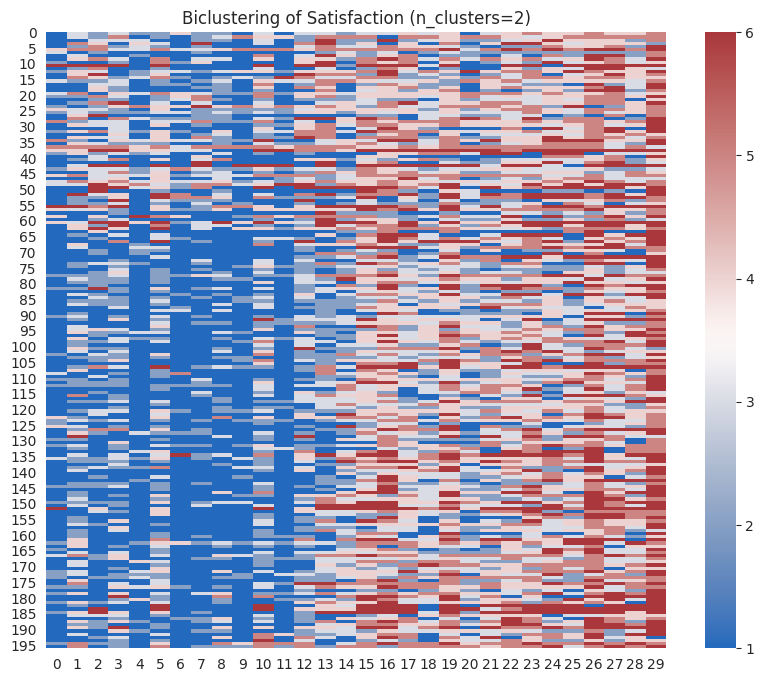

In [79]:
metrics_list = [
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity",
    "Satisfaction"  # if you want to treat Satisfaction also as a rating
]

for metric in metrics_list:
    # 3.1 Pivot
    df_wide = df_long.pivot_table(index="id. Response ID", columns="ScenarioID", values=metric)

    # 3.2 Clean missing if needed
    df_wide = df_wide.dropna(axis=0, how="any")
    df_wide = df_wide.dropna(axis=1, how="any")

    # 3.3 Biclustering
    mat = df_wide.to_numpy()

    n_clusters = 2
    model = SpectralCoclustering(n_clusters=n_clusters, random_state=42)
    model.fit(mat)

    # 3.4 Reorder
    row_order = np.argsort(model.row_labels_)
    col_order = np.argsort(model.column_labels_)
    mat_reordered = mat[row_order][:, col_order]

    # 3.5 Plot
    plt.figure(figsize=(10,8))
    sns.heatmap(mat_reordered, cmap="vlag", robust=True)
    plt.title(f"Biclustering of {metric} (n_clusters={n_clusters})")
    plt.show()

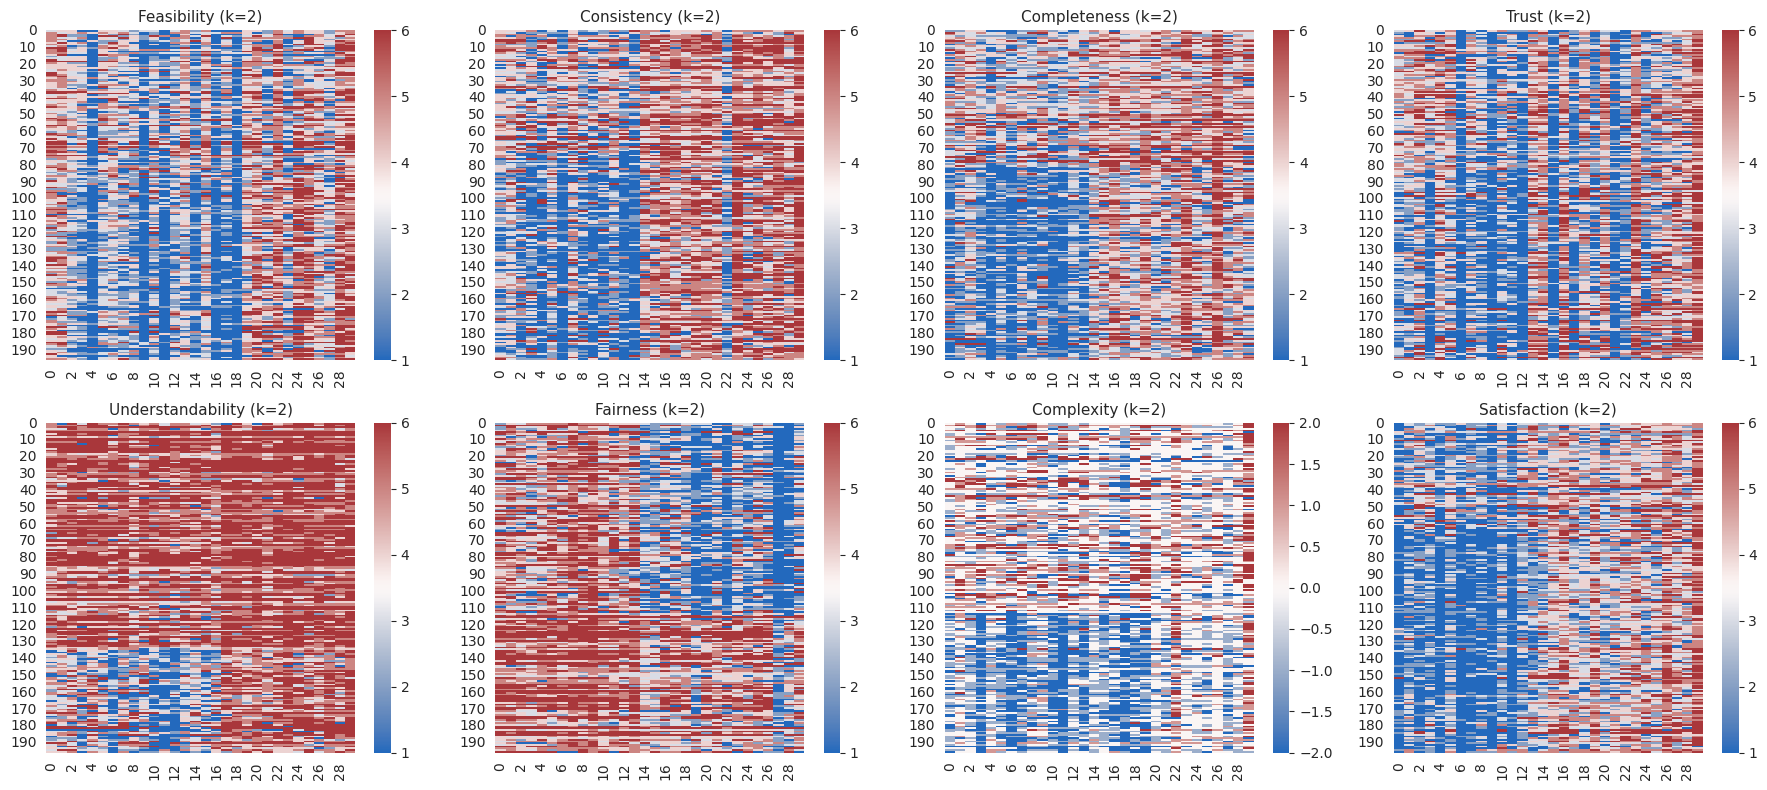

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralCoclustering

metrics_list = [
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity",
    "Satisfaction"
]

# Create a figure with 2 rows, 4 columns (8 subplots total)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.flatten()  # make it easier to index in a single loop

for i, metric in enumerate(metrics_list):
    ax = axes[i]  # the subplot to draw on

    # --- 1. Pivot for this metric ---
    df_wide = df_long.pivot_table(
        index="id. Response ID",
        columns="ScenarioID",
        values=metric
    )

    # --- 2. Clean missing ---
    df_wide.dropna(axis=0, how="any", inplace=True)
    df_wide.dropna(axis=1, how="any", inplace=True)

    # --- 3. Biclustering ---
    mat = df_wide.to_numpy()
    n_clusters = 2  # or your chosen number
    model = SpectralCoclustering(n_clusters=n_clusters, random_state=42)
    model.fit(mat)

    # --- 4. Reorder rows & columns ---
    row_order = np.argsort(model.row_labels_)
    col_order = np.argsort(model.column_labels_)
    mat_reordered = mat[row_order][:, col_order]

    # --- 5. Plot the heatmap in this subplot ---
    sns.heatmap(
        mat_reordered,
        cmap="vlag",
        robust=True,
        ax=ax
    )
    ax.set_title(f"{metric} (k={n_clusters})", fontsize=11)

# Tight layout to avoid overlap
plt.tight_layout()

# Save at high resolution
plt.savefig("biclustering_2x4_subplots.png", dpi=300, bbox_inches="tight")

# Show the figure
plt.show()

In [81]:
def approximate_reconstruction_error(model, X):
    """
    Manually compute the reconstruction error for SpectralCoclustering.

    Args:
        model: A fitted SpectralCoclustering model.
        X: 2D numpy array (the original data matrix).
    Returns:
        Frobenius norm of (X - X_approx),
        where X_approx is the block-mean approximation.
    """
    row_labels = model.row_labels_
    col_labels = model.column_labels_
    n_clusters = model.n_clusters

    # Prepare an empty approximation matrix
    X_approx = np.zeros_like(X, dtype=float)

    # For each block, compute mean of the submatrix, fill that block in X_approx
    for i in range(n_clusters):
        # the rows belonging to cluster i
        rows_i = np.where(row_labels == i)[0]
        for j in range(n_clusters):
            # the columns belonging to cluster j
            cols_j = np.where(col_labels == j)[0]
            submatrix = X[rows_i[:, None], cols_j]
            block_mean = np.mean(submatrix)  # or median, etc.
            X_approx[rows_i[:, None], cols_j] = block_mean

    # Compute Frobenius norm of the difference
    error = np.linalg.norm(X - X_approx, 'fro')
    return error

In [82]:
from sklearn.cluster import SpectralCoclustering

best_error = np.inf
best_k = None

for k in range(2, 6):
    model_test = SpectralCoclustering(n_clusters=k, random_state=42)
    model_test.fit(mat)  # mat is your data matrix
    error = approximate_reconstruction_error(model_test, mat)
    print(f"k={k}, reconstruction error={error:.3f}")
    if error < best_error:
        best_error = error
        best_k = k

print(f"\nBest k={best_k} with reconstruction error={best_error:.3f}")

k=2, reconstruction error=111.486
k=3, reconstruction error=107.906
k=4, reconstruction error=106.313
k=5, reconstruction error=107.523

Best k=4 with reconstruction error=106.313


BICLUSTERING FOR METRIC: Feasibility
  k=2, reconstruction error=121.363
  k=3, reconstruction error=113.363
  k=4, reconstruction error=109.334
  k=5, reconstruction error=104.966
=> Best k=5 for metric=Feasibility with error=104.966


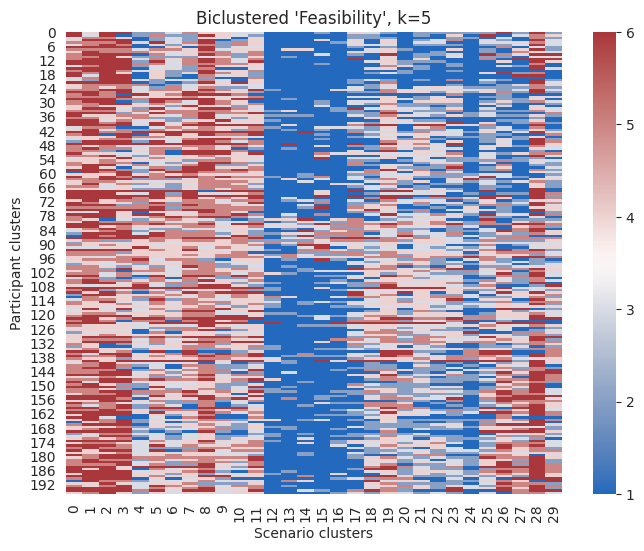

BICLUSTERING FOR METRIC: Consistency
  k=2, reconstruction error=118.079
  k=3, reconstruction error=114.091
  k=4, reconstruction error=108.108
  k=5, reconstruction error=109.857
=> Best k=4 for metric=Consistency with error=108.108


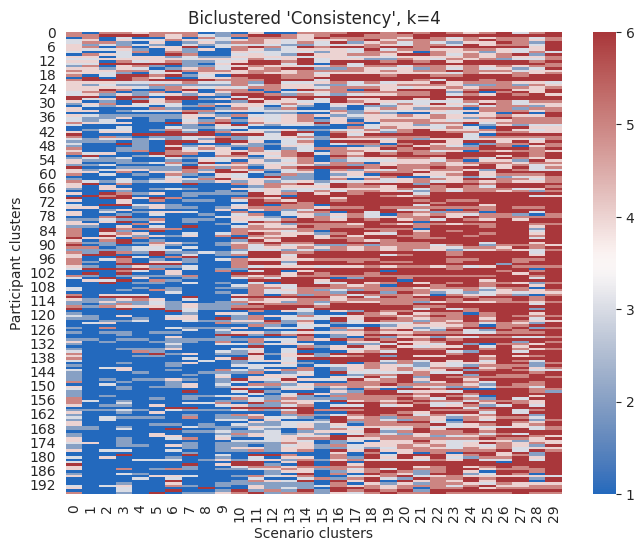

BICLUSTERING FOR METRIC: Completeness
  k=2, reconstruction error=113.432
  k=3, reconstruction error=110.529
  k=4, reconstruction error=110.960
  k=5, reconstruction error=109.057
=> Best k=5 for metric=Completeness with error=109.057


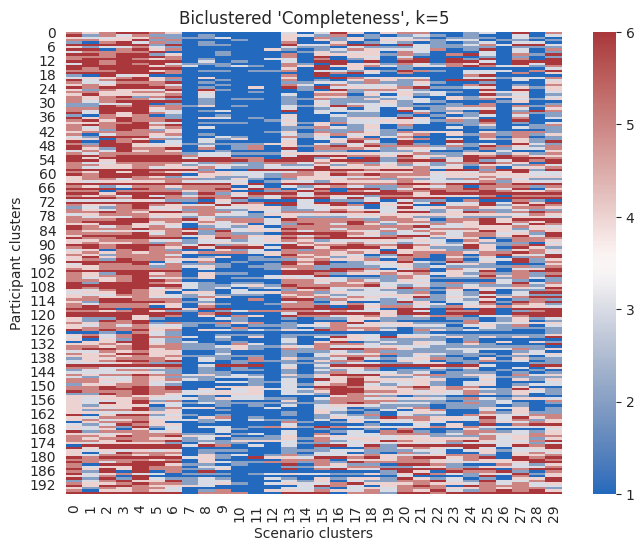

BICLUSTERING FOR METRIC: Trust
  k=2, reconstruction error=132.745
  k=3, reconstruction error=113.497
  k=4, reconstruction error=109.347
  k=5, reconstruction error=111.572
=> Best k=4 for metric=Trust with error=109.347


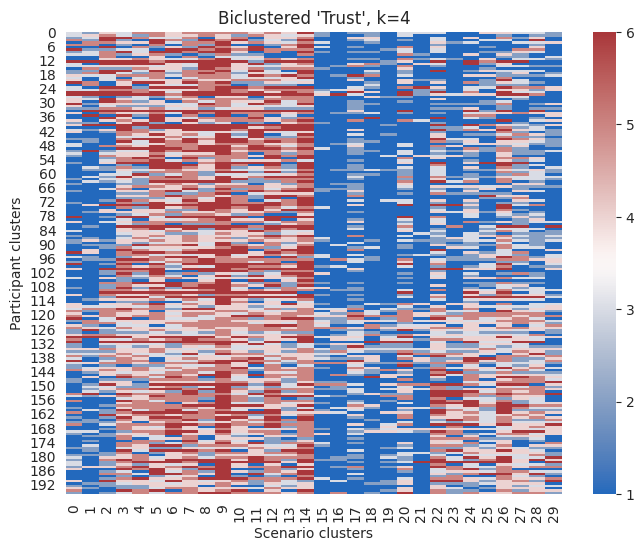

BICLUSTERING FOR METRIC: Understandability
  k=2, reconstruction error=94.389
  k=3, reconstruction error=94.691


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  k=4, reconstruction error=93.620
  k=5, reconstruction error=93.297
=> Best k=5 for metric=Understandability with error=93.297


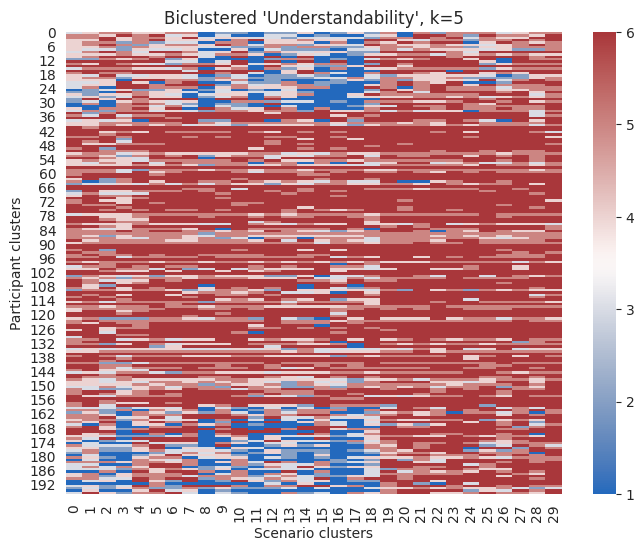

BICLUSTERING FOR METRIC: Fairness
  k=2, reconstruction error=115.234
  k=3, reconstruction error=116.081
  k=4, reconstruction error=112.886
  k=5, reconstruction error=111.629
=> Best k=5 for metric=Fairness with error=111.629


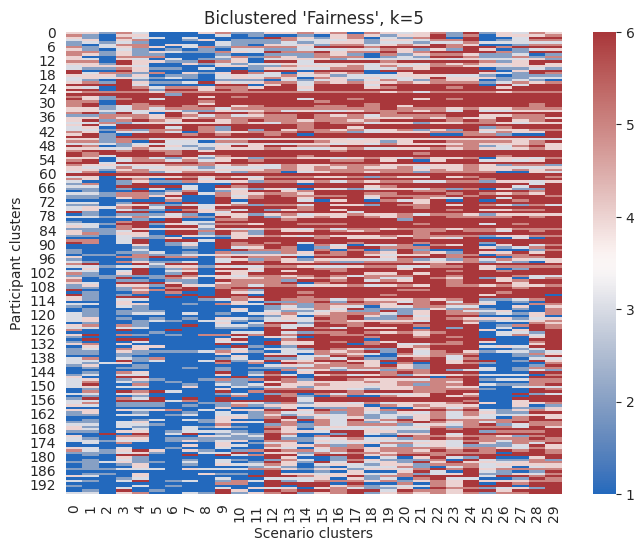

BICLUSTERING FOR METRIC: Complexity
  k=2, reconstruction error=80.533
  k=3, reconstruction error=79.315
  k=4, reconstruction error=77.324
  k=5, reconstruction error=77.941
=> Best k=4 for metric=Complexity with error=77.324


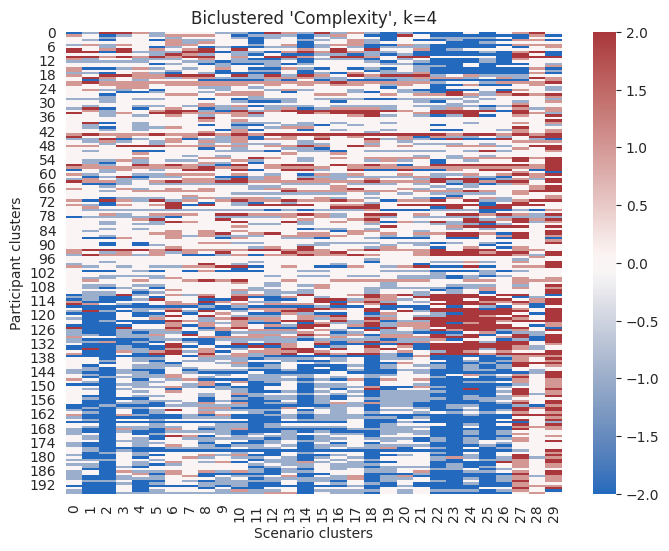

BICLUSTERING FOR METRIC: Satisfaction
  k=2, reconstruction error=111.486
  k=3, reconstruction error=107.906
  k=4, reconstruction error=106.313
  k=5, reconstruction error=107.523
=> Best k=4 for metric=Satisfaction with error=106.313


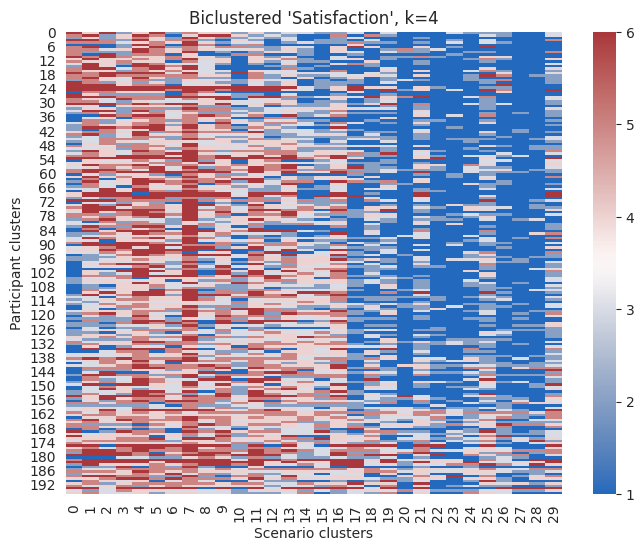

In [83]:
metrics_list = [
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity",
    "Satisfaction"
]

for metric in metrics_list:
    print("="*60)
    print(f"BICLUSTERING FOR METRIC: {metric}")

    # 1) Pivot to [participant × scenario]
    df_wide = df_long.pivot_table(
        index="id. Response ID",
        columns="ScenarioID",
        values=metric
    )

    # 2) Handle missing data (example: drop participants/scenarios w/ NaN)
    df_wide.dropna(axis=0, how="any", inplace=True)
    df_wide.dropna(axis=1, how="any", inplace=True)

    mat = df_wide.values  # 2D numpy array

    # If there's no or very few data points left, skip
    if mat.shape[0] < 2 or mat.shape[1] < 2:
        print(f"Not enough data to bicluster for {metric}. Shape={mat.shape}")
        continue

    # 3) Try k in [2..5]
    best_error = np.inf
    best_k = None
    for k in range(2, 6):
        model_test = SpectralCoclustering(n_clusters=k, random_state=42)
        model_test.fit(mat)
        error = approximate_reconstruction_error(model_test, mat)
        print(f"  k={k}, reconstruction error={error:.3f}")
        if error < best_error:
            best_error = error
            best_k = k

    print(f"=> Best k={best_k} for metric={metric} with error={best_error:.3f}")

    # 4) Fit final bicluster with best_k
    model_final = SpectralCoclustering(n_clusters=best_k, random_state=42)
    model_final.fit(mat)

    # 5) Reorder rows/cols
    row_order = np.argsort(model_final.row_labels_)
    col_order = np.argsort(model_final.column_labels_)
    mat_reordered = mat[row_order][:, col_order]

    # 6) Visualize
    plt.figure(figsize=(8,6))
    sns.heatmap(mat_reordered, cmap="vlag")
    plt.title(f"Biclustered '{metric}', k={best_k}")
    plt.xlabel("Scenario clusters")
    plt.ylabel("Participant clusters")
    plt.show()

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralCoclustering

# If you need the manual reconstruction error function, define here:
def approximate_reconstruction_error(model, X):
    """Compute Frobenius norm of (X - X_approx) for spectral coclustering."""
    row_labels = model.row_labels_
    col_labels = model.column_labels_
    n_clusters = model.n_clusters

    X_approx = np.zeros_like(X, dtype=float)
    for i in range(n_clusters):
        rows_i = np.where(row_labels == i)[0]
        for j in range(n_clusters):
            cols_j = np.where(col_labels == j)[0]
            submatrix = X[rows_i[:, None], cols_j]
            block_mean = np.mean(submatrix)
            X_approx[rows_i[:, None], cols_j] = block_mean

    error = np.linalg.norm(X - X_approx, 'fro')
    return error

###########################################################
# Main Part: Bicluster each metric, find best k, then plot
###########################################################
metrics_list = [
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity",
    "Satisfaction"
]

# We'll store the final (mat_reordered, best_k, metric) for each metric
plot_data = []  # list of tuples (mat_reordered, best_k, metric)

for metric in metrics_list:
    print("=" * 60)
    print(f"BICLUSTERING FOR METRIC: {metric}")

    # 1) Pivot to [participant × scenario]
    df_wide = df_long.pivot_table(
        index="id. Response ID",
        columns="ScenarioID",
        values=metric
    )

    # 2) Handle missing data
    df_wide.dropna(axis=0, how="any", inplace=True)
    df_wide.dropna(axis=1, how="any", inplace=True)

    mat = df_wide.values
    if mat.shape[0] < 2 or mat.shape[1] < 2:
        print(f"Not enough data to bicluster for {metric}. Shape={mat.shape}")
        # We'll store None so we can skip in the plot
        plot_data.append((None, None, metric))
        continue

    # 3) Try k in [2..5]
    best_error = np.inf
    best_k = None
    for k in range(2, 6):
        model_test = SpectralCoclustering(n_clusters=k, random_state=42)
        model_test.fit(mat)
        error = approximate_reconstruction_error(model_test, mat)
        print(f"  k={k}, reconstruction error={error:.3f}")
        if error < best_error:
            best_error = error
            best_k = k

    print(f"=> Best k={best_k} for metric={metric} with error={best_error:.3f}\n")

    # 4) Fit final bicluster with best_k
    model_final = SpectralCoclustering(n_clusters=best_k, random_state=42)
    model_final.fit(mat)

    # 5) Reorder
    row_order = np.argsort(model_final.row_labels_)
    col_order = np.argsort(model_final.column_labels_)
    mat_reordered = mat[row_order][:, col_order]

    # Store for plotting
    plot_data.append((mat_reordered, best_k, metric))


for i, (mat_reordered, best_k, metric) in enumerate(plot_data):

    if mat_reordered is None:
        # Skip if no data
        continue

    # Create a figure for this metric alone
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(
        mat_reordered, cmap="vlag", robust=True
    )
    ax.set_title(f"{metric} (best k={best_k})", fontsize=28)
    ax.set_xlabel("Scenario clusters", fontsize=24)
    ax.set_ylabel("Participant clusters", fontsize=24)

    # Increase tick label font size
    ax.tick_params(axis='both', labelsize=12)

    # Optionally adjust colorbar font
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)

    plt.tight_layout()
    plt.savefig(f"bicluster_{metric}.png", dpi=300, bbox_inches="tight")
    plt.close()

BICLUSTERING FOR METRIC: Feasibility
  k=2, reconstruction error=121.363
  k=3, reconstruction error=113.363
  k=4, reconstruction error=109.334
  k=5, reconstruction error=104.966
=> Best k=5 for metric=Feasibility with error=104.966

BICLUSTERING FOR METRIC: Consistency
  k=2, reconstruction error=118.079
  k=3, reconstruction error=114.091
  k=4, reconstruction error=108.108
  k=5, reconstruction error=109.857
=> Best k=4 for metric=Consistency with error=108.108

BICLUSTERING FOR METRIC: Completeness
  k=2, reconstruction error=113.432
  k=3, reconstruction error=110.529
  k=4, reconstruction error=110.960
  k=5, reconstruction error=109.057
=> Best k=5 for metric=Completeness with error=109.057

BICLUSTERING FOR METRIC: Trust
  k=2, reconstruction error=132.745
  k=3, reconstruction error=113.497
  k=4, reconstruction error=109.347
  k=5, reconstruction error=111.572
=> Best k=4 for metric=Trust with error=109.347

BICLUSTERING FOR METRIC: Understandability
  k=2, reconstruction e

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  k=5, reconstruction error=93.297
=> Best k=5 for metric=Understandability with error=93.297

BICLUSTERING FOR METRIC: Fairness
  k=2, reconstruction error=115.234
  k=3, reconstruction error=116.081
  k=4, reconstruction error=112.886
  k=5, reconstruction error=111.629
=> Best k=5 for metric=Fairness with error=111.629

BICLUSTERING FOR METRIC: Complexity
  k=2, reconstruction error=80.533
  k=3, reconstruction error=79.315
  k=4, reconstruction error=77.324
  k=5, reconstruction error=77.941
=> Best k=4 for metric=Complexity with error=77.324

BICLUSTERING FOR METRIC: Satisfaction
  k=2, reconstruction error=111.486
  k=3, reconstruction error=107.906
  k=4, reconstruction error=106.313
  k=5, reconstruction error=107.523
=> Best k=4 for metric=Satisfaction with error=106.313



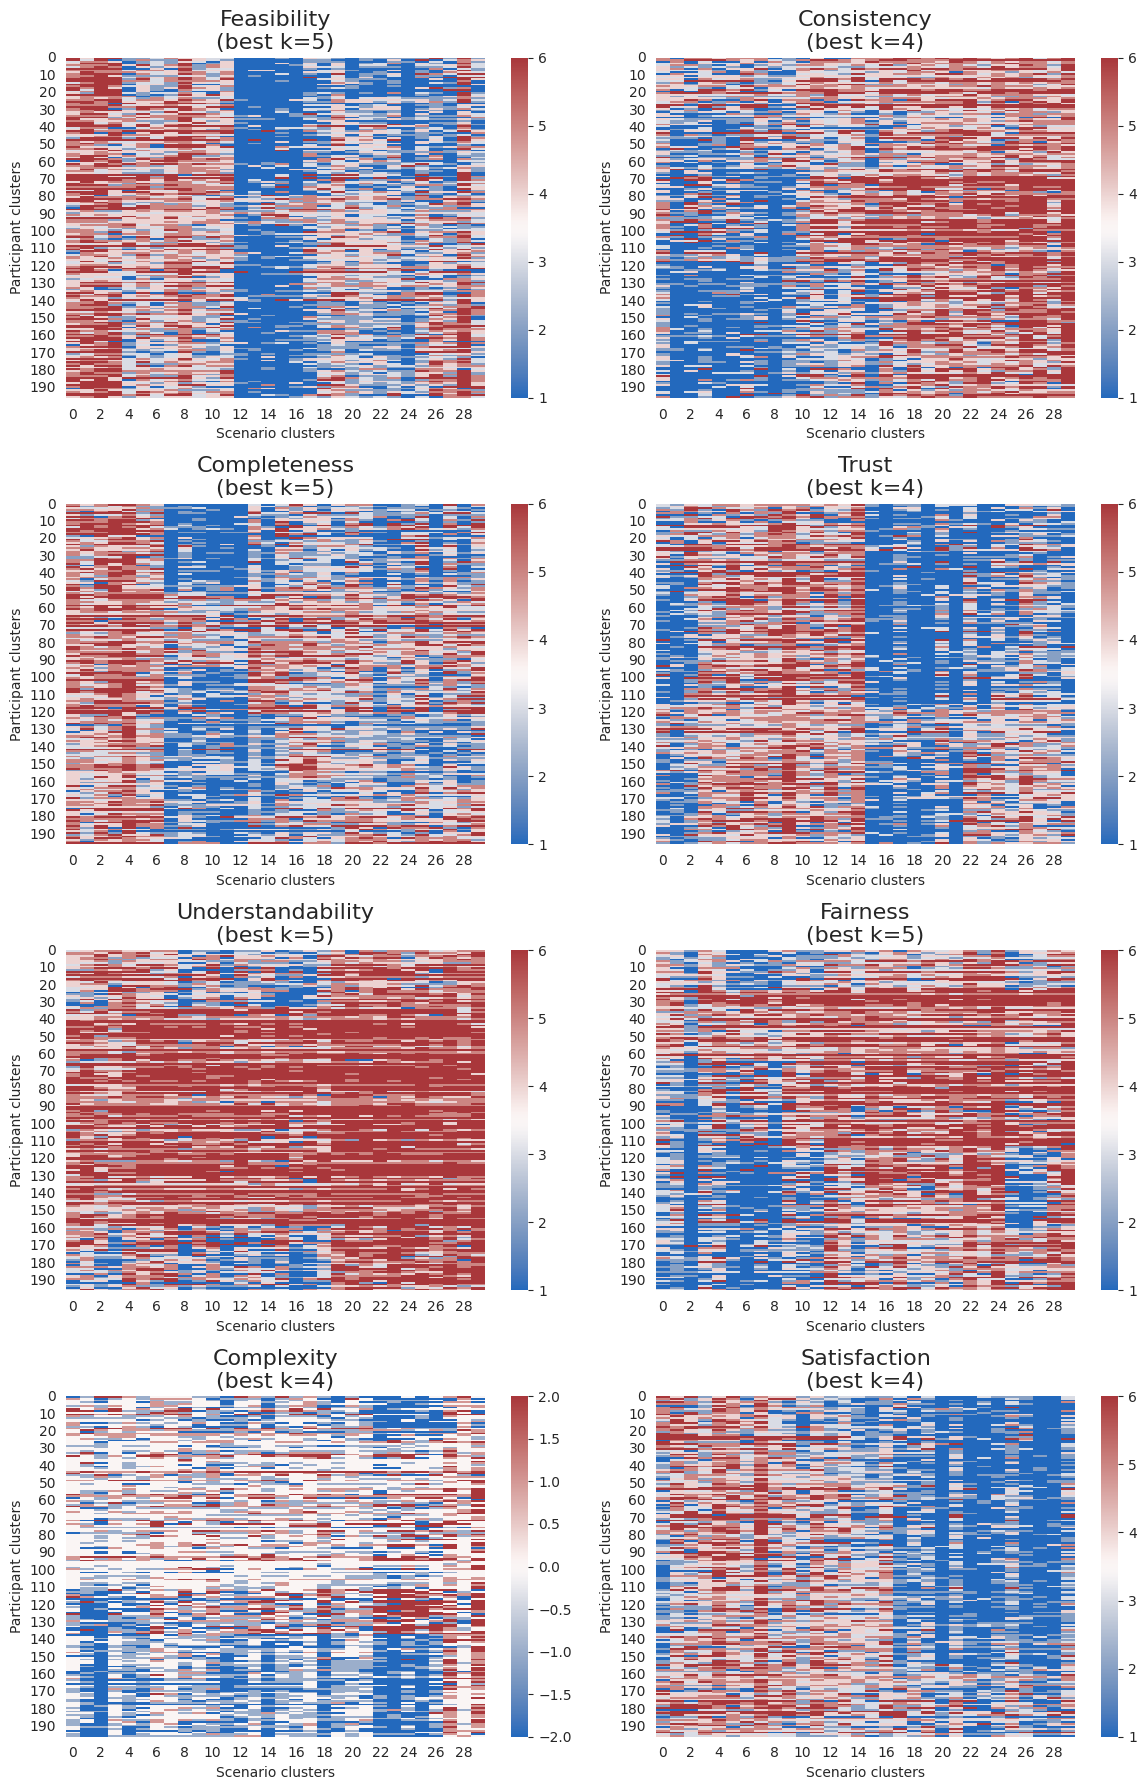

In [85]:
###########################################################
# Plot everything in a single 2x4 figure
###########################################################
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 18))
axes = axes.flatten()

for i, (mat_reordered, best_k, metric) in enumerate(plot_data):
    ax = axes[i]

    if mat_reordered is None:
        # Not enough data scenario
        ax.text(0.5, 0.5, f"No data for {metric}", ha='center', va='center', fontsize=12)
        ax.set_axis_off()
        continue

    sns.heatmap(
        mat_reordered, cmap="vlag", robust=True, ax=ax
    )
    ax.set_title(f"{metric}\n(best k={best_k})", fontsize=16)
    ax.set_xlabel("Scenario clusters")
    ax.set_ylabel("Participant clusters")

plt.tight_layout()

# Optionally save
plt.savefig("biclustering_best_k_4x2.png", dpi=300, bbox_inches="tight")

plt.show()

In [86]:
# Let's define your 8 metrics again
metrics_list = [
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity",
    "Satisfaction"
]

# We'll create columns like "Feasibility_1", "Consistency_1", ... "Satisfaction_30"
# pivot_table doesn't directly handle multiple columns -> We do a pivot for each metric and merge

def pivot_metric_scenario(df, metric):
    """Pivot to wide: row=participant, col=scenario, val=metric."""
    pivoted = df.pivot_table(
        index="id. Response ID",
        columns="ScenarioID",
        values=metric
    )
    # rename columns to e.g. {1: Feasibility_1, 2: Feasibility_2, ...}
    pivoted.columns = [f"{metric}_{c}" for c in pivoted.columns]
    return pivoted

dfs_for_merge = []

for m in metrics_list:
    wide_m = pivot_metric_scenario(df_long, m)
    dfs_for_merge.append(wide_m)

# Merge them side by side on "id"
df_flat = pd.concat(dfs_for_merge, axis=1)

# Drop rows with any NaN
df_flat.dropna(axis=0, how="any", inplace=True)
# Now df_flat has shape [n_participants x (30*8)] = [n_participants x 240], if all scenarios are present
print(df_flat.shape)  # e.g. (150, 240) if 150 participants remain

(196, 240)


k=2, reconstruction error=396.044
k=3, reconstruction error=399.067
k=4, reconstruction error=374.403
k=5, reconstruction error=338.554
=> Best k=5, error=338.554 for the flattened matrix


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


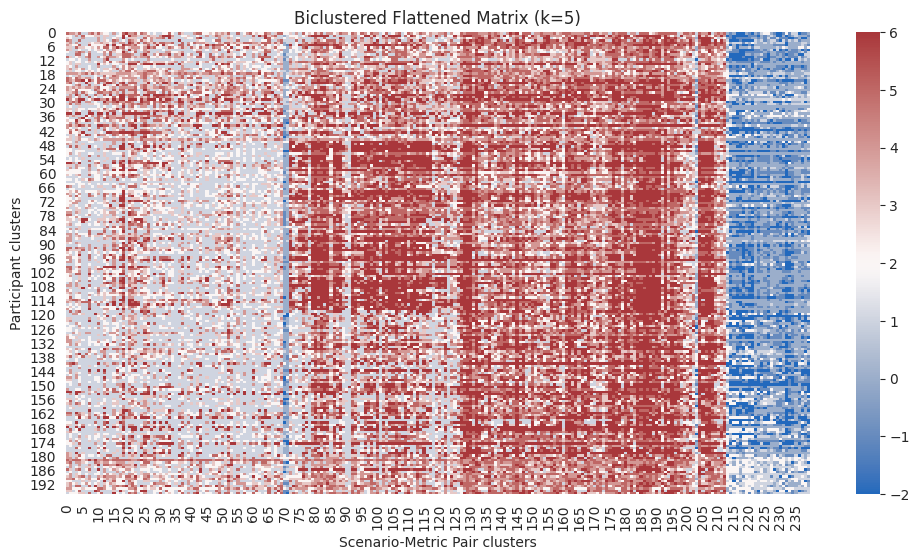

In [87]:
mat_flat = df_flat.values

best_error = np.inf
best_k = None
for k in range(2, 6):
    model_test = SpectralCoclustering(n_clusters=k, random_state=42)
    model_test.fit(mat_flat)
    error = approximate_reconstruction_error(model_test, mat_flat)
    print(f"k={k}, reconstruction error={error:.3f}")
    if error < best_error:
        best_error = error
        best_k = k

print(f"=> Best k={best_k}, error={best_error:.3f} for the flattened matrix")

# Final model
model_final = SpectralCoclustering(n_clusters=best_k, random_state=42)
model_final.fit(mat_flat)

# Reorder
row_order = np.argsort(model_final.row_labels_)
col_order = np.argsort(model_final.column_labels_)
mat_reordered = mat_flat[row_order][:, col_order]

plt.figure(figsize=(12,6))
sns.heatmap(mat_reordered, cmap="vlag")
plt.title(f"Biclustered Flattened Matrix (k={best_k})")
plt.xlabel("Scenario-Metric Pair clusters")
plt.ylabel("Participant clusters")
plt.savefig("full_flattened_biclustering.png")
plt.show()


In [88]:
model_final.row_labels_

array([1, 1, 0, 4, 2, 2, 2, 2, 0, 1, 2, 1, 1, 4, 4, 4, 0, 1, 0, 1, 1, 2,
       1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2, 1, 1,
       0, 2, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 2, 4, 4, 2, 1, 0, 1, 0, 2,
       2, 4, 2, 4, 0, 1, 1, 0, 1, 0, 2, 4, 2, 0, 1, 0, 1, 1, 4, 1, 2, 1,
       2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 2,
       2, 0, 0, 1, 2, 2, 2, 2, 0, 4, 0, 4, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1,
       1, 1, 2, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1, 1, 4,
       2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 4, 2, 2, 1, 2,
       2, 0, 2, 2, 1, 0, 4, 1, 1, 2, 2, 4, 0, 0, 0, 0, 0, 0, 4, 0],
      dtype=int32)

In [89]:
cluster_assignments = pd.DataFrame({
    "id": df_wide.index,            # participant ID from df_wide
    "ClusterLabel": model_final.row_labels_
})

cluster_assignments.reset_index(drop=True, inplace=True)
print(cluster_assignments.head(10))

   id  ClusterLabel
0  64             1
1  66             1
2  67             0
3  68             4
4  69             2
5  70             2
6  71             2
7  72             2
8  73             0
9  74             1


In [90]:
df_background = pd.read_csv("/content/cleaned_dataset.csv")

In [91]:
# prompt: take first 9 columns of df_background

df_background_first9 = df_background.iloc[:, :9]
df_background_first9


id. Response ID G04Q11. How old are you?       \
0                 64               18-24 years old   
1                 66               18-24 years old   
2                 67               25-34 years old   
3                 68               18-24 years old   
4                 69               25-34 years old   
..               ...                           ...   
191              379               18-24 years old   
192              385               18-24 years old   
193              386               18-24 years old   
194              388               25-34 years old   
195              390               25-34 years old   

    G02Q18. Please enter your citizenship:  \
0                                  Mexican   
1                                  Mexican   
2                                  Mexican   
3                                   polish   
4                                 Mexican    
..                                     ...   
191                                 Polish   
192                                 Polish   
193                                 German   
194                                  Czech   
195                                 Warsaw   

    G04Q12. What is your highest completed level of education?  \
0                      Bachelor's degree or equivalent           
1                      Bachelor's degree or equivalent           
2                      Bachelor's degree or equivalent           
3                      Bachelor's degree or equivalent           
4                      Bachelor's degree or equivalent           
..                                                 ...           
191                      Doctoral degree or equivalent           
192                                        High school           
193                                        High school           
194                    Bachelor's degree or equivalent           
195                    Bachelor's degree or equivalent           

    G04Q13. What is your level of English proficiency?  \
0                    Native speaker / Fully proficient   
1                    Native speaker / Fully proficient   
2                    Native speaker / Fully proficient   
3                                Moderately proficient   
4                    Native speaker / Fully proficient   
..                                                 ...   
191                  Native speaker / Fully proficient   
192                  Native speaker / Fully proficient   
193                  Native speaker / Fully proficient   
194                  Native speaker / Fully proficient   
195                  Native speaker / Fully proficient   

    G04Q14. Do you have any previous experience in the field of machine learning?  \
0                                        No experience                              
1                                      Some experience                              
2                     I am studying in a related field                              
3                                      Some experience                              
4                                      Some experience                              
..                                                 ...                              
191                   I am studying in a related field                              
192                                    Some experience                              
193                   I am studying in a related field                              
194                                    Some experience                              
195                   I am studying in a related field                              

    G04Q16. Do you have any previous experience with counterfactual explanation frameworks or causality frameworks?  \
0                                                   No                                                                
1                                                   No

In [92]:
# prompt: rename id. Response ID column to id

# Assuming 'df_long' is your DataFrame and it has a column named 'id. Response ID'
df_background_first9 = df_background_first9.rename(columns={'id. Response ID': 'id'})


In [93]:
# Suppose df_background has columns like ["id", "Age", "Education", "EnglishProficiency", "HasMLExp", ...]
df_merged = pd.merge(cluster_assignments, df_background_first9, on="id", how="left")

print(df_merged.head())
print(df_merged.columns)

   id  ClusterLabel G04Q11. How old are you?       \
0  64             1               18-24 years old   
1  66             1               18-24 years old   
2  67             0               25-34 years old   
3  68             4               18-24 years old   
4  69             2               25-34 years old   

  G02Q18. Please enter your citizenship:  \
0                                Mexican   
1                                Mexican   
2                                Mexican   
3                                 polish   
4                               Mexican    

  G04Q12. What is your highest completed level of education?  \
0                    Bachelor's degree or equivalent           
1                    Bachelor's degree or equivalent           
2                    Bachelor's degree or equivalent           
3                    Bachelor's degree or equivalent           
4                    Bachelor's degree or equivalent           

  G04Q13. What is your level of

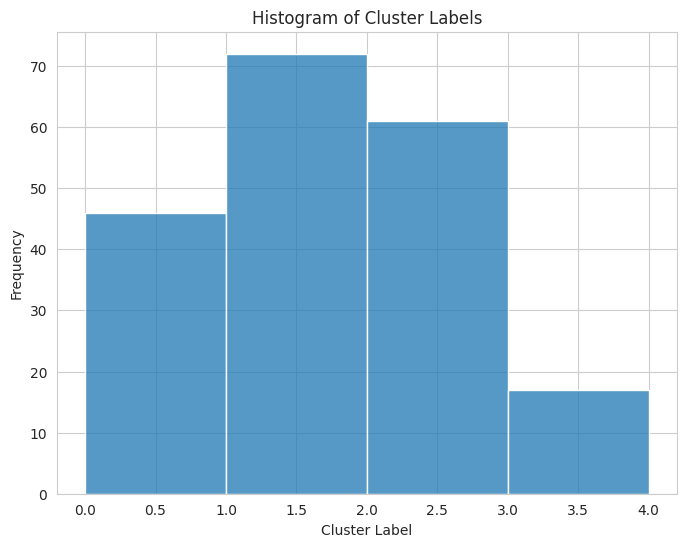

In [94]:
# prompt: make a histogram of ClusterLabel column of df_merged

plt.figure(figsize=(8, 6))
sns.histplot(data=df_merged, x="ClusterLabel", bins=df_merged["ClusterLabel"].nunique(), kde=False)
plt.title("Histogram of Cluster Labels")
plt.xlabel("Cluster Label")
plt.ylabel("Frequency")
plt.show()


In [95]:
renaming_dictionary = {'G04Q11. How old are you?  \xa0  ': "Age",
    "G02Q18. Please enter your citizenship:": "Citizenship",
    "G04Q12. What is your highest completed level of education?": "Education",
    "G04Q13. What is your level of English proficiency?": "EnglishProficiency",
    "G04Q14. Do you have any previous experience in the field of machine learning?": "MLExperience",
    "G04Q16. Do you have any previous experience with counterfactual explanation frameworks or causality frameworks?": "CFEExperience",
    "G02Q17. Do you have a medical background?": "MedicalBackground",
    "G02Q08. From 1 (not at all) to 6 (perfectly), how well did you understand the metrics:": "MetricUnderstanding"}

In [96]:
# prompt: rename columns based on renaming_dictionary in df_merged

# Rename columns in df_merged based on renaming_dictionary
df_merged = df_merged.rename(columns=renaming_dictionary)

print(df_merged.head())
df_merged.columns


   id  ClusterLabel              Age Citizenship  \
0  64             1  18-24 years old     Mexican   
1  66             1  18-24 years old     Mexican   
2  67             0  25-34 years old     Mexican   
3  68             4  18-24 years old      polish   
4  69             2  25-34 years old    Mexican    

                         Education                 EnglishProficiency  \
0  Bachelor's degree or equivalent  Native speaker / Fully proficient   
1  Bachelor's degree or equivalent  Native speaker / Fully proficient   
2  Bachelor's degree or equivalent  Native speaker / Fully proficient   
3  Bachelor's degree or equivalent              Moderately proficient   
4  Bachelor's degree or equivalent  Native speaker / Fully proficient   

                       MLExperience                           CFEExperience  \
0                     No experience                                      No   
1                   Some experience                                      No   
2  I am stu

Index(['id', 'ClusterLabel', 'Age', 'Citizenship', 'Education',
       'EnglishProficiency', 'MLExperience', 'CFEExperience',
       'MedicalBackground', 'MetricUnderstanding'],
      dtype='object')

In [97]:
df_merged.head()

id  ClusterLabel              Age Citizenship  \
0  64             1  18-24 years old     Mexican   
1  66             1  18-24 years old     Mexican   
2  67             0  25-34 years old     Mexican   
3  68             4  18-24 years old      polish   
4  69             2  25-34 years old    Mexican    

                         Education                 EnglishProficiency  \
0  Bachelor's degree or equivalent  Native speaker / Fully proficient   
1  Bachelor's degree or equivalent  Native speaker / Fully proficient   
2  Bachelor's degree or equivalent  Native speaker / Fully proficient   
3  Bachelor's degree or equivalent              Moderately proficient   
4  Bachelor's degree or equivalent  Native speaker / Fully proficient   

                       MLExperience                           CFEExperience  \
0                     No experience                                      No   
1                   Some experience                                      No   
2  I am studying in a related field  I am familiar with the general concept   
3                   Some experience                                      No   
4                   Some experience                                      No   

                                   MedicalBackground  MetricUnderstanding  
0                                                 No                    5  
1                                                 No                    5  
2                                                 No                    6  
3                                                 No                    5  
4  I work with medical data or in a field related...                    5

In [98]:
print("=== Mean Age by Cluster ===")
age_by_cluster = df_merged.groupby("ClusterLabel")["Age"].agg(["mean","std","count"])
print(age_by_cluster)

# One-way ANOVA (if more than 2 clusters)
groups = []
for label in df_merged["ClusterLabel"].unique():
    group_ages = df_merged.loc[df_merged["ClusterLabel"] == label, "Age"].dropna()
    groups.append(group_ages)

if len(groups) > 1:
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nANOVA on Age: F={f_stat:.3f}, p={p_value:.4f}")

# Optional boxplot
sns.boxplot(data=df_merged, x="ClusterLabel", y="Age")
plt.title("Age Distribution by Cluster")
plt.show()




=== Mean Age by Cluster ===


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
age_map = {
    "18-24 years old": 21.0,
    "25-34 years old": 29.5,
    "35-44 years old": 39.5,
    "45-54 years old": 49.5,
    "55-64 years old": 59.5,
    "65 years old or older": 70.0
}

# Create a new column with numeric midpoints
df_merged["AgeNumeric"] = df_merged["Age"].map(age_map)

# Drop rows if Age wasn't mapped
df_merged.dropna(subset=["AgeNumeric"], inplace=True)

print(df_merged[["Age", "AgeNumeric"]].head(10))

In [ ]:
# 1) Mean, std by cluster
age_by_cluster = df_merged.groupby("ClusterLabel")["AgeNumeric"].agg(["mean","std","count"])
print(age_by_cluster)

# 2) ANOVA if multiple clusters
import scipy.stats as stats

groups = [
    df_merged.loc[df_merged["ClusterLabel"]==cl, "AgeNumeric"].dropna()
    for cl in df_merged["ClusterLabel"].unique()
]
if len(groups) > 1:
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"ANOVA on numeric Age: F={f_stat:.3f}, p={p_value:.4f}")

# 3) Boxplot
sns.boxplot(data=df_merged, x="ClusterLabel", y="AgeNumeric")
plt.title("Age (midpoints) by Cluster")
plt.show()

In [ ]:
# 1) Cross-tab: cluster vs age range
age_ct = pd.crosstab(df_merged["ClusterLabel"], df_merged["Age"])
print(age_ct)

# 2) Chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(age_ct)
print(f"Chi-square={chi2:.3f}, p={p_val:.4f}, dof={dof}")

# 3) Stacked bar plot
ax = age_ct.plot(kind="bar", stacked=True, figsize=(8,5))
# We'll build a title string including the chi-square info
plt.xlabel("ClusterLabel")
plt.ylabel("Count")

# Optional: adjust layout if text overlaps
plt.tight_layout()

plt.savefig("age_distribution_by_cluster.png", dpi=300)
plt.show()

In [ ]:
##################################
# 2. Summaries of a categorical feature (Education)
##################################
edu_ct = pd.crosstab(df_merged["ClusterLabel"], df_merged["Education"])
print("\n=== Education by Cluster ===")
print(edu_ct)

# Chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(edu_ct)
print(f"\nChi-square={chi2:.3f}, p={p_val:.4f}, dof={dof}")

# 3) Stacked bar plot
ax = edu_ct.plot(kind="bar", stacked=True, figsize=(8,5))
# We'll build a title string including the chi-square info
plt.xlabel("ClusterLabel")
plt.ylabel("Count")

# Optional: adjust layout if text overlaps
plt.tight_layout()

plt.savefig("education_distribution_by_cluster.png", dpi=300)
plt.show()

In [ ]:
##################################
# 2. Summaries of a categorical feature (Education)
##################################
ml_ct = pd.crosstab(df_merged["ClusterLabel"], df_merged["MLExperience"])
print("\n=== MLExperience by Cluster ===")
print(ml_ct)

# Chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(ml_ct)
print(f"\nChi-square={chi2:.3f}, p={p_val:.4f}, dof={dof}")

# 3) Stacked bar plot
ax = ml_ct.plot(kind="bar", stacked=True, figsize=(8,5))
# We'll build a title string including the chi-square info
plt.xlabel("ClusterLabel")
plt.ylabel("Count")

# Optional: adjust layout if text overlaps
plt.tight_layout()

plt.savefig("ml_experience_distribution_by_cluster.png", dpi=300)
plt.show()

In [ ]:
##################################
# 2. Summaries of a categorical feature (Education)
##################################
cf_ex_ct = pd.crosstab(df_merged["ClusterLabel"], df_merged["CFEExperience"])
print("\n=== CFEExperience by Cluster ===")
print(cf_ex_ct)

# Chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(cf_ex_ct)
print(f"\nChi-square={chi2:.3f}, p={p_val:.4f}, dof={dof}")

# 3) Stacked bar plot
ax = cf_ex_ct.plot(kind="bar", stacked=True, figsize=(8,5))
# We'll build a title string including the chi-square info
plt.xlabel("ClusterLabel")
plt.ylabel("Count")

# Optional: adjust layout if text overlaps
plt.tight_layout()

plt.savefig("cf_experience_distribution_by_cluster.png", dpi=300)
plt.show()


In [ ]:
##################################
# 2. Summaries of a categorical feature (Education)
##################################
med_ct = pd.crosstab(df_merged["ClusterLabel"], df_merged["MedicalBackground"])
print("\n=== MedicalBackground by Cluster ===")
print(med_ct)

# Chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(med_ct)
print(f"\nChi-square={chi2:.3f}, p={p_val:.4f}, dof={dof}")

# 3) Stacked bar plot
ax = med_ct.plot(kind="bar", stacked=True, figsize=(8,5))
# We'll build a title string including the chi-square info
plt.xlabel("ClusterLabel")
plt.ylabel("Count")

# Optional: adjust layout if text overlaps
plt.tight_layout()

plt.savefig("medical_distribution_by_cluster.png", dpi=300)
plt.show()


In [ ]:
##################################
# 2. Summaries of a categorical feature (Education)
##################################
metric_ct = pd.crosstab(df_merged["ClusterLabel"], df_merged["MetricUnderstanding"])
print("\n=== MetricUnderstanding by Cluster ===")
print(metric_ct)

# Chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(metric_ct)
print(f"\nChi-square={chi2:.3f}, p={p_val:.4f}, dof={dof}")

# 3) Stacked bar plot
ax = metric_ct.plot(kind="bar", stacked=True, figsize=(8,5))
# We'll build a title string including the chi-square info
plt.xlabel("ClusterLabel")
plt.ylabel("Count")

# Optional: adjust layout if text overlaps
plt.tight_layout()

plt.savefig("metric_underst_distribution_by_cluster.png", dpi=300)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Make sure df_long has 'ScenarioID' (int or str), the 7 metrics, and 'Satisfaction_cat'
# If not already done, drop rows where 'Satisfaction_cat' is NaN
df_long.dropna(subset=["Satisfaction_cat"], inplace=True)

# 1) Identify all scenario IDs
all_scenarios = df_long["ScenarioID"].unique()
print("All scenarios:", all_scenarios)

# 2) Randomly pick 6 scenario IDs for test set
# For reproducibility, set a seed:
np.random.seed(42)
test_scenarios = np.random.choice(all_scenarios, size=6, replace=False)
print("Test scenarios:", test_scenarios)

# 3) Filter df_long into train vs. test
df_train = df_long[~df_long["ScenarioID"].isin(test_scenarios)]
df_test  = df_long[df_long["ScenarioID"].isin(test_scenarios)]

print(f"Train set size: {df_train.shape}, Test set size: {df_test.shape}")

# 4) Define X and y for each set
X_train = df_train[[
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity"
]]
y_train = df_train["Satisfaction_cat"]

X_test = df_test[[
    "Feasibility",
    "Consistency",
    "Completeness",
    "Trust",
    "Understandability",
    "Fairness",
    "Complexity"
]]
y_test = df_test["Satisfaction_cat"]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize a logistic regression model
logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42)

# Fit on the training set
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (Scenario-based split): {acc:.3f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=["low","medium","high"]))

In [ ]:
df_long.dropna(subset=["Satisfaction_cat"], inplace=True)
classes, counts = np.unique(df_long["Satisfaction_cat"], return_counts=True)
print("Classes:", classes)
print("Counts:", counts)

In [ ]:
def scenario_k_folds(scenario_ids, n_splits=5, random_state=42):
    """
    Splits the list of scenario_ids into n_splits folds.
    Each fold is (train_scenarios, test_scenarios).
    """
    scenario_ids = list(scenario_ids)
    random.seed(random_state)
    random.shuffle(scenario_ids)

    # For n=5, each fold ~ 30/5 = 6 scenario IDs
    fold_size = len(scenario_ids) // n_splits
    for i in range(n_splits):
        start = i * fold_size
        end = start + fold_size
        test_scen = scenario_ids[start:end]
        train_scen = scenario_ids[:start] + scenario_ids[end:]
        yield (train_scen, test_scen)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random

In [ ]:
all_scenarios = df_long["ScenarioID"].unique()
print("Number of distinct scenarios:", len(all_scenarios))
folds = list(scenario_k_folds(all_scenarios, n_splits=5, random_state=42))

In [ ]:
# We'll store performance metrics per fold
fold_accuracies = []
fold_reports = []

for fold_idx, (train_scen, test_scen) in enumerate(folds):
    print(f"=== Fold {fold_idx+1} ===")
    print("Train scenarios:", train_scen)
    print("Test scenarios:", test_scen)

    # 1) Filter df_long
    df_train = df_long[df_long["ScenarioID"].isin(train_scen)]
    df_test = df_long[df_long["ScenarioID"].isin(test_scen)]

    # 2) Check class distribution
    train_counts = df_train["Satisfaction_cat"].value_counts()
    test_counts = df_test["Satisfaction_cat"].value_counts()
    print("Train class distribution:\n", train_counts)
    print("Test class distribution:\n", test_counts)

    # 3) Define X, y for train/test
    X_train = df_train[[
        "Feasibility", "Consistency", "Completeness",
        "Trust", "Understandability", "Fairness",
        "Complexity"
    ]]
    y_train = df_train["Satisfaction_cat"]

    X_test = df_test[[
        "Feasibility", "Consistency", "Completeness",
        "Trust", "Understandability", "Fairness",
        "Complexity"
    ]]
    y_test = df_test["Satisfaction_cat"]

    # 4) Train a model (Example: Logistic Regression)
    model = LogisticRegression(
        multi_class="multinomial", solver="lbfgs",
        max_iter=1000, random_state=42
    )
    model.fit(X_train, y_train)

    # 5) Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    print(f"Fold {fold_idx+1} accuracy: {acc:.3f}")

    report = classification_report(y_test, y_pred, labels=["low", "medium", "high"], output_dict=True)
    fold_reports.append(report)

    cm = confusion_matrix(y_test, y_pred, labels=["low","medium","high"])
    print("Confusion matrix (low/medium/high):\n", cm)
    print("-----------------------------\n")

In [ ]:
import numpy as np

mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"Mean accuracy across folds: {mean_acc:.3f} ± {std_acc:.3f}")

In [ ]:
macro_f1s = [rep["macro avg"]["f1-score"] for rep in fold_reports]
mean_macro_f1 = np.mean(macro_f1s)
std_macro_f1 = np.std(macro_f1s)
print(f"Macro F1 across folds: {mean_macro_f1:.3f} ± {std_macro_f1:.3f}")

In [ ]:
model.coef_

In [ ]:
models = [
    ("DecisionTree", DecisionTreeClassifier(random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
]

In [ ]:
def run_scenario_cv(df_long, models, n_splits=5):
    # Prepare the folds
    scenario_ids = df_long["ScenarioID"].unique()
    folds = list(scenario_k_folds(scenario_ids, n_splits=n_splits, random_state=42))

    # For storing results
    results = []

    # Loop over each model
    for (model_name, model) in models:
        fold_accuracies = []
        fold_macro_f1s = []

        # Each fold
        for fold_idx, (train_scen, test_scen) in enumerate(folds):
            # Partition data
            df_train = df_long[df_long["ScenarioID"].isin(train_scen)]
            df_test  = df_long[df_long["ScenarioID"].isin(test_scen)]

            # X, y
            X_train = df_train[[
                "Feasibility", "Consistency", "Completeness",
                "Trust", "Understandability", "Fairness", "Complexity"
            ]]
            y_train = df_train["Satisfaction_cat"]

            X_test = df_test[[
                "Feasibility", "Consistency", "Completeness",
                "Trust", "Understandability", "Fairness", "Complexity"
            ]]
            y_test = df_test["Satisfaction_cat"]

            # Train
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            # Classification report with macro-F1
            report = classification_report(
                y_test, y_pred, labels=["low","medium","high"], output_dict=True
            )
            macro_f1 = report["macro avg"]["f1-score"]

            fold_accuracies.append(acc)
            fold_macro_f1s.append(macro_f1)

        # Summarize folds
        mean_acc = np.mean(fold_accuracies)
        std_acc = np.std(fold_accuracies)
        mean_mf1 = np.mean(fold_macro_f1s)
        std_mf1 = np.std(fold_macro_f1s)

        results.append({
            "Model": model_name,
            "Accuracy Mean": mean_acc,
            "Accuracy Std": std_acc,
            "MacroF1 Mean": mean_mf1,
            "MacroF1 Std": std_mf1
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

############################
# Run scenario-based CV
############################
results_df = run_scenario_cv(df_long, models=models, n_splits=5)
print(results_df)

In [ ]:
import random
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Helper function to create scenario-based folds
def scenario_k_folds(scenario_ids, n_splits=5, random_state=42):
    """
    Splits the list of scenario_ids into n_splits folds.
    Returns train_scen, test_scen for each fold.
    """
    scenario_ids = list(scenario_ids)
    random.seed(random_state)
    random.shuffle(scenario_ids)
    fold_size = len(scenario_ids) // n_splits
    for i in range(n_splits):
        start = i * fold_size
        end = start + fold_size
        test_scen = scenario_ids[start:end]
        train_scen = scenario_ids[:start] + scenario_ids[end:]
        yield (train_scen, test_scen)

In [ ]:
df_long.dropna(subset=["Satisfaction"], inplace=True)
all_scenarios = df_long["ScenarioID"].unique()
print("Number of distinct scenarios:", len(all_scenarios))  # e.g., 30
print("Data shape:", df_long.shape)

In [ ]:
models = [
    ("LinearRegression", LinearRegression()),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=100, random_state=42))
]

In [ ]:
def run_scenario_cv_regression(df_long, models, n_splits=5):
    """
    Perform scenario-based cross-validation for regression models.
    Returns a DataFrame of average RMSE & R^2 across folds, for each model.
    """
    # Prepare the folds
    scenario_ids = df_long["ScenarioID"].unique()
    folds = list(scenario_k_folds(scenario_ids, n_splits=n_splits, random_state=42))

    results = []

    for (model_name, model) in models:
        fold_rmses = []
        fold_r2s = []

        for fold_idx, (train_scen, test_scen) in enumerate(folds):
            # Split data by scenario
            df_train = df_long[df_long["ScenarioID"].isin(train_scen)]
            df_test  = df_long[df_long["ScenarioID"].isin(test_scen)]

            # Define X, y
            X_train = df_train[[
                "Feasibility",
                "Consistency",
                "Completeness",
                "Trust",
                "Understandability",
                "Fairness",
                "Complexity"
            ]]
            y_train = df_train["Satisfaction"]

            X_test = df_test[[
                "Feasibility",
                "Consistency",
                "Completeness",
                "Trust",
                "Understandability",
                "Fairness",
                "Complexity"
            ]]
            y_test = df_test["Satisfaction"]

            # Fit model
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Compute metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            fold_rmses.append(rmse)
            fold_r2s.append(r2)

        # Average across folds
        avg_rmse = np.mean(fold_rmses)
        std_rmse = np.std(fold_rmses)
        avg_r2 = np.mean(fold_r2s)
        std_r2 = np.std(fold_r2s)

        results.append({
            "Model": model_name,
            "RMSE Mean": avg_rmse,
            "RMSE Std": std_rmse,
            "R2 Mean": avg_r2,
            "R2 Std": std_r2
        })

    return pd.DataFrame(results)

#############################
# Run scenario-based CV
#############################
results_df = run_scenario_cv_regression(df_long, models, n_splits=5)
print(results_df)

In [ ]:
import random
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

############################
# 1. Helper to create scenario-based folds
############################
def scenario_k_folds(scenario_ids, n_splits=5, random_state=42):
    scenario_ids = list(scenario_ids)
    random.seed(random_state)
    random.shuffle(scenario_ids)
    fold_size = len(scenario_ids) // n_splits
    for i in range(n_splits):
        start = i * fold_size
        end = start + fold_size
        test_scen = scenario_ids[start:end]
        train_scen = scenario_ids[:start] + scenario_ids[end:]
        yield (train_scen, test_scen)

############################
# 2. Prepare data
############################
# df_long must have:
#   - ScenarioID
#   - Satisfaction (numeric outcome)
#   - Consistency, Completeness, Understandability, Fairness, Complexity, etc.
#   (Feasibility & Trust exist but we won't use them.)

# Drop rows where Satisfaction is NaN
df_long.dropna(subset=["Satisfaction"], inplace=True)

all_scenarios = df_long["ScenarioID"].unique()
print("Number of distinct scenarios:", len(all_scenarios))

# The reduced feature set (removed Feasibility & Trust)
predictors = [
    "Consistency",
    "Completeness",
    "Understandability",
    "Fairness",
    "Complexity"
]

############################
# 3. Define models to compare
############################
models = [
    ("LinearRegression", LinearRegression()),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=100, random_state=42))
]

############################
# 4. Scenario-based CV for regression
############################
def run_scenario_cv_regression(df, models, predictors, n_splits=5):
    scenario_ids = df["ScenarioID"].unique()
    folds = list(scenario_k_folds(scenario_ids, n_splits, random_state=42))

    results = []

    for (model_name, model) in models:
        fold_rmses = []
        fold_r2s = []

        for _, (train_scen, test_scen) in enumerate(folds):
            df_train = df[df["ScenarioID"].isin(train_scen)]
            df_test  = df[df["ScenarioID"].isin(test_scen)]

            X_train = df_train[predictors]
            y_train = df_train["Satisfaction"]

            X_test = df_test[predictors]
            y_test = df_test["Satisfaction"]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            fold_rmses.append(rmse)
            fold_r2s.append(r2)

        avg_rmse = np.mean(fold_rmses)
        std_rmse = np.std(fold_rmses)
        avg_r2 = np.mean(fold_r2s)
        std_r2 = np.std(fold_r2s)

        results.append({
            "Model": model_name,
            "RMSE Mean": avg_rmse,
            "RMSE Std": std_rmse,
            "R^2 Mean": avg_r2,
            "R^2 Std": std_r2
        })

    return pd.DataFrame(results)

############################
# 5. Run the cross-validation
############################
results_df = run_scenario_cv_regression(df_long, models, predictors, n_splits=5)
print(results_df)

In [ ]:
import random
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def scenario_k_folds(scenario_ids, n_splits=5, random_state=42):
    scenario_ids = list(scenario_ids)
    random.seed(random_state)
    random.shuffle(scenario_ids)
    fold_size = len(scenario_ids) // n_splits
    for i in range(n_splits):
        start = i * fold_size
        end = start + fold_size
        test_scen = scenario_ids[start:end]
        train_scen = scenario_ids[:start] + scenario_ids[end:]
        yield (train_scen, test_scen)

def run_scenario_cv_regression(df, models, predictors, n_splits=5):
    scenario_ids = df["ScenarioID"].unique()
    folds = list(scenario_k_folds(scenario_ids, n_splits=n_splits, random_state=42))

    results = []

    for (model_name, model) in models:
        fold_rmses = []
        fold_r2s = []

        print(f"\n=== MODEL: {model_name} ===")

        for fold_idx, (train_scen, test_scen) in enumerate(folds, start=1):
            # Create train/test subsets by scenario
            df_train = df[df["ScenarioID"].isin(train_scen)]
            df_test  = df[df["ScenarioID"].isin(test_scen)]

            X_train = df_train[predictors]
            y_train = df_train["Satisfaction"]
            X_test  = df_test[predictors]
            y_test  = df_test["Satisfaction"]

            # Fit model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            fold_rmses.append(rmse)
            fold_r2s.append(r2)

            print(f"Fold {fold_idx}: RMSE={rmse:.3f}, R^2={r2:.3f}")

            # If Linear Regression, print coefficients
            if model_name == "LinearRegression":
                # model.coef_ is a 1D array for each predictor
                coef_pairs = list(zip(predictors, model.coef_))
                print("  Coefficients (fold {fold_idx}):")
                for col, c in coef_pairs:
                    print(f"    {col}: {c:.3f}")

                # Also intercept
                print(f"  Intercept: {model.intercept_:.3f}")

        # Average across folds
        avg_rmse = np.mean(fold_rmses)
        std_rmse = np.std(fold_rmses)
        avg_r2 = np.mean(fold_r2s)
        std_r2 = np.std(fold_r2s)

        results.append({
            "Model": model_name,
            "RMSE Mean": avg_rmse,
            "RMSE Std": std_rmse,
            "R^2 Mean": avg_r2,
            "R^2 Std": std_r2
        })

    return pd.DataFrame(results)

# EXAMPLE USAGE:
############################
# 1. Prepare your df_long
#    with columns [ScenarioID, Satisfaction, etc...]
############################

df_long.dropna(subset=["Satisfaction"], inplace=True)
all_scenarios = df_long["ScenarioID"].unique()

predictors = [
    "Consistency",
    "Completeness",
    "Understandability",
    "Fairness",
    "Complexity"
]

models = [
    ("LinearRegression", LinearRegression()),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)),
    ("RandomForestRegressor", RandomForestRegressor(random_state=42))
]

results_df = run_scenario_cv_regression(df_long, models, predictors, n_splits=5)
print("\n=== FINAL RESULTS ===")
print(results_df)